# LAMPO: Language and Preference Conditioned RL (Gymnasium Version)

This notebook trains a LAMPO agent on CartPole-v1, LunarLander-v2, and MountainCar-v0 using Gymnasium. It includes interactive sliders, Pareto frontier visualization, and video recording of trained policies.

In [ ]:
# ===================== System Dependencies =====================

%%capture
!sudo apt-get install -y xvfb x11-utils ffmpeg
!pip install -q  pyvirtualdisplay pyglet pyopengl ipywidgets matplotlib
!pip install -q minigrid
!pip install pyvirtualdisplay
!pip install swig
!pip install gymnasium[box2d]

# ===================== Python Standard Libraries =====================
import os
import shutil
import csv
import json
import random
from random import sample
from pathlib import Path
from collections import deque
import time
import copy
import base64
from warnings import filterwarnings

# ===================== Numpy & Pandas =====================
import numpy as np
np.bool8 = np.bool_  # compatibility
import pandas as pd

# ===================== PyTorch =====================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader

# ===================== Gymnasium & MiniGrid =====================
import gymnasium as gym
from gymnasium.wrappers import RecordVideo

# ===================== Visualization =====================
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from IPython import display as ipythondisplay
from IPython.display import display, clear_output
from IPython.display import display as ipy_display, clear_output as ipy_clear_output
from pyvirtualdisplay import Display
import ipywidgets as widgets

# ===================== Scientific Computing =====================
import scipy.stats as stats
from sklearn.metrics import cohen_kappa_score, confusion_matrix

# ===================== Google Colab =====================
from google.colab import drive, files

# ===================== Warnings =====================
filterwarnings(action="ignore", category=DeprecationWarning)

# ===================== Device =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================== Global Environment Config =====================
ENV_MAX_STEPS = {
    "CartPole-v1": 500,
    "LunarLander-v3": 1000,
    "MiniGrid-DoorKey-5x5-v0": 200,
    "MountainCar-v0": 200
}

# ===================== Virtual Display =====================
vdisplay = Display(visible=0, size=(1400, 900))
vdisplay.start()

print("All imports loaded successfully!")
print(f"   Device: {device}")
print(f"   PyTorch version: {torch.__version__}")

In [ ]:
# ===================== Env Helpers =====================

def make_env(env_id, seed=None, render_mode=None):
    if render_mode is None:
        env = gym.make(env_id)
    else:
        env = gym.make(env_id, render_mode=render_mode)

    if seed is not None:
        env.reset(seed=seed)
        env.action_space.seed(seed)
    return env


def safe_reset(env):
    """Handle Gymnasium and any legacy style reset outputs."""
    out = env.reset()
    if isinstance(out, tuple):
        obs, info = out
        return obs
    return out


def safe_step(env, action):
    """Handle Gymnasium (5 outputs) and legacy (4 outputs) uniformly."""
    out = env.step(action)
    if len(out) == 5:
        obs, reward, terminated, truncated, info = out
        done = terminated or truncated
        return obs, reward, done, info
    else:
        obs, reward, done, info = out
        return obs, reward, done, info


def get_rgb_frame(env):
    try:
        frame = env.render()
    except TypeError:
        frame = env.render(mode="rgb_array")
    return frame


def process_observation(env_id, obs):
    """Convert env observation into a 1D float32 vector for the networks."""
    if env_id.startswith("MiniGrid"):
        if isinstance(obs, dict) and "image" in obs:
            img = obs["image"].astype(np.float32) / 10.0
            return img.flatten()
        arr = np.array(obs, dtype=np.float32)
        return arr.flatten()
    else:
        return np.array(obs, dtype=np.float32)


# ===================== Checkpoint and Download =====================

def save_checkpoint(model, filename, mode=0):
    if mode == 1:
        drive.mount('/content/gdrive')
        path = "/content/gdrive/My Drive/{}".format(filename)
        torch.save(model.state_dict(), path)
    else:
        torch.save(model.state_dict(), filename)


def export_to_local_drive(filename):
    files.download(filename)


# ===================== Multi Environment Reward Decomposition =====================

def compute_rewards(env_id, state_vec, action, next_state_vec, done, env_reward, lam):
    """
    Decompose reward into r_speed and r_safety with genuine conflicts.
    Creates clear trade-offs for meaningful Pareto frontiers.
    """

    # ===== CartPole =====
    if env_id == "CartPole-v1":
        angle = abs(next_state_vec[2])
        position = abs(next_state_vec[0])

        # SPEED: Just stay alive, don't care about position/angle
        r_speed = 1.0 if not done else -10.0

        # SAFETY: Penalize deviation from center and upright position
        angle_penalty = (angle / 0.209) ** 2  # squared for stronger penalty
        position_penalty = (position / 2.4) ** 2
        r_safety = -5.0 * (angle_penalty + position_penalty)

        if not done:
            r_safety += 1.0  # reward for staying stable

    # ==================== LunarLander ====================
    elif env_id == "LunarLander-v3":
        x = next_state_vec[0]
        y = next_state_vec[1]
        vx = next_state_vec[2]
        vy = next_state_vec[3]
        angle = next_state_vec[4]
        angular_vel = next_state_vec[5]
        left_leg = next_state_vec[6] if len(next_state_vec) > 6 else 0
        right_leg = next_state_vec[7] if len(next_state_vec) > 7 else 0

        # Track ground contact
        on_ground = (left_leg > 0 or right_leg > 0)
        success = (left_leg > 0 and right_leg > 0)

        # Compute useful quantities
        speed = (vx**2 + vy**2) ** 0.5
        is_upright = abs(angle) < 0.3
        is_centered = abs(x) < 0.4
        is_slow = speed < 0.8

        # ========== SPEED REWARD: Land FAST ==========
        r_speed = 0.0

        # TIME PENALTY - encourages quick landing
        r_speed -= 0.3

        # Reward for being low (close to ground)
        r_speed += 0.5 * max(0, 1.0 - y)

        # Reward descending (negative vy = going down)
        if vy < 0:
            r_speed += 0.2 * min(abs(vy), 1.0)

        # Reward being near landing pad
        r_speed += 0.2 * max(0, 1.0 - abs(x))

        # Landing rewards
        if done:
            if success:
                r_speed += 100.0  # Landed!
            elif on_ground:
                r_speed += 30.0   # Touched ground
            else:
                r_speed -= 50.0   # Crash/timeout

        # ========== SAFETY REWARD: Land GENTLY ==========
        r_safety = 0.0

        # TIME PENALTY - must still land, can't hover forever
        r_safety -= 0.1

        # Reward being upright
        r_safety += 0.2 * max(0, 1.0 - abs(angle) * 2)

        # Reward being centered
        r_safety += 0.1 * max(0, 1.0 - abs(x))

        # Reward controlled descent (slow but still descending)
        if vy < 0 and abs(vy) < 0.5:  # Descending slowly
            r_safety += 0.3
        elif vy > 0.1:  # Going UP is bad - wasting fuel
            r_safety -= 0.2

        # Reward low horizontal speed
        r_safety += 0.1 * max(0, 1.0 - abs(vx) * 2)

        # Penalize spinning
        r_safety -= 0.1 * min(abs(angular_vel), 1.0)

        # Small bonus for being low (encourages landing)
        if y < 0.5:
            r_safety += 0.2

        # Landing rewards - BIG bonuses for gentle landing
        if done:
            if success:
                landing_speed = speed
                if landing_speed < 0.3:
                    r_safety += 150.0  # Perfect gentle landing
                elif landing_speed < 0.5:
                    r_safety += 100.0  # Good landing
                elif landing_speed < 0.8:
                    r_safety += 60.0   # Okay landing
                else:
                    r_safety += 30.0   # Hard landing but success
            elif on_ground:
                r_safety += 10.0
            else:
                r_safety -= 80.0  # Crash/timeout is BAD for safety

    # ===== MiniGrid DoorKey=====
    elif env_id.startswith("MiniGrid-DoorKey"):
        r_speed = -1.0  # time penalty
        if env_reward > 0:
            r_speed += 100.0  # huge reward for completing

        r_safety = 0.0
        if action == 2:  # forward movement
            r_safety -= 1.0  # moving is "risky"
        if action in [0, 1]:  # turning
            r_safety += 0.5  # turning is "safe"
        if env_reward > 0:
            r_safety += 50.0

    # ==================== MountainCar ====================
    elif env_id == "MountainCar-v0":
        position = next_state_vec[0]
        velocity = next_state_vec[1]

        # SPEED: Encourage reaching goal quickly
        r_speed = -1.0  # time penalty (every step costs)

        # Big bonus for reaching the goal
        if position >= 0.5:
            r_speed += 200.0

        # Reward for making progress (moving right)
        if position > -0.5:  # past the starting valley
            r_speed += (position + 0.5) * 10.0

        # SAFETY: Encourage energy efficiency and smooth movement
        # Penalize aggressive actions (0=push left, 1=no push, 2=push right)
        if action == 0:  # pushing left (against goal direction)
            action_cost = 2.0
        elif action == 2:  # pushing right (aggressive)
            action_cost = 1.5
        else:  # no action (coasting)
            action_cost = 0.0

        r_safety = -action_cost

        # Reward smooth, controlled velocity
        r_safety += -abs(velocity) * 5.0

        # Bonus for reaching goal smoothly
        if position >= 0.5:
            # Bonus based on how gently you arrived
            smoothness_bonus = max(50.0 - abs(velocity) * 100.0, 0.0)
            r_safety += smoothness_bonus

    else:
        # Fallback
        r_speed = env_reward
        r_safety = 0.0

    # ==================== Combine with Lambda ====================
    # Now r_speed and r_safety are INDEPENDENT, COMPETING objectives
    combined = lam * r_speed + (1.0 - lam) * r_safety

    return combined, r_speed, r_safety

# ===================== Video Utility =====================

def show_video(path):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            '''<video alt="{}" autoplay loop controls style="height: 400px;">
                   <source src="data:video/mp4;base64,{}" type="video/mp4" />
               </video>'''.format(mp4, video_b64.decode('ascii'))
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))


def record_trained_video(env_id, agent, is_lampo=False,
                         lam_val=0.5, prompt="balanced",
                         video_dir="trained_video", max_steps=None):
    """Record a video of a trained agent."""
    if max_steps is None:
        max_steps = ENV_MAX_STEPS.get(env_id, 500)

    if os.path.exists(video_dir):
        for f in Path(video_dir).glob("*.mp4"):
            f.unlink()
    else:
        os.makedirs(video_dir, exist_ok=True)

    env = make_env(env_id, render_mode="rgb_array")
    env = RecordVideo(env, video_dir, episode_trigger=lambda n: True)

    obs = safe_reset(env)
    state_vec = process_observation(env_id, obs)
    done = False
    steps = 0
    total_reward = 0.0

    if is_lampo:
        text_emb = PROMPT_EMBEDDINGS[prompt]

    while not done and steps < max_steps:
        if is_lampo:
            action, _, _ = agent.select_action(state_vec, lam_val, text_emb, deterministic=True)
        else:
            action, _, _ = agent.select_action(state_vec, deterministic=True)

        next_obs, env_reward, done, info = safe_step(env, action)
        next_state_vec = process_observation(env_id, next_obs)

        if is_lampo:
            combined_reward, _, _ = compute_rewards(
                env_id, state_vec, action, next_state_vec, done, env_reward, lam_val
            )
            total_reward += combined_reward
        else:
            total_reward += env_reward

        state_vec = next_state_vec
        steps += 1

    env.close()
    print("Recorded video on {}, steps {}, total return {:.2f}".format(env_id, steps, total_reward))
    show_video(video_dir)
    del env

In [ ]:
# ===================== LAMPO Policy Network =====================
class LAMPOPolicyNetwork(nn.Module):
    """Policy network conditioned on lambda and text embeddings"""
    def __init__(self, state_dim, action_dim, text_dim=3, hidden_dim=128):
        super().__init__()
        input_dim = state_dim + 1 + text_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state, lam, text_embedding):
        x = torch.cat([state, lam, text_embedding], dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

    def get_action(self, state, lam, text_embedding, deterministic=False):
        logits = self.forward(state, lam, text_embedding)
        dist = Categorical(logits=logits)

        if deterministic:
            action = torch.argmax(logits, dim=-1)
            return action

        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action, log_prob

    def evaluate(self, state, lam, text_embedding, action):
        logits = self.forward(state, lam, text_embedding)
        dist = Categorical(logits=logits)
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        return log_prob, entropy


# ===================== LAMPO Value Network =====================
class LAMPOValueNetwork(nn.Module):
    """Value network conditioned on lambda and text embeddings"""
    def __init__(self, state_dim, text_dim=3, hidden_dim=128):
        super().__init__()
        input_dim = state_dim + 1 + text_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, lam, text_embedding):
        x = torch.cat([state, lam, text_embedding], dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value.squeeze(-1)


# ===================== LAMPO Buffer =====================
class LAMPOBuffer:
    """Buffer that stores lambda and text embeddings along with transitions"""
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.dones = []
        self.values = []
        self.lambdas = []
        self.text_embeddings = []

    def store(self, state, action, reward, log_prob, done, value, lam, text_emb):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.log_probs.append(log_prob)
        self.dones.append(done)
        self.values.append(value)
        self.lambdas.append(lam)
        self.text_embeddings.append(text_emb)

    def compute_gae(self, gamma=0.99, lam=0.95):
        rewards = np.array(self.rewards)
        values = np.array(self.values)
        dones = np.array(self.dones)

        advantages = np.zeros_like(rewards)
        last_gae = 0.0

        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_value = 0.0
            else:
                next_value = values[t + 1]

            if dones[t]:
                next_value = 0.0
                last_gae = 0.0

            delta = rewards[t] + gamma * next_value - values[t]
            last_gae = delta + gamma * lam * last_gae
            advantages[t] = last_gae

        returns = advantages + values
        return returns, advantages

    def get(self):
        return {
            'states': torch.FloatTensor(np.array(self.states)).to(device),
            'actions': torch.LongTensor(np.array(self.actions)).to(device),
            'log_probs': torch.FloatTensor(np.array(self.log_probs)).to(device),
            'lambdas': torch.FloatTensor(np.array(self.lambdas)).to(device),
            'text_embeddings': torch.FloatTensor(np.array(self.text_embeddings)).to(device)
        }

    def clear(self):
        self.states, self.actions, self.rewards = [], [], []
        self.log_probs, self.dones, self.values = [], [], []
        self.lambdas, self.text_embeddings = [], []


# ===================== Text Embeddings =====================
PROMPT_EMBEDDINGS = {
    # Pure bases
    "be cautious": np.array([1.0, 0.0, 0.0]),
    "go fast":     np.array([0.0, 1.0, 0.0]),
    "balanced":    np.array([0.0, 0.0, 1.0]),

    # Unique mixed preferences
    "slightly cautious":      np.array([0.6, 0.3, 0.1]),
    "steady progress":        np.array([0.4, 0.4, 0.2]),
    "risky but smooth":       np.array([0.2, 0.7, 0.1]),
    "fast but under control": np.array([0.2, 0.5, 0.3]),
    "safe but steady":        np.array([0.7, 0.2, 0.1]),
    "explore and balance":    np.array([0.3, 0.3, 0.4])
}

In [ ]:
# ===================== LAMPO Agent =====================
class LAMPOAgent:
    def __init__(self, state_dim, action_dim, text_dim=3, lr=3e-4, gamma=0.99,
                 lam=0.95, clip_epsilon=0.2, value_coef=0.5, entropy_coef=0.01,
                 ppo_epochs=10, minibatch_size=64):

        self.policy = LAMPOPolicyNetwork(state_dim, action_dim, text_dim).to(device)
        self.value = LAMPOValueNetwork(state_dim, text_dim).to(device)

        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=lr)

        self.gamma = gamma
        self.lam = lam
        self.clip_epsilon = clip_epsilon
        self.value_coef = value_coef
        self.entropy_coef = entropy_coef
        self.ppo_epochs = ppo_epochs
        self.minibatch_size = minibatch_size

        self.buffer = LAMPOBuffer()

    def select_action(self, state_vec, lam_val, text_emb, deterministic=False):
        state_tensor = torch.FloatTensor(state_vec).unsqueeze(0).to(device)
        lam_tensor = torch.FloatTensor([lam_val]).unsqueeze(0).to(device)
        text_tensor = torch.FloatTensor(text_emb).unsqueeze(0).to(device)

        if deterministic:
            action = self.policy.get_action(state_tensor, lam_tensor, text_tensor,
                                            deterministic=True)
            return action.cpu().numpy()[0], None, None

        action, log_prob = self.policy.get_action(state_tensor, lam_tensor, text_tensor)
        value = self.value(state_tensor, lam_tensor, text_tensor)
        return action.cpu().numpy()[0], log_prob.item(), value.item()

    def store_transition(self, state_vec, action, reward, log_prob, done, value, lam_val, text_emb):
        self.buffer.store(state_vec, action, reward, log_prob, done, value, lam_val, text_emb)

    def update(self):
        returns, advantages = self.buffer.compute_gae(self.gamma, self.lam)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        data = self.buffer.get()
        states = data['states']
        actions = data['actions']
        old_log_probs = data['log_probs']
        lambdas = data['lambdas'].unsqueeze(-1)
        text_embeddings = data['text_embeddings']

        returns_tensor = torch.FloatTensor(returns).to(device)
        advantages_tensor = torch.FloatTensor(advantages).to(device)

        total_policy_loss = 0.0
        total_value_loss = 0.0
        n_updates = 0

        for _ in range(self.ppo_epochs):
            indices = np.arange(len(states))
            np.random.shuffle(indices)

            for start in range(0, len(states), self.minibatch_size):
                end = start + self.minibatch_size
                minibatch_indices = indices[start:end]

                mb_states = states[minibatch_indices]
                mb_actions = actions[minibatch_indices]
                mb_old_log_probs = old_log_probs[minibatch_indices]
                mb_advantages = advantages_tensor[minibatch_indices]
                mb_returns = returns_tensor[minibatch_indices]
                mb_lambdas = lambdas[minibatch_indices]
                mb_text_emb = text_embeddings[minibatch_indices]

                log_probs, entropy = self.policy.evaluate(
                    mb_states, mb_lambdas, mb_text_emb, mb_actions
                )
                values = self.value(mb_states, mb_lambdas, mb_text_emb)

                ratio = torch.exp(log_probs - mb_old_log_probs)
                surr1 = ratio * mb_advantages
                surr2 = torch.clamp(ratio, 1 - self.clip_epsilon,
                                    1 + self.clip_epsilon) * mb_advantages
                policy_loss = -torch.min(surr1, surr2).mean()

                value_loss = F.mse_loss(values, mb_returns)
                entropy_loss = -entropy.mean()

                loss = policy_loss + self.value_coef * value_loss + self.entropy_coef * entropy_loss

                self.policy_optimizer.zero_grad()
                self.value_optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
                torch.nn.utils.clip_grad_norm_(self.value.parameters(), 0.5)
                self.policy_optimizer.step()
                self.value_optimizer.step()

                total_policy_loss += policy_loss.item()
                total_value_loss += value_loss.item()
                n_updates += 1

        self.buffer.clear()
        return total_policy_loss / n_updates, total_value_loss / n_updates


# ===================== LAMPO Training and Evaluation =====================
def train_lampo(env_id,
                agent,
                max_episodes=3000,
                batch_size=2048,
                eval_freq=50,
                target_reward=200.0,
                seed=42,
                max_steps=None):

    if max_steps is None:
        max_steps = ENV_MAX_STEPS.get(env_id, 500)

    env = make_env(env_id, seed=seed)
    episode_rewards = []
    eval_rewards = []
    total_steps = 0
    episode = 0
    best_eval_reward = -float('inf')

    speed_rewards = []
    safety_rewards = []

    print("Starting LAMPO training on {}".format(env_id))
    print("Target reward: {}".format(target_reward))

    while episode < max_episodes:
        steps_collected = 0
        batch_rewards = []
        batch_speed_rewards = []
        batch_safety_rewards = []

        while steps_collected < batch_size:
            lam_val = float(np.random.uniform(0.0, 1.0))
            prompt = np.random.choice(list(PROMPT_EMBEDDINGS.keys()))
            text_emb = PROMPT_EMBEDDINGS[prompt]

            obs = safe_reset(env)
            state_vec = process_observation(env_id, obs)

            done = False
            episode_reward = 0.0
            episode_speed_reward = 0.0
            episode_safety_reward = 0.0
            steps = 0

            while not done and steps < max_steps:
                action, log_prob, value = agent.select_action(state_vec, lam_val, text_emb)
                next_obs, env_reward, done, info = safe_step(env, action)
                next_state_vec = process_observation(env_id, next_obs)

                combined_reward, r_speed, r_safety = compute_rewards(
                    env_id,
                    state_vec,
                    action,
                    next_state_vec,
                    done,
                    env_reward,
                    lam_val
                )

                agent.store_transition(
                    state_vec,
                    action,
                    combined_reward,
                    log_prob,
                    done,
                    value,
                    lam_val,
                    text_emb
                )

                state_vec = next_state_vec
                episode_reward += combined_reward
                episode_speed_reward += r_speed
                episode_safety_reward += r_safety

                total_steps += 1
                steps_collected += 1
                steps += 1

                if done:
                    break

            batch_rewards.append(episode_reward)
            batch_speed_rewards.append(episode_speed_reward)
            batch_safety_rewards.append(episode_safety_reward)
            episode += 1

        policy_loss, value_loss = agent.update()

        avg_reward = float(np.mean(batch_rewards))
        avg_speed = float(np.mean(batch_speed_rewards))
        avg_safety = float(np.mean(batch_safety_rewards))

        episode_rewards.extend(batch_rewards)
        speed_rewards.append(avg_speed)
        safety_rewards.append(avg_safety)

        if episode % eval_freq == 0:
            eval_results = {}
            for test_lam in [0.0, 0.5, 1.0]:
                eval_reward = evaluate_lampo(
                    agent,
                    env_id,
                    lam_val=test_lam,
                    text_emb=PROMPT_EMBEDDINGS["balanced"],
                    n_rollouts=5,
                    max_steps=max_steps
                )
                eval_results[test_lam] = eval_reward

            avg_eval = float(np.mean(list(eval_results.values())))
            eval_rewards.append((total_steps, avg_eval))

            print("Episode {}, Steps {}".format(episode, total_steps))
            print("  Train Reward: {:.2f} (Speed: {:.2f}, Safety: {:.2f})".format(
                avg_reward, avg_speed, avg_safety))
            print("  Eval lambda=0.0: {:.2f}, lambda=0.5: {:.2f}, lambda=1.0: {:.2f}".format(
                eval_results[0.0], eval_results[0.5], eval_results[1.0]))

            if avg_eval > best_eval_reward:
                best_eval_reward = avg_eval
                torch.save(agent.policy.state_dict(), "lampo_{}_policy.pth".format(env_id))
                torch.save(agent.value.state_dict(), "lampo_{}_value.pth".format(env_id))
                print("  New best model saved with avg eval {:.2f}".format(avg_eval))

            if target_reward is not None and avg_eval >= target_reward:
                print("Target reward {} reached".format(target_reward))
                env.close()
                return episode_rewards, eval_rewards, speed_rewards, safety_rewards

    env.close()
    return episode_rewards, eval_rewards, speed_rewards, safety_rewards


def evaluate_lampo(agent,
                   env_id,
                   lam_val=0.5,
                   text_emb=None,
                   n_rollouts=5,
                   max_steps=None):

    if text_emb is None:
        text_emb = PROMPT_EMBEDDINGS["balanced"]
    if max_steps is None:
        max_steps = ENV_MAX_STEPS.get(env_id, 500)

    env = make_env(env_id)
    total_reward = 0.0

    for _ in range(n_rollouts):
        obs = safe_reset(env)
        state_vec = process_observation(env_id, obs)

        done = False
        episode_reward = 0.0
        steps = 0

        while not done and steps < max_steps:
            action, _, _ = agent.select_action(state_vec, lam_val, text_emb, deterministic=True)
            next_obs, env_reward, done, info = safe_step(env, action)
            next_state_vec = process_observation(env_id, next_obs)

            combined_reward, _, _ = compute_rewards(
                env_id,
                state_vec,
                action,
                next_state_vec,
                done,
                env_reward,
                lam_val
            )

            episode_reward += combined_reward
            state_vec = next_state_vec
            steps += 1

        total_reward += episode_reward

    env.close()
    return total_reward / n_rollouts

In [ ]:
# ===================== Interactive Demo, Adaptation Test, Pareto =====================

def create_interactive_demo(agent, env_id, max_steps=None):
    if max_steps is None:
        max_steps = ENV_MAX_STEPS.get(env_id, 500)

    env = make_env(env_id, render_mode='rgb_array')
    output = widgets.Output()

    lam_slider = widgets.FloatSlider(
        value=0.5,
        min=0.0,
        max=1.0,
        step=0.01,
        description='lambda (speed to safety):',
        style={'description_width': 'initial'}
    )

    prompt_dropdown = widgets.Dropdown(
        options=list(PROMPT_EMBEDDINGS.keys()),
        value='balanced',
        description='Prompt:'
    )

    run_button = widgets.Button(
        description='Run Episode',
        button_style='success'
    )

    reset_button = widgets.Button(
        description='Reset',
        button_style='warning'
    )

    episode_data = {
        'running': False,
        'rewards': [],
        'lambdas': [],
        'episode_count': 0
    }

    def run_episode(b):
        if episode_data['running']:
            return
        episode_data['running'] = True
        episode_data['episode_count'] += 1

        with output:
            clear_output(wait=True)

            obs = safe_reset(env)
            state_vec = process_observation(env_id, obs)

            done = False
            episode_reward = 0.0
            steps = 0

            lam_val = lam_slider.value
            text_emb = PROMPT_EMBEDDINGS[prompt_dropdown.value]

            print("Episode {}".format(episode_data['episode_count']))
            print("lambda = {:.2f} ({})".format(lam_val, prompt_dropdown.value))
            print("-" * 40)

            while not done and steps < max_steps:
                action, _, _ = agent.select_action(state_vec, lam_val, text_emb, deterministic=True)
                next_obs, env_reward, done, info = safe_step(env, action)
                next_state_vec = process_observation(env_id, next_obs)

                combined_reward, r_speed, r_safety = compute_rewards(
                    env_id,
                    state_vec,
                    action,
                    next_state_vec,
                    done,
                    env_reward,
                    lam_val
                )

                episode_reward += combined_reward
                state_vec = next_state_vec
                steps += 1

                if steps % 2 == 0:
                    clear_output(wait=True)
                    print("Episode {}".format(episode_data['episode_count']))
                    print("lambda = {:.2f} ({})".format(lam_val, prompt_dropdown.value))
                    print("-" * 40)
                    print("Steps: {}".format(steps))
                    print("Current Reward: {:.2f}".format(episode_reward))

                    img = get_rgb_frame(env)
                    plt.figure(figsize=(6, 4))
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title("Step {} | Reward: {:.2f}".format(steps, episode_reward))
                    plt.show()

                time.sleep(0.02)

            episode_data['rewards'].append(episode_reward)
            episode_data['lambdas'].append(lam_val)

            clear_output(wait=True)
            print("Episode {} Complete!".format(episode_data['episode_count']))
            print("lambda = {:.2f} ({})".format(lam_val, prompt_dropdown.value))
            print("Steps: {}".format(steps))
            print("Total Reward: {:.2f}".format(episode_reward))
            print("-" * 40)

            if len(episode_data['rewards']) > 1:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

                ax1.plot(episode_data['rewards'], 'o-')
                ax1.set_xlabel('Episode')
                ax1.set_ylabel('Total Reward')
                ax1.set_title('Reward History')
                ax1.grid(True, alpha=0.3)

                ax2.scatter(
                    episode_data['lambdas'],
                    episode_data['rewards'],
                    c=range(len(episode_data['rewards'])),
                    cmap='viridis'
                )
                ax2.set_xlabel('lambda (0=safety, 1=speed)')
                ax2.set_ylabel('Total Reward')
                ax2.set_title('Reward vs lambda')
                ax2.grid(True, alpha=0.3)
                ax2.set_xlim(-0.05, 1.05)

                plt.tight_layout()
                plt.show()

        episode_data['running'] = False

    def reset_data(b):
        episode_data['rewards'] = []
        episode_data['lambdas'] = []
        episode_data['episode_count'] = 0
        with output:
            clear_output()
            print("Data reset!")

    run_button.on_click(run_episode)
    reset_button.on_click(reset_data)

    display(widgets.VBox([
        widgets.HBox([lam_slider, prompt_dropdown]),
        widgets.HBox([run_button, reset_button]),
        output
    ]))


def test_adaptation(agent, env_id, n_episodes=5, max_steps=None):
    if max_steps is None:
        max_steps = ENV_MAX_STEPS.get(env_id, 500)

    print("Testing adaptation to mid episode lambda changes on {}".format(env_id))
    print("=" * 50)

    env = make_env(env_id)
    switch_point = max_steps // 2

    for ep in range(n_episodes):
        obs = safe_reset(env)
        state_vec = process_observation(env_id, obs)

        done = False
        steps = 0

        lam_val = 0.0
        text_emb = PROMPT_EMBEDDINGS["be cautious"]
        total_reward = 0.0

        while not done and steps < max_steps:
            if steps == switch_point:
                lam_val = 1.0
                text_emb = PROMPT_EMBEDDINGS["go fast"]
                print("  Episode {}: Switched lambda from 0.0 to 1.0 at step {}".format(ep + 1, steps))

            action, _, _ = agent.select_action(state_vec, lam_val, text_emb, deterministic=True)
            next_obs, env_reward, done, info = safe_step(env, action)
            next_state_vec = process_observation(env_id, next_obs)

            combined_reward, _, _ = compute_rewards(
                env_id,
                state_vec,
                action,
                next_state_vec,
                done,
                env_reward,
                lam_val
            )

            total_reward += combined_reward
            state_vec = next_state_vec
            steps += 1

        print("  Episode {}: {} steps, Total Reward: {:.2f}".format(ep + 1, steps, total_reward))

    env.close()
    print("=" * 50)


def visualize_pareto_frontier(agent, env_id, n_samples=20, max_steps=None):
    if max_steps is None:
        max_steps = ENV_MAX_STEPS.get(env_id, 500)

    lambda_values = np.linspace(0.0, 1.0, n_samples)
    speed_rewards = []
    safety_rewards = []
    combined_rewards = []

    print("Evaluating Pareto frontier on {}".format(env_id))

    env = make_env(env_id)

    for lam_val in lambda_values:
        text_emb = PROMPT_EMBEDDINGS["balanced"]

        episode_speeds = []
        episode_safeties = []
        episode_combined = []

        for _ in range(5):
            obs = safe_reset(env)
            state_vec = process_observation(env_id, obs)

            done = False
            ep_speed = 0.0
            ep_safety = 0.0
            ep_combined = 0.0
            steps = 0

            while not done and steps < max_steps:
                action, _, _ = agent.select_action(state_vec, lam_val, text_emb, deterministic=True)
                next_obs, env_reward, done, info = safe_step(env, action)
                next_state_vec = process_observation(env_id, next_obs)

                combined, r_speed, r_safety = compute_rewards(
                    env_id,
                    state_vec,
                    action,
                    next_state_vec,
                    done,
                    env_reward,
                    lam_val
                )

                ep_speed += r_speed
                ep_safety += r_safety
                ep_combined += combined
                state_vec = next_state_vec
                steps += 1

            episode_speeds.append(ep_speed)
            episode_safeties.append(ep_safety)
            episode_combined.append(ep_combined)

        speed_rewards.append(np.mean(episode_speeds))
        safety_rewards.append(np.mean(episode_safeties))
        combined_rewards.append(np.mean(episode_combined))

    env.close()

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    scatter = axes[0].scatter(
        safety_rewards,
        speed_rewards,
        c=lambda_values,
        cmap='RdYlGn',
        s=100,
        alpha=0.7
    )
    axes[0].plot(safety_rewards, speed_rewards, 'k--', alpha=0.3)
    axes[0].set_xlabel('Safety Reward', fontsize=12)
    axes[0].set_ylabel('Speed Reward', fontsize=12)
    axes[0].set_title('Pareto Frontier: Safety vs Speed', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[0], label='lambda')

    axes[1].plot(lambda_values, combined_rewards, 'o-', linewidth=2, markersize=8)
    axes[1].set_xlabel('lambda (0=safety, 1=speed)', fontsize=12)
    axes[1].set_ylabel('Combined Reward', fontsize=12)
    axes[1].set_title('Combined Reward vs lambda', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    axes[1].axvline(x=0.5, color='r', linestyle='--', alpha=0.5, label='lambda=0.5')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    best_index = int(np.argmax(combined_rewards))
    print("")
    print("Best lambda for combined reward: {:.2f}".format(lambda_values[best_index]))
    print("Max combined reward: {:.2f}".format(combined_rewards[best_index]))

In [ ]:
# ===================== Train LAMPO on CartPole, LunarLander, MountainCar =====================

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)


# -------- CartPole --------
env_id_cartpole = "CartPole-v1"
env_tmp = make_env(env_id_cartpole)
obs_tmp, _ = env_tmp.reset()
state_dim_cartpole = process_observation(env_id_cartpole, obs_tmp).shape[0]
action_dim_cartpole = env_tmp.action_space.n
env_tmp.close()

lampo_cartpole = LAMPOAgent(
    state_dim=state_dim_cartpole,
    action_dim=action_dim_cartpole,
    text_dim=3,
    lr=3e-4,             # Lower LR for smoother convergence
    gamma=0.99,
    lam=0.95,
    clip_epsilon=0.2,
    value_coef=0.5,
    entropy_coef=0.01,
    ppo_epochs=10,
    minibatch_size=64
)

print(f"Starting training for {env_id_cartpole}...")
results_cartpole = train_lampo(
    env_id=env_id_cartpole,
    agent=lampo_cartpole,
    max_episodes=1500,
    batch_size=2048,
    eval_freq=50,
    target_reward=450.0,  # Higher target for CartPole excellence
    seed=42,
    max_steps=ENV_MAX_STEPS[env_id_cartpole]
)
print("Finished LAMPO training on CartPole")


# -------- LunarLander --------
env_id_lander = "LunarLander-v3"
env_tmp = make_env(env_id_lander)
obs_tmp, _ = env_tmp.reset()
state_dim_lander = process_observation(env_id_lander, obs_tmp).shape[0]
action_dim_lander = env_tmp.action_space.n
env_tmp.close()

lampo_lander = LAMPOAgent(
    state_dim=state_dim_lander,
    action_dim=action_dim_lander,
    text_dim=3,
    lr=5e-4,             # Moderate learning rate
    gamma=0.995,
    lam=0.95,
    clip_epsilon=0.2,
    value_coef=0.5,
    entropy_coef=0.02,   # Moderate entropy
    ppo_epochs=10,
    minibatch_size=64    # Smaller minibatch
)

print(f"Starting training for {env_id_lander}...")
results_lander = train_lampo(
    env_id=env_id_lander,
    agent=lampo_lander,
    max_episodes=8000,   # MORE episodes for LunarLander
    batch_size=2048,     # SMALLER batch = more frequent updates
    eval_freq=100,       # Print every 100 episodes
    target_reward=150.0,  # REALISTIC target for custom rewards
    seed=43,
    max_steps=ENV_MAX_STEPS[env_id_lander]
)
print("Finished LAMPO training on LunarLander")


# -------- MountainCar --------
env_id_mountaincar = "MountainCar-v0"
env_tmp = make_env(env_id_mountaincar)
obs_tmp, _ = env_tmp.reset()
state_dim_mountaincar = process_observation(env_id_mountaincar, obs_tmp).shape[0]
action_dim_mountaincar = env_tmp.action_space.n
env_tmp.close()

lampo_mountaincar = LAMPOAgent(
    state_dim=state_dim_mountaincar,
    action_dim=action_dim_mountaincar,
    text_dim=3,
    lr=5e-4,
    gamma=0.99,
    lam=0.95,
    clip_epsilon=0.2,
    value_coef=0.5,
    entropy_coef=0.05,
    ppo_epochs=10,
    minibatch_size=64
)

results_mountaincar = train_lampo(
    env_id=env_id_mountaincar,
    agent=lampo_mountaincar,
    max_episodes=4000,
    batch_size=2048,
    eval_freq=50,
    target_reward=200,
    seed=45,
    max_steps=200
)

print("Finished LAMPO training on MountainCar")

Starting training for CartPole-v1...
Starting LAMPO training on CartPole-v1
Target reward: 450.0
Episode 250, Steps 10558
  Train Reward: 84.69 (Speed: 107.42, Safety: 21.80)
  Eval lambda=0.0: 17.83, lambda=0.5: 121.53, lambda=1.0: 346.00
  New best model saved with avg eval 161.79
Episode 350, Steps 45177
  Train Reward: 372.55 (Speed: 482.80, Safety: 334.18)
  Eval lambda=0.0: 488.07, lambda=0.5: 447.94, lambda=1.0: 489.00
  New best model saved with avg eval 475.00
Target reward 450.0 reached
Finished LAMPO training on CartPole
Starting training for LunarLander-v3...
Starting LAMPO training on LunarLander-v3
Target reward: 150.0
Episode 5000, Steps 533968
  Train Reward: 81.24 (Speed: 82.11, Safety: 82.19)
  Eval lambda=0.0: 112.12, lambda=0.5: 58.19, lambda=1.0: 52.04
  New best model saved with avg eval 74.12
Episode 7900, Steps 881686
  Train Reward: 230.49 (Speed: 173.19, Safety: 239.80)
  Eval lambda=0.0: 476.21, lambda=0.5: 126.73, lambda=1.0: 84.30
  New best model saved wit

In [ ]:
print("Loading best trained models from disk...")

# CartPole
if os.path.exists(f"lampo_{env_id_cartpole}_policy.pth"):
    lampo_cartpole.policy.load_state_dict(
        torch.load("lampo_{}_policy.pth".format(env_id_cartpole), map_location=device)
    )
    lampo_cartpole.value.load_state_dict(
        torch.load("lampo_{}_value.pth".format(env_id_cartpole), map_location=device)
    )
    print(f"Loaded best CartPole model ({env_id_cartpole})")
else:
    print(f"Warning: Checkpoint for {env_id_cartpole} not found.")

# LunarLander
if os.path.exists(f"lampo_{env_id_lander}_policy.pth"):
    lampo_lander.policy.load_state_dict(
        torch.load("lampo_{}_policy.pth".format(env_id_lander), map_location=device)
    )
    lampo_lander.value.load_state_dict(
        torch.load("lampo_{}_value.pth".format(env_id_lander), map_location=device)
    )
    print(f"Loaded best LunarLander model ({env_id_lander})")
else:
    print(f"Warning: Checkpoint for {env_id_lander} not found.")

# MountainCar
if os.path.exists(f"lampo_{env_id_mountaincar}_policy.pth"):
    lampo_mountaincar.policy.load_state_dict(
        torch.load("lampo_{}_policy.pth".format(env_id_mountaincar), map_location=device)
    )
    lampo_mountaincar.value.load_state_dict(
        torch.load("lampo_{}_value.pth".format(env_id_mountaincar), map_location=device)
    )
    print(f"Loaded best MountainCar model ({env_id_mountaincar})")
else:
    print(f"Warning: Checkpoint for {env_id_mountaincar} not found.")

print("\nReady for visualization and video recording!")

Loading best trained models from disk...
Loaded best CartPole model (CartPole-v1)
Loaded best LunarLander model (LunarLander-v3)
Loaded best MountainCar model (MountainCar-v0)

Ready for visualization and video recording!


Testing adaptation to mid episode lambda changes on CartPole-v1
  Episode 1: Switched lambda from 0.0 to 1.0 at step 250
  Episode 1: 500 steps, Total Reward: 451.07
  Episode 2: Switched lambda from 0.0 to 1.0 at step 250
  Episode 2: 500 steps, Total Reward: 464.94
  Episode 3: Switched lambda from 0.0 to 1.0 at step 250
  Episode 3: 500 steps, Total Reward: 474.85
  Episode 4: Switched lambda from 0.0 to 1.0 at step 250
  Episode 4: 500 steps, Total Reward: 462.55
  Episode 5: Switched lambda from 0.0 to 1.0 at step 250
  Episode 5: 500 steps, Total Reward: 457.34
Evaluating Pareto frontier on CartPole-v1


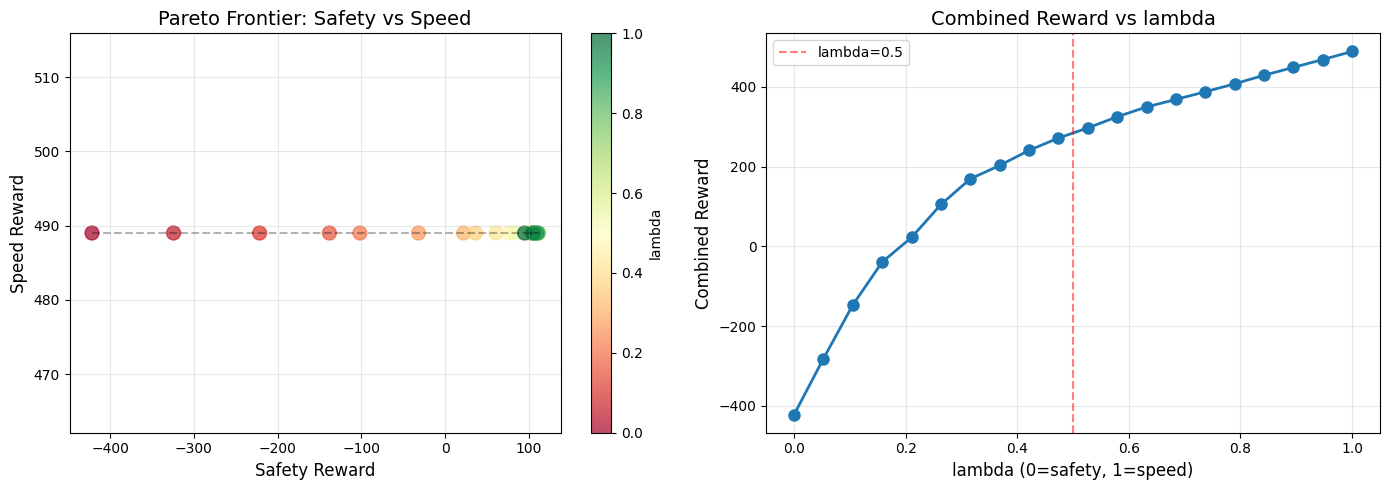


Best lambda for combined reward: 1.00
Max combined reward: 489.00


Testing adaptation to mid episode lambda changes on LunarLander-v3
  Episode 1: 100 steps, Total Reward: -47.54
  Episode 2: 165 steps, Total Reward: -16.72
  Episode 3: 465 steps, Total Reward: 180.42
  Episode 4: 112 steps, Total Reward: -46.81
  Episode 5: 261 steps, Total Reward: 111.97
Evaluating Pareto frontier on LunarLander-v3


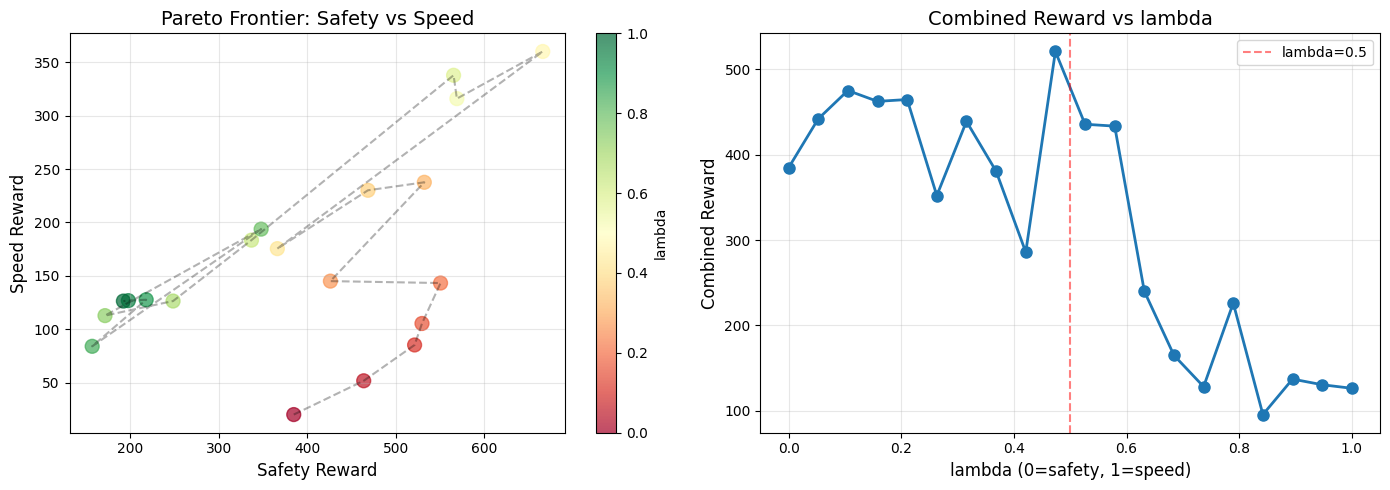


Best lambda for combined reward: 0.47
Max combined reward: 521.08


Testing adaptation to mid episode lambda changes on MountainCar-v0
  Episode 1: Switched lambda from 0.0 to 1.0 at step 100
  Episode 1: 200 steps, Total Reward: -40.79
  Episode 2: Switched lambda from 0.0 to 1.0 at step 100
  Episode 2: 200 steps, Total Reward: -36.19
  Episode 3: Switched lambda from 0.0 to 1.0 at step 100
  Episode 3: 200 steps, Total Reward: -100.08
  Episode 4: Switched lambda from 0.0 to 1.0 at step 100
  Episode 4: 200 steps, Total Reward: -100.47
  Episode 5: Switched lambda from 0.0 to 1.0 at step 100
  Episode 5: 200 steps, Total Reward: -36.30
Evaluating Pareto frontier on MountainCar-v0


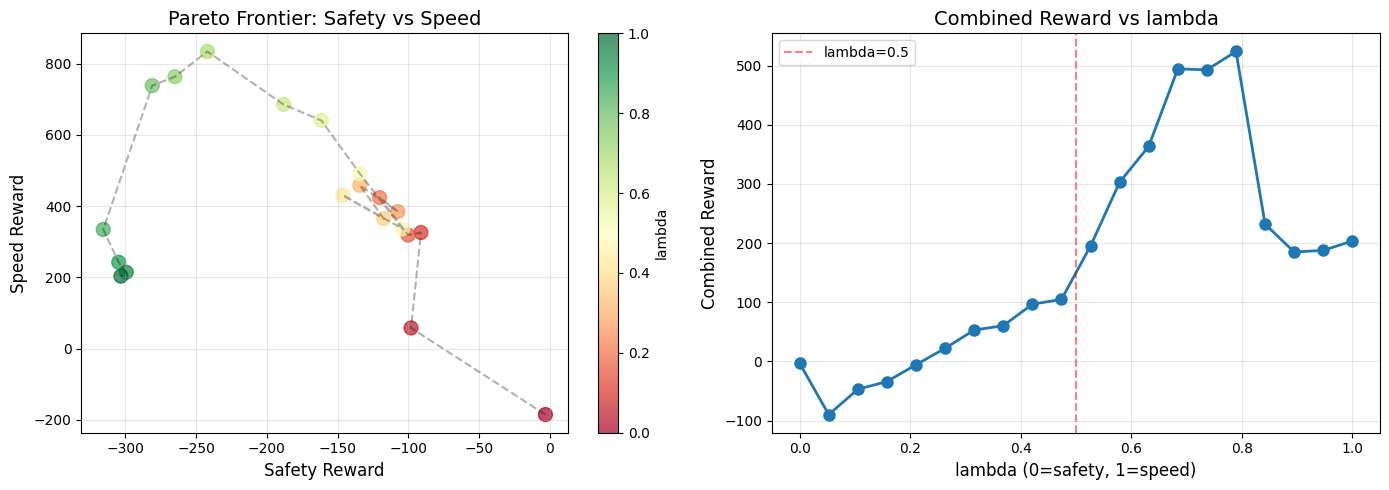


Best lambda for combined reward: 0.79
Max combined reward: 523.84


In [ ]:
# ===================== Example Usage: Demos, Pareto, Videos =====================

# CartPole interactive slider and Pareto
create_interactive_demo(lampo_cartpole, env_id_cartpole, max_steps=ENV_MAX_STEPS[env_id_cartpole])
test_adaptation(lampo_cartpole, env_id_cartpole, n_episodes=5, max_steps=ENV_MAX_STEPS[env_id_cartpole])
visualize_pareto_frontier(lampo_cartpole, env_id_cartpole, n_samples=20, max_steps=ENV_MAX_STEPS[env_id_cartpole])

# LunarLander interactive slider and Pareto (only if it trained successfully)
create_interactive_demo(lampo_lander, env_id_lander, max_steps=ENV_MAX_STEPS[env_id_lander])
test_adaptation(lampo_lander, env_id_lander, n_episodes=5, max_steps=ENV_MAX_STEPS[env_id_lander])
visualize_pareto_frontier(lampo_lander, env_id_lander, n_samples=20, max_steps=ENV_MAX_STEPS[env_id_lander])


create_interactive_demo(lampo_mountaincar, env_id_mountaincar, max_steps=200)
test_adaptation(lampo_mountaincar, env_id_mountaincar, n_episodes=5, max_steps=200)
visualize_pareto_frontier(lampo_mountaincar, env_id_mountaincar, n_samples=20, max_steps=200)


In [ ]:
record_trained_video(env_id_cartpole, lampo_cartpole, is_lampo=True,
                     lam_val=0.5, prompt="balanced",
                     video_dir="cartpole_trained_video",
                     max_steps=ENV_MAX_STEPS[env_id_cartpole])

record_trained_video(env_id_lander, lampo_lander, is_lampo=True,
                     lam_val=0.9, prompt="balanced",
                     video_dir="lunarlander_trained_video",
                     max_steps=ENV_MAX_STEPS[env_id_lander])

record_trained_video(env_id_mountaincar, lampo_mountaincar, is_lampo=True,
                     lam_val=1, prompt="risky but smooth",
                     video_dir="mountainCar_trained_video",
                     max_steps=ENV_MAX_STEPS[env_id_mountaincar])


Recorded video on CartPole-v1, steps 500, total return 451.65


Recorded video on LunarLander-v3, steps 66, total return 42.71


Recorded video on MountainCar-v0, steps 162, total return 434.64


In [ ]:
# ===================== 1. Collect trajectories per environment =====================

def collect_preference_trajectories(
    agent,
    env_id,
    lam_values,
    prompts,
    episodes_per_setting=4,
    max_steps=None,
    out_dir="pref_trajs"
):
    """
    Roll out trajectories with different lambda / prompt settings and save them.
    Works for both gym and gymnasium step APIs.
    Saves one .npz per trajectory plus a metadata.json.

    Returns:
        meta (list of dicts)
    """
    if max_steps is None:
        max_steps = ENV_MAX_STEPS.get(env_id, 500)

    os.makedirs(out_dir, exist_ok=True)
    env = make_env(env_id)

    meta = []
    traj_index = 0

    for lam_val in lam_values:
        for prompt in prompts:
            text_emb = PROMPT_EMBEDDINGS[prompt]

            for ep in range(episodes_per_setting):
                obs = env.reset()
                if isinstance(obs, tuple):
                    obs, _ = obs

                state_vec = process_observation(env_id, obs)

                done = False
                steps = 0

                states = []
                actions = []
                r_speeds = []
                r_safeties = []
                env_rewards = []

                total_combined = 0.0

                while not done and steps < max_steps:
                    action, _, _ = agent.select_action(
                        state_vec, lam_val, text_emb, deterministic=True
                    )

                    step_out = env.step(action)

                    # gymnasium: (obs, reward, terminated, truncated, info)
                    if isinstance(step_out, tuple) and len(step_out) == 5:
                        next_obs, env_reward, terminated, truncated, info = step_out
                        done = bool(terminated or truncated)
                    # gym classic: (obs, reward, done, info)
                    elif isinstance(step_out, tuple) and len(step_out) == 4:
                        next_obs, env_reward, done, info = step_out
                    else:
                        raise ValueError(
                            "Unexpected env.step return format: {}".format(step_out)
                        )

                    if isinstance(next_obs, tuple):
                        next_obs, _ = next_obs

                    next_state_vec = process_observation(env_id, next_obs)

                    combined, r_speed, r_safety = compute_rewards(
                        env_id,
                        state_vec,
                        action,
                        next_state_vec,
                        done,
                        env_reward,
                        lam_val
                    )

                    states.append(state_vec.tolist())
                    actions.append(int(action))
                    r_speeds.append(float(r_speed))
                    r_safeties.append(float(r_safety))
                    env_rewards.append(float(env_reward))
                    total_combined += combined

                    state_vec = next_state_vec
                    steps += 1

                traj_id = "{}_lam{}_{}_ep{}".format(
                    env_id,
                    round(lam_val, 2),
                    prompt.replace(" ", "_"),
                    traj_index
                )

                # this is the actual filename on disk
                traj_filename = traj_id + ".npz"
                traj_path = os.path.join(out_dir, traj_filename)

                np.savez(
                    traj_path,
                    states=np.array(states, dtype=np.float32),
                    actions=np.array(actions, dtype=np.int64),
                    r_speed=np.array(r_speeds, dtype=np.float32),
                    r_safety=np.array(r_safeties, dtype=np.float32),
                    env_rewards=np.array(env_rewards, dtype=np.float32),
                    lam=float(lam_val),
                    prompt=prompt
                )

                meta.append({
                    "traj_id": traj_id,
                    "env_id": env_id,
                    "lam": float(lam_val),
                    "prompt": prompt,
                    "num_steps": int(steps),
                    "total_combined": float(total_combined),
                    # store a relative path that you can replay directly
                    "file": os.path.join(out_dir, traj_filename)
                })

                traj_index += 1

    env.close()

    meta_path = os.path.join(out_dir, "metadata.json")
    with open(meta_path, "w") as f:
        json.dump(meta, f, indent=2)

    print("Saved {} trajectories for {} into {}".format(len(meta), env_id, out_dir))
    print("Metadata file: {}".format(meta_path))
    return meta


# ===================== 2. Build a pool of trajectories for all envs =====================

def build_trajectory_pool_for_all_envs():
    """
    Uses your trained agents to roll out trajectories for
    CartPole, LunarLander, and MountainCar.
    Produces three folders and three metadata lists.
    """

    # prompts that you already use in PROMPT_EMBEDDINGS
    default_prompts = []
    for p in ["be cautious", "go fast", "balanced"]:
        if p in PROMPT_EMBEDDINGS:
            default_prompts.append(p)
    if len(default_prompts) == 0:
        default_prompts = list(PROMPT_EMBEDDINGS.keys())[:3]

    lam_values = [0.0, 0.25, 0.5, 0.75, 1.0]

    print("Using prompts for preference data:", default_prompts)
    print("Using lambda values:", lam_values)

    # CartPole trajectories
    meta_cartpole = collect_preference_trajectories(
        lampo_cartpole,
        env_id_cartpole,
        lam_values=lam_values,
        prompts=default_prompts,
        episodes_per_setting=4,
        max_steps=ENV_MAX_STEPS[env_id_cartpole],
        out_dir="pref_traj_cartpole"    # matches /content/pref_traj_cartpole/...
    )

    # LunarLander trajectories
    meta_lander = collect_preference_trajectories(
        lampo_lander,
        env_id_lander,
        lam_values=lam_values,
        prompts=default_prompts,
        episodes_per_setting=4,
        max_steps=ENV_MAX_STEPS[env_id_lander],
        out_dir="pref_traj_lander"      # matches /content/pref_traj_lander/...
    )

    # MountainCar trajectories
    meta_mountaincar = collect_preference_trajectories(
        lampo_mountaincar,
        env_id_mountaincar,
        lam_values=lam_values,
        prompts=default_prompts,
        episodes_per_setting=4,
        max_steps=ENV_MAX_STEPS[env_id_mountaincar],
        out_dir="pref_traj_mountaincar" # matches /content/pref_traj_mountaincar/...
    )

    all_meta = {
        env_id_cartpole: meta_cartpole,
        env_id_lander: meta_lander,
        env_id_mountaincar: meta_mountaincar
    }

    with open("all_preference_metadata.json", "w") as f:
        json.dump(all_meta, f, indent=2)

    print("Combined metadata saved to all_preference_metadata.json")
    return all_meta


# ===================== 3. Build a single human_preferences.csv =====================

def build_pairwise_preference_csv(
    all_meta,
    csv_path="human_preferences.csv",
    total_pairs_target=200,
    per_env_ratio=None
):
    """
    Given metadata for each environment, build a CSV of pairwise comparisons
    to be labeled by humans later.

    This version writes absolute paths that start with /content/ directly
    into the CSV, so no later path fixing is needed.
    """

    env_ids = list(all_meta.keys())
    if per_env_ratio is None:
        per_env_ratio = {env_id: 1.0 / len(env_ids) for env_id in env_ids}

    per_env_target = {
        env_id: int(total_pairs_target * per_env_ratio[env_id])
        for env_id in env_ids
    }

    pairs_rows = []
    pair_counter = 0

    for env_id in env_ids:
        meta = all_meta[env_id]
        n = len(meta)
        if n < 2:
            continue

        indices = list(range(n))
        all_pairs = [(i, j) for i in indices for j in indices if i < j]
        random.shuffle(all_pairs)

        target = min(per_env_target[env_id], len(all_pairs))

        for k in range(target):
            i, j = all_pairs[k]
            traj_a = meta[i]
            traj_b = meta[j]

            # Build absolute paths like /content/pref_traj_cartpole/...
            traj_a_path = traj_a["file"]
            traj_b_path = traj_b["file"]

            traj_a_path = "/content/" + str(traj_a_path).lstrip("/")
            traj_b_path = "/content/" + str(traj_b_path).lstrip("/")

            row = {
                "pair_id": "PAIR_{:03d}".format(pair_counter),
                "env_id": env_id,

                "traj_a_id": traj_a["traj_id"],
                "traj_a_file": traj_a_path,
                "lam_a": traj_a["lam"],
                "prompt_a": traj_a["prompt"],
                "steps_a": traj_a["num_steps"],
                "total_return_a": traj_a["total_combined"],

                "traj_b_id": traj_b["traj_id"],
                "traj_b_file": traj_b_path,
                "lam_b": traj_b["lam"],
                "prompt_b": traj_b["prompt"],
                "steps_b": traj_b["num_steps"],
                "total_return_b": traj_b["total_combined"],

                "annotator": "",
                "preferred_traj": "",
                "safer_traj": "",
                "faster_traj": "",
                "notes": ""
            }

            pairs_rows.append(row)
            pair_counter += 1

    fieldnames = [
        "pair_id",
        "env_id",
        "traj_a_id",
        "traj_a_file",
        "lam_a",
        "prompt_a",
        "steps_a",
        "total_return_a",
        "traj_b_id",
        "traj_b_file",
        "lam_b",
        "prompt_b",
        "steps_b",
        "total_return_b",
        "annotator",
        "preferred_traj",
        "safer_traj",
        "faster_traj",
        "notes"
    ]

    with open(csv_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for row in pairs_rows:
            writer.writerow(row)

    print("Wrote {} pairwise comparisons to {}".format(len(pairs_rows), csv_path))


# ===================== 4. Optional helper to replay a trajectory interactively =====================

def replay_trajectory_from_npz(traj_file, env_id, sleep_time=0.03):
    """
    Simple viewer to step through a saved trajectory and render it.

    Note:
        This does not reproduce environment dynamics exactly because we only
        saved state vectors and actions, not full env state. It is still
        useful as a rough visual clip.
    """
    # Load trajectory data
    data = np.load(traj_file, allow_pickle=True)
    actions = data["actions"]

    # Create environment in rgb_array render mode
    env = make_env(env_id, render_mode="rgb_array")

    # Reset environment, handle both gym and gymnasium
    obs = env.reset()
    if isinstance(obs, tuple):
        obs, _ = obs

    plt.figure(figsize=(4, 4))

    done = False
    step_idx = 0

    for a in actions:
        if done:
            break

        # Step environment
        step_out = env.step(int(a))

        # Gymnasium: (obs, reward, terminated, truncated, info)
        if isinstance(step_out, tuple) and len(step_out) == 5:
            obs, rew, terminated, truncated, info = step_out
            done = bool(terminated or truncated)
        # Classic gym: (obs, reward, done, info)
        else:
            obs, rew, done, info = step_out

        # Render frame
        frame = env.render()
        if isinstance(frame, dict) and "rgb_array" in frame:
            frame = frame["rgb_array"]

        # Display frame
        plt.clf()
        plt.imshow(frame)
        plt.axis("off")
        plt.title("Step {}".format(step_idx))

        ipy_display(plt.gcf())
        ipy_clear_output(wait=True)

        time.sleep(sleep_time)
        step_idx += 1

    env.close()
    plt.close()



# ===================== 5. Run once to create trajectories and CSV =====================

all_meta = build_trajectory_pool_for_all_envs()

build_pairwise_preference_csv(
    all_meta,
    csv_path="human_preferences.csv",
    total_pairs_target=198
)

print("Preference trajectory generation complete.")


Using prompts for preference data: ['be cautious', 'go fast', 'balanced']
Using lambda values: [0.0, 0.25, 0.5, 0.75, 1.0]
Saved 60 trajectories for CartPole-v1 into pref_traj_cartpole
Metadata file: pref_traj_cartpole/metadata.json
Saved 60 trajectories for LunarLander-v3 into pref_traj_lander
Metadata file: pref_traj_lander/metadata.json
Saved 60 trajectories for MountainCar-v0 into pref_traj_mountaincar
Metadata file: pref_traj_mountaincar/metadata.json
Combined metadata saved to all_preference_metadata.json
Wrote 198 pairwise comparisons to human_preferences.csv
Preference trajectory generation complete.


In [ ]:
def get_rgb_frame(env):
    frame = env.render()
    if isinstance(frame, dict) and "rgb_array" in frame:
        frame = frame["rgb_array"]
    return frame

def replay_pair_side_by_side(prefs_df, pair_id, sleep_time=0.03, frame_skip=1):
    # Get the row for this pair
    row = prefs_df.loc[prefs_df["pair_id"] == pair_id].iloc[0]

    traj_a_path = row["traj_a_file"]
    traj_b_path = row["traj_b_file"]

    print("Loading trajectories from {} and {}".format(traj_a_path, traj_b_path))
    env_id = row["env_id"]

    # Load saved actions
    data_a = np.load(traj_a_path, allow_pickle=True)
    data_b = np.load(traj_b_path, allow_pickle=True)

    actions_a = data_a["actions"]
    actions_b = data_b["actions"]

    # Create two separate environments with rgb_array render
    env_a = make_env(env_id, render_mode="rgb_array")
    env_b = make_env(env_id, render_mode="rgb_array")

    obs_a = env_a.reset()
    obs_b = env_b.reset()
    if isinstance(obs_a, tuple):
        obs_a, _ = obs_a
    if isinstance(obs_b, tuple):
        obs_b, _ = obs_b

    done_a = False
    done_b = False

    # Initial frames
    frame_a = get_rgb_frame(env_a)
    frame_b = get_rgb_frame(env_b)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    img_a = axes[0].imshow(frame_a)
    axes[0].set_title(pair_id + " A")
    axes[0].axis("off")

    img_b = axes[1].imshow(frame_b)
    axes[1].set_title(pair_id + " B")
    axes[1].axis("off")

    fig.tight_layout()

    max_steps = max(len(actions_a), len(actions_b))

    for t in range(max_steps):
        # Step env A
        if (not done_a) and t < len(actions_a):
            step_out_a = env_a.step(int(actions_a[t]))
            if isinstance(step_out_a, tuple) and len(step_out_a) == 5:
                obs_a, rew_a, term_a, trunc_a, info_a = step_out_a
                done_a = bool(term_a or trunc_a)
            else:
                obs_a, rew_a, done_a, info_a = step_out_a

        # Step env B
        if (not done_b) and t < len(actions_b):
            step_out_b = env_b.step(int(actions_b[t]))
            if isinstance(step_out_b, tuple) and len(step_out_b) == 5:
                obs_b, rew_b, term_b, trunc_b, info_b = step_out_b
                done_b = bool(term_b or trunc_b)
            else:
                obs_b, rew_b, done_b, info_b = step_out_b

        if t % frame_skip == 0 or t == max_steps - 1:
            frame_a = get_rgb_frame(env_a)
            frame_b = get_rgb_frame(env_b)

            img_a.set_data(frame_a)
            img_b.set_data(frame_b)

            # This is the key part for Colab / inline backends
            ipy_clear_output(wait=True)
            ipy_display(fig)

            time.sleep(sleep_time)

        if done_a and done_b:
            break

    plt.close(fig)
    env_a.close()
    env_b.close()

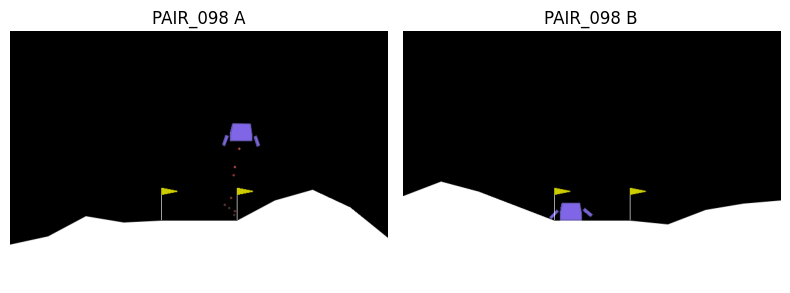

In [ ]:

prefs = pd.read_csv("/content/human_preferences.csv")

replay_pair_side_by_side(prefs, "PAIR_098", sleep_time=0.02, frame_skip=2)



In [ ]:
# ===================== Snippet 1: RLHF utilities, reward model, analysis =====================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



class RLHFTrainer:
    """
    RLHF trainer that fine tunes the existing LAMPO agent with PPO
    driven by a blend of env reward and the human shaped combined reward.
    """

    def __init__(self,
                 agent,
                 reward_model,
                 env_id,
                 lr=1e-5,
                 kl_coef=0.1,
                 reward_scale=1.0):
        self.agent = agent
        self.reward_model = reward_model
        self.env_id = env_id
        self.lr = lr
        self.kl_coef = kl_coef
        self.reward_scale = reward_scale

    def fine_tune(
        self,
        n_episodes=300,
        batch_size=1024,
        eval_freq=50,
        use_env_reward=True,   # kept for signature compatibility, not used
        reward_blend=0.5
    ):
        """
        PPO fine tuning of the existing LAMPO agent using a blend of:
          step_reward = reward_blend * combined + (1 - reward_blend) * env_reward

        reward_blend = 1.0  -> pure human shaped combined reward
        reward_blend = 0.5  -> equal blend
        reward_blend = 0.0  -> pure env reward
        """

        # Pull PPO hyperparameters from the agent
        agent_gamma = getattr(self.agent, "gamma", 0.99)
        agent_lam = getattr(self.agent, "lam", 0.95)
        clip_eps = getattr(self.agent, "clip_epsilon", 0.2)
        value_coef = getattr(self.agent, "value_coef", 0.5)
        entropy_coef = getattr(self.agent, "entropy_coef", 0.01)
        ppo_epochs = getattr(self.agent, "ppo_epochs", 10)
        minibatch_size = getattr(self.agent, "minibatch_size", 64)

        max_steps = ENV_MAX_STEPS.get(self.env_id, 500)
        env = make_env(self.env_id)

        episode = 0
        total_steps = 0
        best_eval_reward = -float("inf")

        train_rewards_history = []
        eval_rewards_history = []

        print("RLHFTrainer: starting fine_tune on {}".format(self.env_id))
        print("   Target episodes: {}, batch_size: {}".format(n_episodes, batch_size))

        while episode < n_episodes:
            # Rollout storage for one PPO batch
            batch_states = []
            batch_actions = []
            batch_log_probs = []
            batch_rewards = []
            batch_dones = []
            batch_values = []
            batch_lams = []
            batch_text_embs = []

            batch_episode_rewards = []
            steps_collected = 0

            # ------------- collect one PPO batch -------------
            while steps_collected < batch_size and episode < n_episodes:
                lam_val = 0.5
                prompt = "balanced"
                text_emb = PROMPT_EMBEDDINGS[prompt]

                obs = safe_reset(env)
                state_vec = process_observation(self.env_id, obs)

                done = False
                ep_return = 0.0
                steps = 0

                while (not done) and steps < max_steps and steps_collected < batch_size:
                    action, log_prob, value = self.agent.select_action(
                        state_vec,
                        lam_val,
                        text_emb,
                        deterministic=False
                    )

                    next_obs, env_reward, done, info = safe_step(env, action)
                    next_state_vec = process_observation(self.env_id, next_obs)

                    combined, r_speed, r_safety = compute_rewards(
                        self.env_id,
                        state_vec,
                        action,
                        next_state_vec,
                        done,
                        env_reward,
                        lam_val
                    )

                    # Blend env reward and human shaped reward
                    step_reward = reward_blend * combined + (1.0 - reward_blend) * env_reward

                    batch_states.append(state_vec)
                    batch_actions.append(action)
                    batch_log_probs.append(log_prob)
                    batch_rewards.append(step_reward)
                    batch_dones.append(done)
                    batch_values.append(value)
                    batch_lams.append(lam_val)
                    batch_text_embs.append(text_emb)

                    ep_return += step_reward
                    state_vec = next_state_vec

                    steps += 1
                    steps_collected += 1
                    total_steps += 1

                batch_episode_rewards.append(ep_return)
                episode += 1

            # ------------- PPO update on this batch -------------
            rewards_np = np.array(batch_rewards, dtype=np.float32)
            values_np = np.array(batch_values, dtype=np.float32)
            dones_np = np.array(batch_dones, dtype=np.bool_)

            advantages = np.zeros_like(rewards_np)
            last_gae = 0.0

            for t in reversed(range(len(rewards_np))):
                if t == len(rewards_np) - 1:
                    next_value = 0.0
                else:
                    next_value = values_np[t + 1]

                if dones_np[t]:
                    next_value = 0.0
                    last_gae = 0.0

                delta = rewards_np[t] + agent_gamma * next_value - values_np[t]
                last_gae = delta + agent_gamma * agent_lam * last_gae
                advantages[t] = last_gae

            returns_np = advantages + values_np

            states = torch.FloatTensor(np.array(batch_states)).to(device)
            actions = torch.LongTensor(np.array(batch_actions)).to(device)
            old_log_probs = torch.FloatTensor(np.array(batch_log_probs)).to(device)
            lambdas_tensor = torch.FloatTensor(np.array(batch_lams)).unsqueeze(-1).to(device)
            text_embs_tensor = torch.FloatTensor(np.array(batch_text_embs)).to(device)

            returns_tensor = torch.FloatTensor(returns_np).to(device)
            advantages_tensor = torch.FloatTensor(advantages).to(device)
            advantages_tensor = (advantages_tensor - advantages_tensor.mean()) / (
                advantages_tensor.std() + 1e-8
            )

            total_policy_loss = 0.0
            total_value_loss = 0.0
            n_updates = 0

            for _ in range(ppo_epochs):
                indices = np.arange(len(states))
                np.random.shuffle(indices)

                for start in range(0, len(states), minibatch_size):
                    end = start + minibatch_size
                    mb_idx = indices[start:end]

                    mb_states = states[mb_idx]
                    mb_actions = actions[mb_idx]
                    mb_old_log_probs = old_log_probs[mb_idx]
                    mb_advantages = advantages_tensor[mb_idx]
                    mb_returns = returns_tensor[mb_idx]
                    mb_lambdas = lambdas_tensor[mb_idx]
                    mb_text = text_embs_tensor[mb_idx]

                    log_probs, entropy = self.agent.policy.evaluate(
                        mb_states,
                        mb_lambdas,
                        mb_text,
                        mb_actions
                    )
                    values = self.agent.value(mb_states, mb_lambdas, mb_text)

                    ratio = torch.exp(log_probs - mb_old_log_probs)
                    surr1 = ratio * mb_advantages
                    surr2 = torch.clamp(
                        ratio,
                        1.0 - clip_eps,
                        1.0 + clip_eps
                    ) * mb_advantages

                    policy_loss = -torch.min(surr1, surr2).mean()
                    value_loss = F.mse_loss(values, mb_returns)
                    entropy_loss = -entropy.mean()

                    loss = policy_loss + value_coef * value_loss + entropy_coef * entropy_loss

                    self.agent.policy_optimizer.zero_grad()
                    self.agent.value_optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.agent.policy.parameters(), 0.5)
                    torch.nn.utils.clip_grad_norm_(self.agent.value.parameters(), 0.5)
                    self.agent.policy_optimizer.step()
                    self.agent.value_optimizer.step()

                    total_policy_loss += policy_loss.item()
                    total_value_loss += value_loss.item()
                    n_updates += 1

            avg_train_reward = float(np.mean(batch_episode_rewards))
            avg_policy_loss = total_policy_loss / float(max(n_updates, 1))
            avg_value_loss = total_value_loss / float(max(n_updates, 1))

            train_rewards_history.append(avg_train_reward)

            # ------------- periodic evaluation on pure env reward -------------
            if episode % eval_freq == 0:
                eval_env_reward = evaluate_lampo(
                    self.agent,
                    self.env_id,
                    lam_val=0.5,
                    text_emb=PROMPT_EMBEDDINGS["balanced"],
                    n_rollouts=10,
                    max_steps=max_steps
                )

                eval_rewards_history.append(eval_env_reward)

                print(
                    "   [Episode {}/{}] train_reward={:.2f}, eval_env_reward={:.2f}, "
                    "policy_loss={:.3f}, value_loss={:.3f}".format(
                        episode,
                        n_episodes,
                        avg_train_reward,
                        eval_env_reward,
                        avg_policy_loss,
                        avg_value_loss
                    )
                )

                if eval_env_reward > best_eval_reward:
                    best_eval_reward = eval_env_reward
                    torch.save(
                        self.agent.policy.state_dict(),
                        "lampo_{}_rlhf_policy.pth".format(self.env_id)
                    )
                    torch.save(
                        self.agent.value.state_dict(),
                        "lampo_{}_rlhf_value.pth".format(self.env_id)
                    )

        env.close()
        print("RLHFTrainer: finished fine_tune on {}".format(self.env_id))
        return train_rewards_history, eval_rewards_history


# ===================== PreferenceDataset =====================

class PreferenceDataset(Dataset):
    """
    Dataset for human preference pairs.

    Expects a CSV with at least:
        env_id, preferred_traj, lam_a, lam_b,
        steps_a, steps_b, total_return_a, total_return_b

    Builds feature vectors of size 16 for traj A and traj B.
    Labels:
        A   -> 1.0
        B   -> 0.0
        tie -> 0.5
    """
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df["preferred_traj"].isin(["A", "B", "tie"])]

        feats_a = []
        feats_b = []
        labels = []

        for _, row in self.df.iterrows():
            feats_a.append(self._build_features(row, which="a"))
            feats_b.append(self._build_features(row, which="b"))

            if row["preferred_traj"] == "A":
                label_val = 1.0
            elif row["preferred_traj"] == "B":
                label_val = 0.0
            else:
                label_val = 0.5
            labels.append(label_val)

        self.traj_a = torch.tensor(np.stack(feats_a), dtype=torch.float32)
        self.traj_b = torch.tensor(np.stack(feats_b), dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def _build_features(self, row, which):
        if which == "a":
            lam = float(row["lam_a"])
            steps = float(row["steps_a"])
            ret = float(row["total_return_a"])
        else:
            lam = float(row["lam_b"])
            steps = float(row["steps_b"])
            ret = float(row["total_return_b"])

        feat = np.zeros(16, dtype=np.float32)

        feat[0] = lam
        feat[1] = steps
        feat[2] = ret
        feat[3] = lam * ret
        feat[4] = lam * steps
        feat[5] = ret / float(max(abs(steps), 1.0))
        feat[6] = (lam - 0.5) * (lam - 0.5)
        feat[7] = 1.0 if ret > 0.0 else 0.0
        feat[8] = ret / 500.0
        feat[9] = steps / 500.0
        feat[10] = lam * lam
        feat[11] = np.sign(ret)
        feat[12] = np.sign(steps)
        feat[13] = (ret / float(max(abs(steps), 1.0))) * lam
        # feat[14], feat[15] remain zero
        return feat

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return {
            "traj_a": self.traj_a[idx],
            "traj_b": self.traj_b[idx],
            "label": self.labels[idx],
            "env_id": self.df.iloc[idx]["env_id"],
        }


# ===================== Reward model =====================

class RewardNet(nn.Module):
    """
    Simple preference reward model.

    Given embeddings for traj A and B, it computes scalar rewards and
    uses their difference to model preference.
    """
    def __init__(self, input_dim, hidden_dim=64):
        super(RewardNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        return self.net(x)

    def preference_logits(self, emb_a, emb_b):
        r_a = self.forward(emb_a)
        r_b = self.forward(emb_b)
        return r_a - r_b

    def predict_preference(self, emb_a, emb_b):
        logits = self.preference_logits(emb_a, emb_b)
        probs = torch.sigmoid(logits)
        return probs.squeeze(-1)


# ===================== train_reward_model =====================

def train_reward_model(csv_path, n_epochs=50, batch_size=16, lr=1e-3):
    """
    Train RewardNet on human preferences using PreferenceDataset.

    Ties (label 0.5) are kept in the dataset but ignored in the loss.
    """
    dataset = PreferenceDataset(csv_path)

    if len(dataset) == 0:
        print("No labeled preferences found in {}".format(csv_path))
        return None

    input_dim = dataset.traj_a.shape[1]
    print("==================================================")
    print("Training Reward Model on Human Preferences")
    print("==================================================")
    print("Loaded {} labeled preference pairs from {}".format(len(dataset), csv_path))
    print("Input dimension: {}".format(input_dim))
    print("Training samples: {}".format(len(dataset)))

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    reward_model = RewardNet(input_dim=input_dim).to(device)
    optimizer = torch.optim.Adam(reward_model.parameters(), lr=lr)
    bce = nn.BCEWithLogitsLoss(reduction="none")

    best_loss = float("inf")
    best_state = None

    for epoch in range(1, n_epochs + 1):
        reward_model.train()
        running_loss = 0.0
        total_weight = 0.0

        for batch in loader:
            emb_a = batch["traj_a"].to(device)
            emb_b = batch["traj_b"].to(device)
            labels = batch["label"].to(device)

            mask = labels != 0.5
            if mask.sum().item() == 0:
                continue

            logits = reward_model.preference_logits(emb_a, emb_b).squeeze(-1)
            logits_masked = logits[mask]
            targets = labels[mask]

            loss_vec = bce(logits_masked, targets)
            loss = loss_vec.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * float(mask.sum().item())
            total_weight += float(mask.sum().item())

        if total_weight > 0.0:
            avg_loss = running_loss / total_weight
        else:
            avg_loss = float("inf")

        if epoch % 10 == 0:
            print("Epoch {}/{} | Loss: {:.4f}".format(epoch, n_epochs, avg_loss))

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_state = copy.deepcopy(reward_model.state_dict())

    if best_state is not None:
        reward_model.load_state_dict(best_state)
        torch.save(reward_model.state_dict(), "reward_model_best.pth")
        print("")
        print("Best loss: {:.4f}".format(best_loss))
        print("Saved best model to reward_model_best.pth")

    return reward_model


# ===================== 1. Preference analysis =====================

def detailed_preference_analysis(csv_path="human_preferences_complete.csv",
                                 env_filter=None,
                                 save_prefix=""):
    """
    Comprehensive analysis of collected human preferences for project report.
    """
    df = pd.read_csv(csv_path)

    labeled = df[df["preferred_traj"].notna()]
    labeled = labeled[labeled["preferred_traj"].isin(["A", "B", "tie"])]

    if env_filter is not None:
        labeled = labeled[labeled["env_id"] == env_filter]
        title_suffix = " - {}".format(env_filter)
    else:
        title_suffix = " - All Environments"

    print("=" * 70)
    print("HUMAN PREFERENCE DATA ANALYSIS{}".format(title_suffix))
    print("=" * 70)

    print("\nDataset Statistics:")
    total_pairs = len(df)
    labeled_pairs = len(labeled)
    labeled_rate = labeled_pairs / float(max(total_pairs, 1)) * 100.0
    print("   Total pairs collected: {}".format(total_pairs))
    print("   Labeled pairs: {} ({:.1f}%)".format(labeled_pairs, labeled_rate))
    print("   Unlabeled pairs: {}".format(total_pairs - labeled_pairs))

    if len(labeled) == 0:
        print("\nWARNING: No labeled preferences yet. Please label the CSV first.")
        return None

    if "annotator" in labeled.columns:
        annotators = labeled["annotator"].dropna().unique()
        print("\nAnnotators: {}".format(len(annotators)))
        for ann in annotators:
            count = len(labeled[labeled["annotator"] == ann])
            print("   {}: {} labels".format(ann, count))

    pref_counts = labeled["preferred_traj"].value_counts()
    print("\nOverall Preference Distribution:")
    for pref, count in pref_counts.items():
        bar = "#" * int(count / float(len(labeled)) * 30)
        percent = count / float(len(labeled)) * 100.0
        print("   {}: {:3d} ({:5.1f}%) {}".format(pref, count, percent, bar))

    print("\nBy Environment:")
    env_stats = {}
    for env_id in labeled["env_id"].unique():
        env_df = labeled[labeled["env_id"] == env_id]
        env_prefs = env_df["preferred_traj"].value_counts()
        env_stats[env_id] = {
            "total": len(env_df),
            "A": env_prefs.get("A", 0),
            "B": env_prefs.get("B", 0),
            "tie": env_prefs.get("tie", 0),
        }
        print("   {}:".format(env_id))
        print(
            "      Total: {} | A: {} | B: {} | Tie: {}".format(
                len(env_df),
                env_prefs.get("A", 0),
                env_prefs.get("B", 0),
                env_prefs.get("tie", 0),
            )
        )

    print("\nLambda Correlation Analysis:")
    a_preferred = labeled[labeled["preferred_traj"] == "A"]
    b_preferred = labeled[labeled["preferred_traj"] == "B"]

    if len(a_preferred) > 0:
        avg_lam_diff_a = (a_preferred["lam_a"] - a_preferred["lam_b"]).mean()
        print("   When A preferred: avg(lambda_A - lambda_B) = {:+.3f}".format(avg_lam_diff_a))
    if len(b_preferred) > 0:
        avg_lam_diff_b = (b_preferred["lam_a"] - b_preferred["lam_b"]).mean()
        print("   When B preferred: avg(lambda_A - lambda_B) = {:+.3f}".format(avg_lam_diff_b))

    print("\nInterpretation:")
    if len(a_preferred) > 0:
        overall_a_lam = a_preferred["lam_a"].mean()
    else:
        overall_a_lam = 0.0
    if len(b_preferred) > 0:
        overall_b_lam = b_preferred["lam_b"].mean()
    else:
        overall_b_lam = 0.0

    if overall_a_lam > overall_b_lam:
        print("   -> Annotators tend to prefer faster (higher lambda) trajectories")
    elif overall_a_lam < overall_b_lam:
        print("   -> Annotators tend to prefer safer (lower lambda) trajectories")
    else:
        print("   -> No clear speed or safety preference bias detected")

    if "safer_traj" in labeled.columns and "faster_traj" in labeled.columns:
        safer = labeled[labeled["safer_traj"].isin(["A", "B"])]
        faster = labeled[labeled["faster_traj"].isin(["A", "B"])]

        if len(safer) > 0:
            print("\nSafety Labels ({} labeled):".format(len(safer)))
            print("   {}".format(safer["safer_traj"].value_counts().to_dict()))
        if len(faster) > 0:
            print("Speed Labels ({} labeled):".format(len(faster)))
            print("   {}".format(faster["faster_traj"].value_counts().to_dict()))

    fig = plt.figure(figsize=(16, 10))
    fig.suptitle(
        "Human Preference Analysis{}".format(title_suffix),
        fontsize=14,
        fontweight="bold",
    )

    ax1 = fig.add_subplot(2, 3, 1)
    colors = {"A": "#27ae60", "B": "#e74c3c", "tie": "#95a5a6"}
    pref_counts.plot.pie(
        ax=ax1,
        autopct="%1.1f%%",
        colors=[colors.get(x, "#333333") for x in pref_counts.index],
        explode=[0.02] * len(pref_counts),
    )
    ax1.set_title("Overall Preference Distribution", fontsize=12, fontweight="bold")
    ax1.set_ylabel("")

    ax2 = fig.add_subplot(2, 3, 2)
    env_df_plot = pd.DataFrame(env_stats).T
    if len(env_df_plot) > 0:
        env_df_plot[["A", "B", "tie"]].plot.bar(
            ax=ax2,
            stacked=True,
            color=["#27ae60", "#e74c3c", "#95a5a6"],
        )
    ax2.set_title("Preferences by Environment", fontsize=12, fontweight="bold")
    ax2.set_xlabel("Environment")
    ax2.set_ylabel("Count")
    ax2.legend(title="Preferred")
    ax2.tick_params(axis="x", rotation=45)

    ax3 = fig.add_subplot(2, 3, 3)
    color_map = {"A": "#27ae60", "B": "#e74c3c", "tie": "#95a5a6"}
    for pref in ["A", "B", "tie"]:
        subset = labeled[labeled["preferred_traj"] == pref]
        ax3.scatter(
            subset["lam_a"],
            subset["lam_b"],
            c=color_map[pref],
            label=pref,
            alpha=0.6,
            s=60,
            edgecolors="white",
        )
    ax3.plot([0, 1], [0, 1], "k--", alpha=0.3, label="Equal lambda")
    ax3.set_xlabel("Lambda A (trajectory)")
    ax3.set_ylabel("Lambda B (trajectory)")
    ax3.set_title("Lambda Values vs Preference", fontsize=12, fontweight="bold")
    ax3.legend()
    ax3.set_xlim(-0.05, 1.05)
    ax3.set_ylim(-0.05, 1.05)
    ax3.grid(True, alpha=0.3)

    ax4 = fig.add_subplot(2, 3, 4)
    labeled = labeled.copy()
    labeled["return_diff"] = labeled["total_return_a"] - labeled["total_return_b"]
    for pref in ["A", "B"]:
        subset = labeled[labeled["preferred_traj"] == pref]
        ax4.hist(
            subset["return_diff"],
            bins=20,
            alpha=0.5,
            label="{} preferred".format(pref),
            color=color_map[pref],
        )
    ax4.axvline(x=0, color="black", linestyle="--", alpha=0.5)
    ax4.set_xlabel("Return(A) - Return(B)")
    ax4.set_ylabel("Count")
    ax4.set_title("Return Difference Distribution", fontsize=12, fontweight="bold")
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    ax5 = fig.add_subplot(2, 3, 5)
    labeled["steps_diff"] = labeled["steps_a"] - labeled["steps_b"]
    for pref in ["A", "B"]:
        subset = labeled[labeled["preferred_traj"] == pref]
        ax5.hist(
            subset["steps_diff"],
            bins=20,
            alpha=0.5,
            label="{} preferred".format(pref),
            color=color_map[pref],
        )
    ax5.axvline(x=0, color="black", linestyle="--", alpha=0.5)
    ax5.set_xlabel("Steps(A) - Steps(B)")
    ax5.set_ylabel("Count")
    ax5.set_title("Episode Length Difference", fontsize=12, fontweight="bold")
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    ax6 = fig.add_subplot(2, 3, 6)
    labeled["avg_lambda"] = (labeled["lam_a"] + labeled["lam_b"]) / 2.0
    labeled["lambda_bin"] = pd.cut(
        labeled["avg_lambda"],
        bins=[0.0, 0.33, 0.66, 1.0],
        labels=["Low (0-0.33)", "Mid (0.33-0.66)", "High (0.66-1.0)"],
    )
    lambda_pref = labeled.groupby(
        ["lambda_bin", "preferred_traj"]
    ).size().unstack(fill_value=0)
    if len(lambda_pref) > 0:
        lambda_pref.plot.bar(
            ax=ax6,
            color=["#27ae60", "#e74c3c", "#95a5a6"],
        )
    ax6.set_title("Preference by Lambda Range", fontsize=12, fontweight="bold")
    ax6.set_xlabel("Average Lambda Range")
    ax6.set_ylabel("Count")
    ax6.tick_params(axis="x", rotation=45)
    ax6.legend(title="Preferred")

    plt.tight_layout()

    if save_prefix:
        filename = "{}preference_analysis.png".format(save_prefix)
    else:
        filename = "preference_analysis.png"
    plt.savefig(filename, dpi=150, bbox_inches="tight")
    plt.show()

    print("\nSaved visualization to '{}'".format(filename))

    return labeled


# ===================== 2. Before and After RLHF Comparison =====================

def compare_before_after_rlhf(agent_before, agent_after, env_id,
                              max_steps=None, n_samples=20):
    """
    Compare agent performance before and after RLHF fine tuning.
    """
    if max_steps is None:
        max_steps = ENV_MAX_STEPS.get(env_id, 500)

    print("\n{}".format("=" * 70))
    print("BEFORE vs AFTER RLHF COMPARISON: {}".format(env_id))
    print("{}".format("=" * 70))

    lambda_values = np.linspace(0.0, 1.0, n_samples)

    results = {
        "before": {"speed": [], "safety": [], "combined": [], "env_reward": []},
        "after": {"speed": [], "safety": [], "combined": [], "env_reward": []},
    }

    env = make_env(env_id)

    for label, agent in [("before", agent_before), ("after", agent_after)]:
        print("\nEvaluating {} RLHF agent...".format(label.upper()))

        for lam_val in lambda_values:
            text_emb = PROMPT_EMBEDDINGS["balanced"]

            ep_speeds = []
            ep_safeties = []
            ep_combined = []
            ep_env = []

            for _ in range(5):
                obs = safe_reset(env)
                state_vec = process_observation(env_id, obs)

                done = False
                ep_speed = 0.0
                ep_safety = 0.0
                ep_comb = 0.0
                ep_rew = 0.0
                steps = 0

                while (not done) and steps < max_steps:
                    action, _, _ = agent.select_action(
                        state_vec, lam_val, text_emb, deterministic=True
                    )
                    next_obs, env_reward, done, info = safe_step(env, action)
                    next_state_vec = process_observation(env_id, next_obs)

                    combined, r_speed, r_safety = compute_rewards(
                        env_id,
                        state_vec,
                        action,
                        next_state_vec,
                        done,
                        env_reward,
                        lam_val,
                    )

                    ep_speed += r_speed
                    ep_safety += r_safety
                    ep_comb += combined
                    ep_rew += env_reward
                    state_vec = next_state_vec
                    steps += 1

                ep_speeds.append(ep_speed)
                ep_safeties.append(ep_safety)
                ep_combined.append(ep_comb)
                ep_env.append(ep_rew)

            results[label]["speed"].append(np.mean(ep_speeds))
            results[label]["safety"].append(np.mean(ep_safeties))
            results[label]["combined"].append(np.mean(ep_combined))
            results[label]["env_reward"].append(np.mean(ep_env))

    env.close()

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle(
        "RLHF Before and After Comparison - {}".format(env_id),
        fontsize=14,
        fontweight="bold",
    )

    ax1 = axes[0, 0]
    ax1.scatter(
        results["before"]["safety"],
        results["before"]["speed"],
        c=lambda_values,
        cmap="Blues",
        s=80,
        alpha=0.7,
        label="Before RLHF",
        marker="o",
    )
    ax1.scatter(
        results["after"]["safety"],
        results["after"]["speed"],
        c=lambda_values,
        cmap="Reds",
        s=80,
        alpha=0.7,
        label="After RLHF",
        marker="^",
    )
    ax1.plot(results["before"]["safety"], results["before"]["speed"], "b--", alpha=0.3)
    ax1.plot(results["after"]["safety"], results["after"]["speed"], "r--", alpha=0.3)
    ax1.set_xlabel("Safety Reward", fontsize=11)
    ax1.set_ylabel("Speed Reward", fontsize=11)
    ax1.set_title("Pareto Frontier: Before vs After RLHF",
                  fontsize=12, fontweight="bold")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2 = axes[0, 1]
    ax2.plot(
        lambda_values,
        results["before"]["combined"],
        "b-o",
        label="Before RLHF",
        markersize=4,
    )
    ax2.plot(
        lambda_values,
        results["after"]["combined"],
        "r-^",
        label="After RLHF",
        markersize=4,
    )

    mean_before = np.mean(results["before"]["combined"])
    mean_after = np.mean(results["after"]["combined"])
    if mean_after > mean_before:
        fill_color = "green"
    else:
        fill_color = "red"

    ax2.fill_between(
        lambda_values,
        results["before"]["combined"],
        results["after"]["combined"],
        alpha=0.2,
        color=fill_color,
    )
    ax2.set_xlabel("Lambda (0 = Safety, 1 = Speed)", fontsize=11)
    ax2.set_ylabel("Combined Reward", fontsize=11)
    ax2.set_title("Combined Reward vs Lambda", fontsize=12, fontweight="bold")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3 = axes[0, 2]
    ax3.plot(
        lambda_values,
        results["before"]["env_reward"],
        "b-o",
        label="Before RLHF",
        markersize=4,
    )
    ax3.plot(
        lambda_values,
        results["after"]["env_reward"],
        "r-^",
        label="After RLHF",
        markersize=4,
    )
    ax3.set_xlabel("Lambda (0 = Safety, 1 = Speed)", fontsize=11)
    ax3.set_ylabel("Environment Reward", fontsize=11)
    ax3.set_title("Environment Reward vs Lambda", fontsize=12, fontweight="bold")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    ax4 = axes[1, 0]
    idx_mid = n_samples // 2
    ax4.bar(
        np.arange(3) - 0.2,
        [
            results["before"]["speed"][0],
            results["before"]["speed"][idx_mid],
            results["before"]["speed"][-1],
        ],
        width=0.4,
        label="Before RLHF",
        color="#3498db",
    )
    ax4.bar(
        np.arange(3) + 0.2,
        [
            results["after"]["speed"][0],
            results["after"]["speed"][idx_mid],
            results["after"]["speed"][-1],
        ],
        width=0.4,
        label="After RLHF",
        color="#e74c3c",
    )
    ax4.set_xticks([0, 1, 2])
    ax4.set_xticklabels(
        [
            "lambda=0.0\n(Safety)",
            "lambda=0.5\n(Balanced)",
            "lambda=1.0\n(Speed)",
        ]
    )
    ax4.set_ylabel("Speed Reward")
    ax4.set_title("Speed Reward at Key Lambda Values",
                  fontsize=12, fontweight="bold")
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis="y")

    ax5 = axes[1, 1]
    ax5.bar(
        np.arange(3) - 0.2,
        [
            results["before"]["safety"][0],
            results["before"]["safety"][idx_mid],
            results["before"]["safety"][-1],
        ],
        width=0.4,
        label="Before RLHF",
        color="#3498db",
    )
    ax5.bar(
        np.arange(3) + 0.2,
        [
            results["after"]["safety"][0],
            results["after"]["safety"][idx_mid],
            results["after"]["safety"][-1],
        ],
        width=0.4,
        label="After RLHF",
        color="#e74c3c",
    )
    ax5.set_xticks([0, 1, 2])
    ax5.set_xticklabels(
        [
            "lambda=0.0\n(Safety)",
            "lambda=0.5\n(Balanced)",
            "lambda=1.0\n(Speed)",
        ]
    )
    ax5.set_ylabel("Safety Reward")
    ax5.set_title("Safety Reward at Key Lambda Values",
                  fontsize=12, fontweight="bold")
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis="y")

    ax6 = axes[1, 2]
    improvements = {
        "Speed (lambda=1.0)": (
            (results["after"]["speed"][-1] - results["before"]["speed"][-1])
            / (abs(results["before"]["speed"][-1]) + 1e-6)
            * 100.0
        ),
        "Safety (lambda=0.0)": (
            (results["after"]["safety"][0] - results["before"]["safety"][0])
            / (abs(results["before"]["safety"][0]) + 1e-6)
            * 100.0
        ),
        "Combined (avg)": (
            (np.mean(results["after"]["combined"]) - np.mean(results["before"]["combined"]))
            / (abs(np.mean(results["before"]["combined"])) + 1e-6)
            * 100.0
        ),
        "Env Reward (avg)": (
            (np.mean(results["after"]["env_reward"]) - np.mean(results["before"]["env_reward"]))
            / (abs(np.mean(results["before"]["env_reward"])) + 1e-6)
            * 100.0
        ),
    }

    colors_impr = []
    for v in improvements.values():
        if v > 0.0:
            colors_impr.append("#27ae60")
        else:
            colors_impr.append("#e74c3c")

    bars = ax6.barh(list(improvements.keys()), list(improvements.values()),
                    color=colors_impr)
    ax6.axvline(x=0.0, color="black", linestyle="-", linewidth=0.5)
    ax6.set_xlabel("% Improvement")
    ax6.set_title("RLHF Improvement Summary", fontsize=12, fontweight="bold")

    for bar, val in zip(bars, improvements.values()):
        ax6.text(
            bar.get_width() + 1.0,
            bar.get_y() + bar.get_height() / 2.0,
            "{:+.1f}%".format(val),
            va="center",
            fontsize=10,
        )

    plt.tight_layout()
    filename = "rlhf_comparison_{}.png".format(env_id.replace("-", "_"))
    plt.savefig(filename, dpi=150, bbox_inches="tight")
    plt.show()

    print("\nIMPROVEMENT SUMMARY:")
    for metric, improvement in improvements.items():
        if improvement > 0.0:
            direction = "[+]"
        else:
            direction = "[-]"
        print("   {} {}: {:+.1f}%".format(direction, metric, improvement))

    print("\nSaved comparison to '{}'".format(filename))

    return results


# ===================== 3. Full RLHF Pipeline with Comparison =====================

def run_full_rlhf_with_comparison(csv_path,
                                  env_id,
                                  agent,
                                  n_epochs=50,
                                  n_finetune_episodes=300):
    """
    Complete RLHF pipeline with before and after comparison.
    """
    print("\n" + "=" * 70)
    print("FULL RLHF PIPELINE WITH EVALUATION - {}".format(env_id))
    print("=" * 70)

    print("\n[1/4] Saving original agent state...")
    agent_before = LAMPOAgent(
        state_dim=agent.policy.fc1.in_features - 4,
        action_dim=agent.policy.fc3.out_features,
        text_dim=3,
    )
    agent_before.policy.load_state_dict(copy.deepcopy(agent.policy.state_dict()))
    agent_before.value.load_state_dict(copy.deepcopy(agent.value.state_dict()))

    print("\n[2/4] Analyzing human preferences...")
    labeled_prefs = detailed_preference_analysis(
        csv_path,
        env_filter=env_id,
        save_prefix="{}_" .format(env_id.replace("-", "_")),
    )

    if labeled_prefs is None or len(labeled_prefs) < 10:
        print("WARNING: Not enough labeled preferences. Please label at least 10 pairs.")
        return None, None, None

    print("\n[3/4] Training reward model on human preferences...")
    reward_model = train_reward_model(csv_path, n_epochs=n_epochs, batch_size=16)

    if reward_model is None:
        print("WARNING: Failed to train reward model.")
        return None, None, None

    print("\n[4/4] Fine tuning agent on {}...".format(env_id))
    trainer = RLHFTrainer(
        agent=agent,
        reward_model=reward_model,
        env_id=env_id,
        lr=2e-5,
        kl_coef=0.1,
        reward_scale=1.0,
    )

    train_rewards, eval_rewards = trainer.fine_tune(
        n_episodes=n_finetune_episodes,
        batch_size=1024,
        eval_freq=50,
        use_env_reward=True,
        reward_blend=0.5,
    )

    print("\n" + "=" * 70)
    print("GENERATING BEFORE AND AFTER COMPARISON...")
    print("=" * 70)

    results = compare_before_after_rlhf(agent_before, agent, env_id)

    policy_file = "lampo_{}_rlhf_policy.pth".format(env_id.replace("-", "_"))
    value_file = "lampo_{}_rlhf_value.pth".format(env_id.replace("-", "_"))
    torch.save(agent.policy.state_dict(), policy_file)
    torch.save(agent.value.state_dict(), value_file)

    print("\n" + "=" * 70)
    print("RLHF PIPELINE COMPLETE")
    print("=" * 70)
    print("\nSaved files:")
    print("   - {}".format(policy_file))
    print("   - {}".format(value_file))
    print("   - reward_model_best.pth")
    print("   - {}_preference_analysis.png".format(env_id.replace("-", "_")))
    print("   - rlhf_comparison_{}.png".format(env_id.replace("-", "_")))

    return reward_model, results, agent_before


# ===================== 4. Generate Project Report Figures =====================

def generate_report_figures(agents_dict,
                            env_ids,
                            csv_path="human_preferences_complete.csv"):
    """
    Generate all figures needed for project report.

    Note: Before/after RLHF comparison plots are already created inside
    run_full_rlhf_with_comparison, so we do not call compare_before_after_rlhf
    here again to avoid running the evaluation twice.
    """
    print("\n" + "=" * 70)
    print("GENERATING PROJECT REPORT FIGURES")
    print("=" * 70)

    print("\n[1/4] Generating preference analysis...")
    detailed_preference_analysis(csv_path)

    print("\n[2/4] Skipping extra before/after comparison plots "
          "(already generated during RLHF runs).")
    # If you want some lightweight summary here, you can just print which
    # comparison files exist instead of recomputing them.

    print("\n[3/4] Generating training summary...")
    # Optional: add training curve plots if you have logs

    print("\n[4/4] Recording comparison videos...")
    for env_id in env_ids:
        if env_id in agents_dict:
            agent_before, agent_after = agents_dict[env_id]

            print("\nRecording videos for {}...".format(env_id))

            record_trained_video(
                env_id,
                agent_before,
                is_lampo=True,
                lam_val=0.5,
                prompt="balanced",
                video_dir="{}_before_rlhf".format(env_id.replace("-", "_")),
                max_steps=ENV_MAX_STEPS.get(env_id, 500),
            )

            record_trained_video(
                env_id,
                agent_after,
                is_lampo=True,
                lam_val=0.5,
                prompt="balanced",
                video_dir="{}_after_rlhf".format(env_id.replace("-", "_")),
                max_steps=ENV_MAX_STEPS.get(env_id, 500),
            )

    print("\nAll report figures generated!")



In [ ]:
# ===================== Snippet 2: Global analyses and summary =====================



# Assumes:
#   PreferenceDataset, train_reward_model, device, torch,
#   plot_pareto_frontiers_all_envs uses compute_rewards, make_env, safe_reset, safe_step,
#   process_observation, PROMPT_EMBEDDINGS, ENV_MAX_STEPS
#   download_all_report_files is defined elsewhere if you use it separately


def compute_inter_annotator_agreement(csv_path="human_preferences_complete.csv"):
    """
    Compute inter annotator agreement metrics and plot distribution.
    """
    df = pd.read_csv(csv_path)
    labeled = df[df["preferred_traj"].isin(["A", "B", "tie"])]

    if "annotator" not in labeled.columns:
        print("WARNING: No 'annotator' column found. Cannot compute inter annotator agreement.")
        return None

    annotators = labeled["annotator"].dropna().unique()

    if len(annotators) < 2:
        print("WARNING: Only {} annotator(s) found. Need 2+ for agreement analysis.".format(len(annotators)))
        return None

    print("=" * 70)
    print("INTER ANNOTATOR AGREEMENT ANALYSIS")
    print("=" * 70)

    results = {}

    for ann in annotators:
        ann_df = labeled[labeled["annotator"] == ann]
        total_labels = len(ann_df)
        count_a = len(ann_df[ann_df["preferred_traj"] == "A"])
        count_b = len(ann_df[ann_df["preferred_traj"] == "B"])
        count_tie = len(ann_df[ann_df["preferred_traj"] == "tie"])

        results[ann] = {
            "total": total_labels,
            "A": count_a,
            "B": count_b,
            "tie": count_tie,
        }

        print("\nAnnotator {}:".format(ann))
        print("   Total labels: {}".format(total_labels))
        print("   A preferred: {} ({:.1f}%)".format(
            count_a,
            count_a / float(max(total_labels, 1)) * 100.0,
        ))
        print("   B preferred: {} ({:.1f}%)".format(
            count_b,
            count_b / float(max(total_labels, 1)) * 100.0,
        ))
        print("   Ties: {} ({:.1f}%)".format(
            count_tie,
            count_tie / float(max(total_labels, 1)) * 100.0,
        ))

    print("\nConsistency Analysis:")

    a_rates = [
        results[ann]["A"] / float(max(results[ann]["total"], 1))
        for ann in annotators
        if results[ann]["total"] > 0
    ]
    b_rates = [
        results[ann]["B"] / float(max(results[ann]["total"], 1))
        for ann in annotators
        if results[ann]["total"] > 0
    ]

    if len(a_rates) >= 2:
        a_std = np.std(a_rates)
        b_std = np.std(b_rates)
        print("   A preference rate std across annotators: {:.3f}".format(a_std))
        print("   B preference rate std across annotators: {:.3f}".format(b_std))

        if a_std < 0.1 and b_std < 0.1:
            print("   [HIGH AGREEMENT] Annotators have similar preference distributions")
        elif a_std < 0.2 and b_std < 0.2:
            print("   [MODERATE AGREEMENT] Some variation between annotators")
        else:
            print("   [LOW AGREEMENT] Significant variation between annotators")

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("Inter Annotator Agreement Analysis", fontsize=14, fontweight="bold")

    ann_names = list(results.keys())
    x = np.arange(len(ann_names))
    width = 0.25

    axes[0].bar(
        x - width,
        [results[a]["A"] for a in ann_names],
        width,
        label="A",
        color="#27ae60",
    )
    axes[0].bar(
        x,
        [results[a]["B"] for a in ann_names],
        width,
        label="B",
        color="#e74c3c",
    )
    axes[0].bar(
        x + width,
        [results[a]["tie"] for a in ann_names],
        width,
        label="Tie",
        color="#95a5a6",
    )
    axes[0].set_xlabel("Annotator")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Preference Distribution by Annotator", fontweight="bold")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(ann_names)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis="y")

    props = pd.DataFrame({
        "Annotator": ann_names * 3,
        "Preference": ["A"] * len(ann_names)
                     + ["B"] * len(ann_names)
                     + ["Tie"] * len(ann_names),
        "Proportion": (
            [results[a]["A"] / float(max(results[a]["total"], 1)) for a in ann_names]
            + [results[a]["B"] / float(max(results[a]["total"], 1)) for a in ann_names]
            + [results[a]["tie"] / float(max(results[a]["total"], 1)) for a in ann_names]
        ),
    })

    sns.barplot(
        data=props,
        x="Preference",
        y="Proportion",
        hue="Annotator",
        ax=axes[1],
        palette="Set2",
    )
    axes[1].set_title("Preference Proportions by Annotator", fontweight="bold")
    axes[1].set_ylim(0.0, 1.0)
    axes[1].grid(True, alpha=0.3, axis="y")

    for ann in annotators:
        ann_df = labeled[labeled["annotator"] == ann]
        a_pref = ann_df[ann_df["preferred_traj"] == "A"]
        b_pref = ann_df[ann_df["preferred_traj"] == "B"]

        if len(a_pref) > 0:
            axes[2].scatter(
                a_pref["lam_a"],
                a_pref["lam_b"],
                label="{} prefers A".format(ann),
                alpha=0.5,
                s=40,
            )
        if len(b_pref) > 0:
            axes[2].scatter(
                b_pref["lam_a"],
                b_pref["lam_b"],
                marker="^",
                alpha=0.5,
                s=40,
            )

    axes[2].plot([0.0, 1.0], [0.0, 1.0], "k--", alpha=0.3)
    axes[2].set_xlabel("Lambda A")
    axes[2].set_ylabel("Lambda B")
    axes[2].set_title("Lambda Values by Annotator", fontweight="bold")
    axes[2].set_xlim(-0.05, 1.05)
    axes[2].set_ylim(-0.05, 1.05)
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("inter_annotator_agreement.png", dpi=150, bbox_inches="tight")
    plt.show()

    print("\nSaved to 'inter_annotator_agreement.png'")

    return results


def analyze_safety_speed_preferences(csv_path="human_preferences_complete.csv"):
    """
    Analyze safer_traj and faster_traj labels and plot tradeoffs.
    """
    df = pd.read_csv(csv_path)
    labeled = df[df["preferred_traj"].isin(["A", "B", "tie"])]

    print("=" * 70)
    print("SAFETY VS SPEED PREFERENCE ANALYSIS")
    print("=" * 70)

    has_safer = "safer_traj" in labeled.columns
    has_faster = "faster_traj" in labeled.columns

    if (not has_safer) and (not has_faster):
        print("WARNING: No 'safer_traj' or 'faster_traj' columns found.")
        return None

    results = {
        "overall": {},
        "per_env": {},
        "per_annotator": {},
    }

    print("\nOVERALL STATISTICS:")
    print("-" * 40)

    if has_safer:
        safer_counts = labeled["safer_traj"].value_counts()
        print("\nSafer Trajectory Labels:")
        for val, count in safer_counts.items():
            print("   {}: {} ({:.1f}%)".format(
                val,
                count,
                count / float(len(labeled)) * 100.0,
            ))
        results["overall"]["safer"] = safer_counts.to_dict()

    if has_faster:
        faster_counts = labeled["faster_traj"].value_counts()
        print("\nFaster Trajectory Labels:")
        for val, count in faster_counts.items():
            print("   {}: {} ({:.1f}%)".format(
                val,
                count,
                count / float(len(labeled)) * 100.0,
            ))
        results["overall"]["faster"] = faster_counts.to_dict()

    if has_safer and has_faster:
        print("\nPREFERENCE CORRELATION ANALYSIS:")
        print("-" * 40)

        same_as_safer = (labeled["preferred_traj"] == labeled["safer_traj"]).sum()
        same_as_faster = (labeled["preferred_traj"] == labeled["faster_traj"]).sum()
        safer_is_faster = (labeled["safer_traj"] == labeled["faster_traj"]).sum()

        print("   Preferred matches Safer: {}/{} ({:.1f}%)".format(
            same_as_safer,
            len(labeled),
            same_as_safer / float(len(labeled)) * 100.0,
        ))
        print("   Preferred matches Faster: {}/{} ({:.1f}%)".format(
            same_as_faster,
            len(labeled),
            same_as_faster / float(len(labeled)) * 100.0,
        ))
        print("   Safer = Faster (same traj): {}/{} ({:.1f}%)".format(
            safer_is_faster,
            len(labeled),
            safer_is_faster / float(len(labeled)) * 100.0,
        ))

        results["overall"]["pref_matches_safer"] = same_as_safer / float(len(labeled))
        results["overall"]["pref_matches_faster"] = same_as_faster / float(len(labeled))

    print("\nPER ENVIRONMENT BREAKDOWN:")
    print("-" * 40)

    env_ids = labeled["env_id"].unique()
    for env_id in env_ids:
        env_df = labeled[labeled["env_id"] == env_id]
        print("\n{}:".format(env_id))

        env_results = {"total": len(env_df)}

        if has_safer:
            same_safer = (env_df["preferred_traj"] == env_df["safer_traj"]).sum()
            print("   Preferred = Safer: {}/{} ({:.1f}%)".format(
                same_safer,
                len(env_df),
                same_safer / float(len(env_df)) * 100.0,
            ))
            env_results["pref_matches_safer"] = same_safer / float(len(env_df))

        if has_faster:
            same_faster = (env_df["preferred_traj"] == env_df["faster_traj"]).sum()
            print("   Preferred = Faster: {}/{} ({:.1f}%)".format(
                same_faster,
                len(env_df),
                same_faster / float(len(env_df)) * 100.0,
            ))
            env_results["pref_matches_faster"] = same_faster / float(len(env_df))

        results["per_env"][env_id] = env_results

    if "annotator" in labeled.columns:
        print("\nPER ANNOTATOR BREAKDOWN:")
        print("-" * 40)

        annotators = labeled["annotator"].dropna().unique()
        for ann in annotators:
            ann_df = labeled[labeled["annotator"] == ann]
            print("\n{}:".format(ann))

            ann_results = {"total": len(ann_df)}

            if has_safer:
                same_safer = (ann_df["preferred_traj"] == ann_df["safer_traj"]).sum()
                print("   Prefers Safer: {}/{} ({:.1f}%)".format(
                    same_safer,
                    len(ann_df),
                    same_safer / float(len(ann_df)) * 100.0,
                ))
                ann_results["pref_matches_safer"] = same_safer / float(len(ann_df))

            if has_faster:
                same_faster = (ann_df["preferred_traj"] == ann_df["faster_traj"]).sum()
                print("   Prefers Faster: {}/{} ({:.1f}%)".format(
                    same_faster,
                    len(ann_df),
                    same_faster / float(len(ann_df)) * 100.0,
                ))
                ann_results["pref_matches_faster"] = same_faster / float(len(ann_df))

            results["per_annotator"][ann] = ann_results

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("Safety vs Speed Preference Analysis", fontsize=14, fontweight="bold")

    if has_safer and has_faster:
        categories = ["Prefers Safer", "Prefers Faster", "Safer=Faster"]
        values = [
            results["overall"]["pref_matches_safer"] * 100.0,
            results["overall"]["pref_matches_faster"] * 100.0,
            safer_is_faster / float(len(labeled)) * 100.0,
        ]
        colors = ["#27ae60", "#e74c3c", "#3498db"]
        axes[0, 0].bar(categories, values, color=colors)
        axes[0, 0].set_ylabel("Percentage (%)")
        axes[0, 0].set_title("Overall Preference Alignment", fontweight="bold")
        axes[0, 0].set_ylim(0.0, 100.0)
        axes[0, 0].grid(True, alpha=0.3, axis="y")
        for i, v in enumerate(values):
            axes[0, 0].text(i, v + 2.0, "{:.1f}%".format(v),
                            ha="center", fontweight="bold")

    if has_safer and has_faster:
        x = np.arange(len(env_ids))
        width = 0.35
        safer_vals = [
            results["per_env"][e].get("pref_matches_safer", 0.0) * 100.0
            for e in env_ids
        ]
        faster_vals = [
            results["per_env"][e].get("pref_matches_faster", 0.0) * 100.0
            for e in env_ids
        ]

        axes[0, 1].bar(
            x - width / 2.0,
            safer_vals,
            width,
            label="Prefers Safer",
            color="#27ae60",
        )
        axes[0, 1].bar(
            x + width / 2.0,
            faster_vals,
            width,
            label="Prefers Faster",
            color="#e74c3c",
        )
        axes[0, 1].set_xlabel("Environment")
        axes[0, 1].set_ylabel("Percentage (%)")
        axes[0, 1].set_title(
            "Safety vs Speed Preference by Environment",
            fontweight="bold",
        )
        axes[0, 1].set_xticks(x)
        axes[0, 1].set_xticklabels(
            [e.replace("-v1", "").replace("-v3", "").replace("-v0", "") for e in env_ids],
            rotation=15,
        )
        axes[0, 1].legend()
        axes[0, 1].set_ylim(0.0, 100.0)
        axes[0, 1].grid(True, alpha=0.3, axis="y")

    if "annotator" in labeled.columns and has_safer and has_faster:
        annotators = list(results["per_annotator"].keys())
        if len(annotators) > 0:
            x = np.arange(len(annotators))
            width = 0.35
            safer_vals = [
                results["per_annotator"][a].get("pref_matches_safer", 0.0) * 100.0
                for a in annotators
            ]
            faster_vals = [
                results["per_annotator"][a].get("pref_matches_faster", 0.0) * 100.0
                for a in annotators
            ]

            axes[1, 0].bar(
                x - width / 2.0,
                safer_vals,
                width,
                label="Prefers Safer",
                color="#27ae60",
            )
            axes[1, 0].bar(
                x + width / 2.0,
                faster_vals,
                width,
                label="Prefers Faster",
                color="#e74c3c",
            )
            axes[1, 0].set_xlabel("Annotator")
            axes[1, 0].set_ylabel("Percentage (%)")
            axes[1, 0].set_title(
                "Safety vs Speed Preference by Annotator",
                fontweight="bold",
            )
            axes[1, 0].set_xticks(x)
            axes[1, 0].set_xticklabels(annotators)
            axes[1, 0].legend()
            axes[1, 0].set_ylim(0.0, 100.0)
            axes[1, 0].grid(True, alpha=0.3, axis="y")

    if has_safer:
        pref_safer = labeled[labeled["preferred_traj"] == labeled["safer_traj"]]
        pref_faster = labeled[labeled["preferred_traj"] == labeled["faster_traj"]]

        data_for_box = []
        labels_for_box = []

        if len(pref_safer) > 0:
            lam_when_safer = []
            for _, row in pref_safer.iterrows():
                if row["preferred_traj"] == "A":
                    lam_when_safer.append(row["lam_a"])
                elif row["preferred_traj"] == "B":
                    lam_when_safer.append(row["lam_b"])
            if lam_when_safer:
                data_for_box.append(lam_when_safer)
                labels_for_box.append("Preferred=Safer")

        if len(pref_faster) > 0:
            lam_when_faster = []
            for _, row in pref_faster.iterrows():
                if row["preferred_traj"] == "A":
                    lam_when_faster.append(row["lam_a"])
                elif row["preferred_traj"] == "B":
                    lam_when_faster.append(row["lam_b"])
            if lam_when_faster:
                data_for_box.append(lam_when_faster)
                labels_for_box.append("Preferred=Faster")

        if data_for_box:
            bp = axes[1, 1].boxplot(
                data_for_box,
                labels=labels_for_box,
                patch_artist=True,
            )
            colors_box = ["#27ae60", "#e74c3c"]
            for patch, color in zip(bp["boxes"], colors_box[:len(bp["boxes"])]):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            axes[1, 1].set_ylabel("Lambda of Preferred Trajectory")
            axes[1, 1].set_title(
                "Lambda Distribution by Preference Type",
                fontweight="bold",
            )
            axes[1, 1].grid(True, alpha=0.3, axis="y")
            axes[1, 1].set_ylim(-0.05, 1.05)

    plt.tight_layout()
    plt.savefig("safety_speed_analysis.png", dpi=150, bbox_inches="tight")
    plt.show()

    print("\nSaved to 'safety_speed_analysis.png'")

    return results


def evaluate_reward_model_detailed(reward_model, csv_path="human_preferences_complete.csv"):
    """
    Detailed evaluation of the trained reward model using PreferenceDataset.
    """
    dataset = PreferenceDataset(csv_path)

    if len(dataset) == 0:
        print("No data to evaluate.")
        return None

    print("=" * 70)
    print("REWARD MODEL EVALUATION")
    print("=" * 70)

    all_preds = []
    all_labels = []
    all_envs = []

    reward_model.eval()
    with torch.no_grad():
        for i in range(len(dataset)):
            sample = dataset[i]
            emb_a = sample["traj_a"].unsqueeze(0).to(device)
            emb_b = sample["traj_b"].unsqueeze(0).to(device)
            label = sample["label"]

            pred_prob = reward_model.predict_preference(emb_a, emb_b).item()
            all_preds.append(pred_prob)
            all_labels.append(float(label))
            env_id = dataset.df.iloc[i]["env_id"]
            all_envs.append(env_id)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    mask = all_labels != 0.5
    binary_preds = (all_preds[mask] > 0.5).astype(int)
    binary_labels = (all_labels[mask] > 0.5).astype(int)

    if len(binary_preds) > 0:
        accuracy = (binary_preds == binary_labels).mean()
    else:
        accuracy = 0.0

    print("\nOverall Metrics:")
    print("   Accuracy (excluding ties): {:.2f}%".format(accuracy * 100.0))
    print("   Total samples: {}".format(len(all_preds)))
    print("   Ties excluded: {}".format((~mask).sum()))

    print("\nPer Environment Accuracy:")
    for env_id in set(all_envs):
        env_mask = np.array([e == env_id for e in all_envs])
        combined_mask = env_mask & mask
        if combined_mask.sum() > 0:
            env_preds = (all_preds[combined_mask] > 0.5).astype(int)
            env_labels = (all_labels[combined_mask] > 0.5).astype(int)
            env_acc = (env_preds == env_labels).mean()
            print("   {}: {:.2f}% ({} samples)".format(
                env_id,
                env_acc * 100.0,
                combined_mask.sum(),
            ))

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle("Reward Model Evaluation", fontsize=14, fontweight="bold")

    axes[0, 0].hist(
        all_preds,
        bins=30,
        alpha=0.7,
        color="steelblue",
        edgecolor="white",
    )
    axes[0, 0].axvline(x=0.5, color="red", linestyle="--", label="Decision boundary")
    axes[0, 0].set_xlabel("P(A preferred)")
    axes[0, 0].set_ylabel("Count")
    axes[0, 0].set_title("Reward Model Prediction Distribution", fontweight="bold")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    n_bins = 10
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    bin_accs = []
    bin_counts = []
    for i in range(n_bins):
        bin_mask = (
            (all_preds >= bin_edges[i])
            & (all_preds < bin_edges[i + 1])
            & mask
        )
        if bin_mask.sum() > 0:
            bin_acc = (all_labels[bin_mask] > 0.5).mean()
            bin_accs.append(bin_acc)
            bin_counts.append(bin_mask.sum())
        else:
            bin_accs.append(np.nan)
            bin_counts.append(0)

    axes[0, 1].plot([0.0, 1.0], [0.0, 1.0], "k--", alpha=0.5, label="Perfect calibration")
    axes[0, 1].scatter(
        bin_centers,
        bin_accs,
        s=np.array(bin_counts) * 5.0,
        alpha=0.7,
        c="steelblue",
    )
    axes[0, 1].set_xlabel("Predicted P(A preferred)")
    axes[0, 1].set_ylabel("Actual P(A preferred)")
    axes[0, 1].set_title("Calibration Plot", fontweight="bold")
    axes[0, 1].set_xlim(-0.05, 1.05)
    axes[0, 1].set_ylim(-0.05, 1.05)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    if len(binary_preds) > 0:
        cm = confusion_matrix(binary_labels, binary_preds)
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            ax=axes[1, 0],
            xticklabels=["Pred B", "Pred A"],
            yticklabels=["True B", "True A"],
        )
        axes[1, 0].set_title("Confusion Matrix", fontweight="bold")

    env_accs = {}
    for env_id in set(all_envs):
        env_mask = np.array([e == env_id for e in all_envs])
        combined_mask = env_mask & mask
        if combined_mask.sum() > 0:
            env_preds = (all_preds[combined_mask] > 0.5).astype(int)
            env_labels = (all_labels[combined_mask] > 0.5).astype(int)
            env_accs[env_id] = (env_preds == env_labels).mean()

    if env_accs:
        axes[1, 1].bar(
            list(env_accs.keys()),
            list(env_accs.values()),
            color="steelblue",
        )
        axes[1, 1].axhline(y=0.5, color="red", linestyle="--", label="Random")
        axes[1, 1].set_xlabel("Environment")
        axes[1, 1].set_ylabel("Accuracy")
        axes[1, 1].set_title("Accuracy by Environment", fontweight="bold")
        axes[1, 1].set_ylim(0.0, 1.0)
        axes[1, 1].tick_params(axis="x", rotation=45)
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.savefig("reward_model_evaluation.png", dpi=150, bbox_inches="tight")
    plt.show()

    print("\nSaved to 'reward_model_evaluation.png'")

    return accuracy


def run_per_environment_analysis(csv_path="human_preferences_complete.csv"):
    """
    Run detailed analysis for each environment separately and plot results.
    """
    df = pd.read_csv(csv_path)
    labeled = df[df["preferred_traj"].isin(["A", "B", "tie"])]

    env_ids = labeled["env_id"].unique()

    print("=" * 70)
    print("PER ENVIRONMENT DETAILED ANALYSIS")
    print("=" * 70)

    all_env_results = {}

    for env_id in env_ids:
        print("\n" + "=" * 70)
        print("ENVIRONMENT: {}".format(env_id))
        print("=" * 70)

        env_df = labeled[labeled["env_id"] == env_id]

        print("\nBasic Statistics:")
        print("   Total pairs: {}".format(len(env_df)))
        pref_counts = env_df["preferred_traj"].value_counts()
        for pref, count in pref_counts.items():
            print(
                "   {} preferred: {} ({:.1f}%)".format(
                    pref,
                    count,
                    count / float(len(env_df)) * 100.0,
                )
            )

        print("\nLambda Analysis:")
        a_pref = env_df[env_df["preferred_traj"] == "A"]
        b_pref = env_df[env_df["preferred_traj"] == "B"]

        if len(a_pref) > 0:
            print(
                "   When A preferred: avg lambda_A = {:.3f}, avg lambda_B = {:.3f}".format(
                    a_pref["lam_a"].mean(),
                    a_pref["lam_b"].mean(),
                )
            )
        if len(b_pref) > 0:
            print(
                "   When B preferred: avg lambda_A = {:.3f}, avg lambda_B = {:.3f}".format(
                    b_pref["lam_a"].mean(),
                    b_pref["lam_b"].mean(),
                )
            )

        print("\nReturn Analysis:")
        if len(a_pref) > 0:
            print("   Avg return when A preferred: {:.2f}".format(
                a_pref["total_return_a"].mean(),
            ))
        if len(b_pref) > 0:
            print("   Avg return when B preferred: {:.2f}".format(
                b_pref["total_return_b"].mean(),
            ))

        print("\nEpisode Length Analysis:")
        if len(a_pref) > 0:
            print("   Avg steps (A preferred): {:.1f}".format(
                a_pref["steps_a"].mean(),
            ))
        if len(b_pref) > 0:
            print("   Avg steps (B preferred): {:.1f}".format(
                b_pref["steps_b"].mean(),
            ))

        all_env_results[env_id] = {
            "total": len(env_df),
            "pref_counts": pref_counts.to_dict(),
            "a_pref_avg_lam": a_pref["lam_a"].mean() if len(a_pref) > 0 else None,
            "b_pref_avg_lam": b_pref["lam_a"].mean() if len(b_pref) > 0 else None,
        }

    n_envs = len(env_ids)
    fig, axes = plt.subplots(2, n_envs, figsize=(5.0 * n_envs, 10.0))

    if n_envs == 1:
        axes = axes.reshape(2, 1)

    for idx, env_id in enumerate(env_ids):
        env_df = labeled[labeled["env_id"] == env_id]

        pref_counts = env_df["preferred_traj"].value_counts()
        colors_pref = {"A": "#27ae60", "B": "#e74c3c", "tie": "#95a5a6"}
        pref_counts.plot.pie(
            ax=axes[0, idx],
            autopct="%1.1f%%",
            colors=[colors_pref.get(x, "#333333") for x in pref_counts.index],
        )
        axes[0, idx].set_title(
            "{}\nPreference Distribution".format(env_id),
            fontweight="bold",
        )
        axes[0, idx].set_ylabel("")

        color_map = {"A": "#27ae60", "B": "#e74c3c", "tie": "#95a5a6"}
        for pref in ["A", "B", "tie"]:
            subset = env_df[env_df["preferred_traj"] == pref]
            if len(subset) > 0:
                axes[1, idx].scatter(
                    subset["lam_a"],
                    subset["lam_b"],
                    c=color_map[pref],
                    label=pref,
                    alpha=0.6,
                    s=60,
                )
        axes[1, idx].plot([0.0, 1.0], [0.0, 1.0], "k--", alpha=0.3)
        axes[1, idx].set_xlabel("Lambda A")
        axes[1, idx].set_ylabel("Lambda B")
        axes[1, idx].set_title(
            "{}\nLambda vs Preference".format(env_id),
            fontweight="bold",
        )
        axes[1, idx].legend()
        axes[1, idx].set_xlim(-0.05, 1.05)
        axes[1, idx].set_ylim(-0.05, 1.05)
        axes[1, idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("per_environment_analysis.png", dpi=150, bbox_inches="tight")
    plt.show()

    print("\nSaved to 'per_environment_analysis.png'")

    return all_env_results


def plot_pareto_frontiers_all_envs(agents_dict, env_ids, n_samples=15):
    """
    Plot Pareto frontiers for all environments in a single figure.
    agents_dict maps env_id to a trained agent.
    """
    print("=" * 70)
    print("MULTI ENVIRONMENT PARETO FRONTIER ANALYSIS")
    print("=" * 70)

    n_envs = len(env_ids)
    fig, axes = plt.subplots(2, n_envs, figsize=(5.0 * n_envs, 10.0))
    fig.suptitle(
        "Pareto Frontiers Across All Environments",
        fontsize=14,
        fontweight="bold",
    )

    if n_envs == 1:
        axes = axes.reshape(2, 1)

    lambda_values = np.linspace(0.0, 1.0, n_samples)
    all_results = {}

    for idx, env_id in enumerate(env_ids):
        if env_id not in agents_dict:
            print("WARNING: No agent found for {}".format(env_id))
            continue

        agent = agents_dict[env_id]
        max_steps = ENV_MAX_STEPS.get(env_id, 500)

        print("\nEvaluating {}...".format(env_id))

        speed_rewards = []
        safety_rewards = []
        combined_rewards = []
        env_rewards = []

        env = make_env(env_id)

        for lam_val in lambda_values:
            text_emb = PROMPT_EMBEDDINGS["balanced"]

            ep_speeds = []
            ep_safeties = []
            ep_combined = []
            ep_env = []

            for _ in range(5):
                obs = safe_reset(env)
                state_vec = process_observation(env_id, obs)

                done = False
                ep_speed = 0.0
                ep_safety = 0.0
                ep_comb = 0.0
                ep_rew = 0.0
                steps = 0

                while (not done) and steps < max_steps:
                    action, _, _ = agent.select_action(
                        state_vec,
                        lam_val,
                        text_emb,
                        deterministic=True,
                    )
                    next_obs, env_reward, done, info = safe_step(env, action)
                    next_state_vec = process_observation(env_id, next_obs)

                    combined, r_speed, r_safety = compute_rewards(
                        env_id,
                        state_vec,
                        action,
                        next_state_vec,
                        done,
                        env_reward,
                        lam_val,
                    )

                    ep_speed += r_speed
                    ep_safety += r_safety
                    ep_comb += combined
                    ep_rew += env_reward
                    state_vec = next_state_vec
                    steps += 1

                ep_speeds.append(ep_speed)
                ep_safeties.append(ep_safety)
                ep_combined.append(ep_comb)
                ep_env.append(ep_rew)

            speed_rewards.append(np.mean(ep_speeds))
            safety_rewards.append(np.mean(ep_safeties))
            combined_rewards.append(np.mean(ep_combined))
            env_rewards.append(np.mean(ep_env))

        env.close()

        all_results[env_id] = {
            "speed": speed_rewards,
            "safety": safety_rewards,
            "combined": combined_rewards,
            "env_reward": env_rewards,
            "lambda": lambda_values,
        }

        scatter = axes[0, idx].scatter(
            safety_rewards,
            speed_rewards,
            c=lambda_values,
            cmap="RdYlGn",
            s=100,
            alpha=0.8,
            edgecolors="white",
            linewidth=1.0,
        )
        axes[0, idx].plot(safety_rewards, speed_rewards, "k--", alpha=0.3)
        axes[0, idx].set_xlabel("Safety Reward", fontsize=11)
        axes[0, idx].set_ylabel("Speed Reward", fontsize=11)
        axes[0, idx].set_title(
            "{}\nPareto Frontier".format(env_id),
            fontsize=12,
            fontweight="bold",
        )
        axes[0, idx].grid(True, alpha=0.3)

        cbar = plt.colorbar(scatter, ax=axes[0, idx])
        cbar.set_label("lambda (0=Safety, 1=Speed)", fontsize=10)

        axes[1, idx].plot(
            lambda_values,
            combined_rewards,
            "o-",
            linewidth=2.0,
            markersize=8,
            color="steelblue",
        )
        axes[1, idx].fill_between(
            lambda_values,
            combined_rewards,
            alpha=0.3,
            color="steelblue",
        )
        axes[1, idx].set_xlabel("lambda (0=Safety, 1=Speed)", fontsize=11)
        axes[1, idx].set_ylabel("Combined Reward", fontsize=11)
        axes[1, idx].set_title(
            "{}\nCombined Reward vs lambda".format(env_id),
            fontsize=12,
            fontweight="bold",
        )
        axes[1, idx].grid(True, alpha=0.3)
        axes[1, idx].axvline(x=0.5, color="red", linestyle="--", alpha=0.5)

        mid_idx = n_samples // 2
        print(
            "   lambda=0.0 (Safety): Speed={:.1f}, Safety={:.1f}".format(
                speed_rewards[0],
                safety_rewards[0],
            )
        )
        print(
            "   lambda=0.5 (Balanced): Speed={:.1f}, Safety={:.1f}".format(
                speed_rewards[mid_idx],
                safety_rewards[mid_idx],
            )
        )
        print(
            "   lambda=1.0 (Speed): Speed={:.1f}, Safety={:.1f}".format(
                speed_rewards[-1],
                safety_rewards[-1],
            )
        )

    plt.tight_layout()
    plt.savefig("pareto_frontiers_all_envs.png", dpi=150, bbox_inches="tight")
    plt.show()

    print("\nSaved to 'pareto_frontiers_all_envs.png'")

    return all_results


def generate_project_summary(csv_path="human_preferences_complete.csv"):
    """
    Generate a comprehensive summary for the project report.
    """
    df = pd.read_csv(csv_path)
    labeled = df[df["preferred_traj"].isin(["A", "B", "tie"])]

    print("=" * 70)
    print("FINAL PROJECT SUMMARY")
    print("=" * 70)

    print("\n" + "-" * 40)
    print("1. HUMAN PREFERENCE DATA COLLECTION")
    print("-" * 40)
    print("   Total trajectory pairs generated: {}".format(len(df)))
    print("   Pairs labeled by humans: {}".format(len(labeled)))
    print(
        "   Labeling completion rate: {:.1f}%".format(
            len(labeled) / float(max(len(df), 1)) * 100.0
        )
    )

    if "annotator" in labeled.columns:
        annotators = labeled["annotator"].dropna().unique()
        print("   Number of annotators: {}".format(len(annotators)))
        for ann in annotators:
            count = len(labeled[labeled["annotator"] == ann])
            print("      Annotator {}: {} labels".format(ann, count))

    print("\n" + "-" * 40)
    print("2. PREFERENCE DISTRIBUTION")
    print("-" * 40)
    pref_counts = labeled["preferred_traj"].value_counts()
    for pref, count in pref_counts.items():
        print(
            "   {} preferred: {} ({:.1f}%)".format(
                pref,
                count,
                count / float(len(labeled)) * 100.0,
            )
        )

    print("\n" + "-" * 40)
    print("3. BY ENVIRONMENT")
    print("-" * 40)
    for env_id in labeled["env_id"].unique():
        env_df = labeled[labeled["env_id"] == env_id]
        print("   {}: {} pairs".format(env_id, len(env_df)))

    print("\n" + "-" * 40)
    print("4. LAMBDA CORRELATION")
    print("-" * 40)
    a_pref = labeled[labeled["preferred_traj"] == "A"]
    b_pref = labeled[labeled["preferred_traj"] == "B"]

    if len(a_pref) > 0:
        print(
            "   When A preferred: avg lambda_A = {:.3f}, avg lambda_B = {:.3f}".format(
                a_pref["lam_a"].mean(),
                a_pref["lam_b"].mean(),
            )
        )
    if len(b_pref) > 0:
        print(
            "   When B preferred: avg lambda_A = {:.3f}, avg lambda_B = {:.3f}".format(
                b_pref["lam_a"].mean(),
                b_pref["lam_b"].mean(),
            )
        )

    if "safer_traj" in labeled.columns:
        safer = labeled[labeled["safer_traj"].isin(["A", "B"])]
        if len(safer) > 0:
            print("\n   Explicit safety labels: {}".format(len(safer)))
            print("      {}".format(safer["safer_traj"].value_counts().to_dict()))

    if "faster_traj" in labeled.columns:
        faster = labeled[labeled["faster_traj"].isin(["A", "B"])]
        if len(faster) > 0:
            print("   Explicit speed labels: {}".format(len(faster)))
            print("      {}".format(faster["faster_traj"].value_counts().to_dict()))

    print("\n" + "=" * 70)
    print("Summary generation complete.")
    print("=" * 70)


def run_complete_project_analysis(csv_path="human_preferences_complete.csv",
                                  agents_dict=None,
                                  env_ids=None,
                                  download_files=True):
    """
    Run all analyses for the final project and train a global reward model.
    """
    print("\n" + "=" * 70)
    print("RUNNING COMPLETE PROJECT ANALYSIS")
    print("=" * 70)

    generated_files = []

    print("\n" + "=" * 70)
    generate_project_summary(csv_path)

    print("\n" + "=" * 70)
    detailed_preference_analysis(csv_path)
    generated_files.append("preference_analysis.png")

    print("\n" + "=" * 70)
    run_per_environment_analysis(csv_path)
    generated_files.append("per_environment_analysis.png")

    print("\n" + "=" * 70)
    compute_inter_annotator_agreement(csv_path)
    generated_files.append("inter_annotator_agreement.png")

    print("\n" + "=" * 70)
    analyze_safety_speed_preferences(csv_path)
    generated_files.append("safety_speed_analysis.png")

    print("\n" + "=" * 70)
    reward_model = train_reward_model(csv_path, n_epochs=50, batch_size=16)
    generated_files.append("reward_model_best.pth")

    if reward_model is not None:
        print("\n" + "=" * 70)
        evaluate_reward_model_detailed(reward_model, csv_path)
        generated_files.append("reward_model_evaluation.png")

    if (agents_dict is not None) and (env_ids is not None):
        print("\n" + "=" * 70)
        plot_pareto_frontiers_all_envs(agents_dict, env_ids)
        generated_files.append("pareto_frontiers_all_envs.png")

    print("\n" + "=" * 70)
    print("ALL ANALYSES COMPLETE.")
    print("=" * 70)
    print("\nGenerated files:")
    for f in generated_files:
        print("   - {}".format(f))

    if download_files:
        try:
            from google.colab import files
            print("\nDownloading files...")
            for f in generated_files:
                try:
                    files.download(f)
                except Exception:
                    pass
        except ImportError:
            print("Download helper not available in this environment.")

    return reward_model


Running complete RLHF analysis for all environments
Using preferences from: /content/human_preferences_complete.csv


STEP 1: Global analysis and reward model training

RUNNING COMPLETE PROJECT ANALYSIS

FINAL PROJECT SUMMARY

----------------------------------------
1. HUMAN PREFERENCE DATA COLLECTION
----------------------------------------
   Total trajectory pairs generated: 198
   Pairs labeled by humans: 198
   Labeling completion rate: 100.0%
   Number of annotators: 2
      Annotator A: 99 labels
      Annotator D: 99 labels

----------------------------------------
2. PREFERENCE DISTRIBUTION
----------------------------------------
   B preferred: 90 (45.5%)
   A preferred: 72 (36.4%)
   tie preferred: 36 (18.2%)

----------------------------------------
3. BY ENVIRONMENT
----------------------------------------
   CartPole-v1: 66 pairs
   LunarLander-v3: 66 pairs
   MountainCar-v0: 66 pairs

----------------------------------------
4. LAMBDA CORRELATION
----------------------

/tmp/ipython-input-3820925278.py:675: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lambda_pref = labeled.groupby(


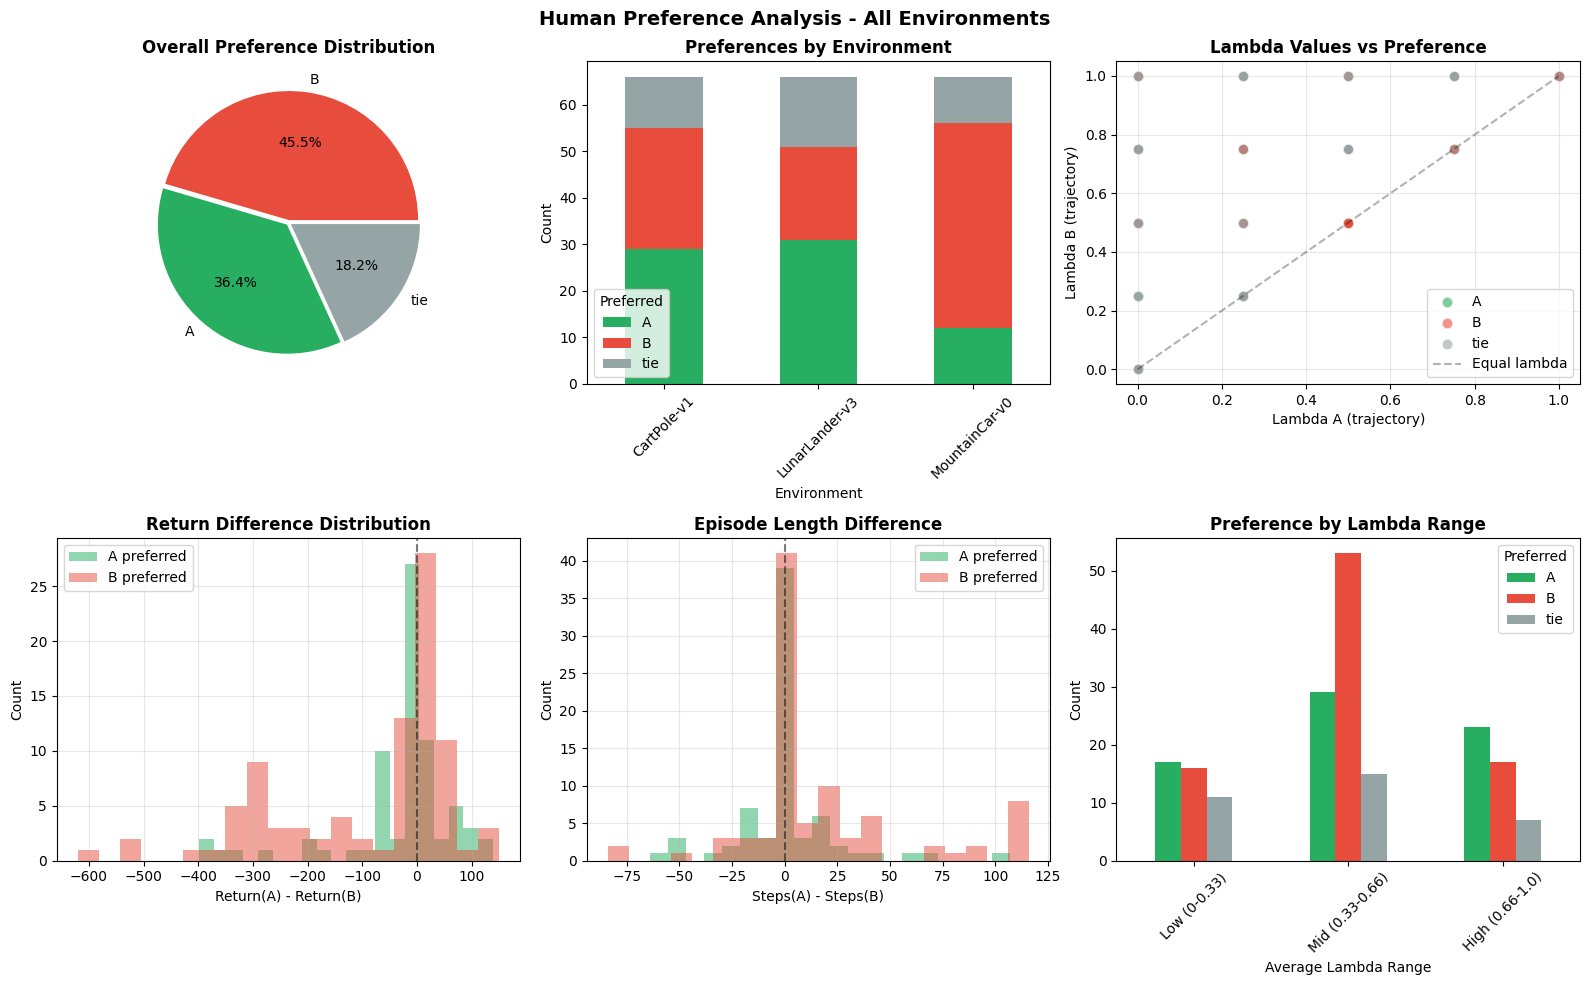


Saved visualization to 'preference_analysis.png'

PER ENVIRONMENT DETAILED ANALYSIS

ENVIRONMENT: CartPole-v1

Basic Statistics:
   Total pairs: 66
   A preferred: 29 (43.9%)
   B preferred: 26 (39.4%)
   tie preferred: 11 (16.7%)

Lambda Analysis:
   When A preferred: avg lambda_A = 0.267, avg lambda_B = 0.733
   When B preferred: avg lambda_A = 0.288, avg lambda_B = 0.635

Return Analysis:
   Avg return when A preferred: 485.46
   Avg return when B preferred: 488.11

Episode Length Analysis:
   Avg steps (A preferred): 500.0
   Avg steps (B preferred): 500.0

ENVIRONMENT: LunarLander-v3

Basic Statistics:
   Total pairs: 66
   A preferred: 31 (47.0%)
   B preferred: 20 (30.3%)
   tie preferred: 15 (22.7%)

Lambda Analysis:
   When A preferred: avg lambda_A = 0.226, avg lambda_B = 0.637
   When B preferred: avg lambda_A = 0.338, avg lambda_B = 0.787

Return Analysis:
   Avg return when A preferred: 104.83
   Avg return when B preferred: 73.23

Episode Length Analysis:
   Avg steps (A

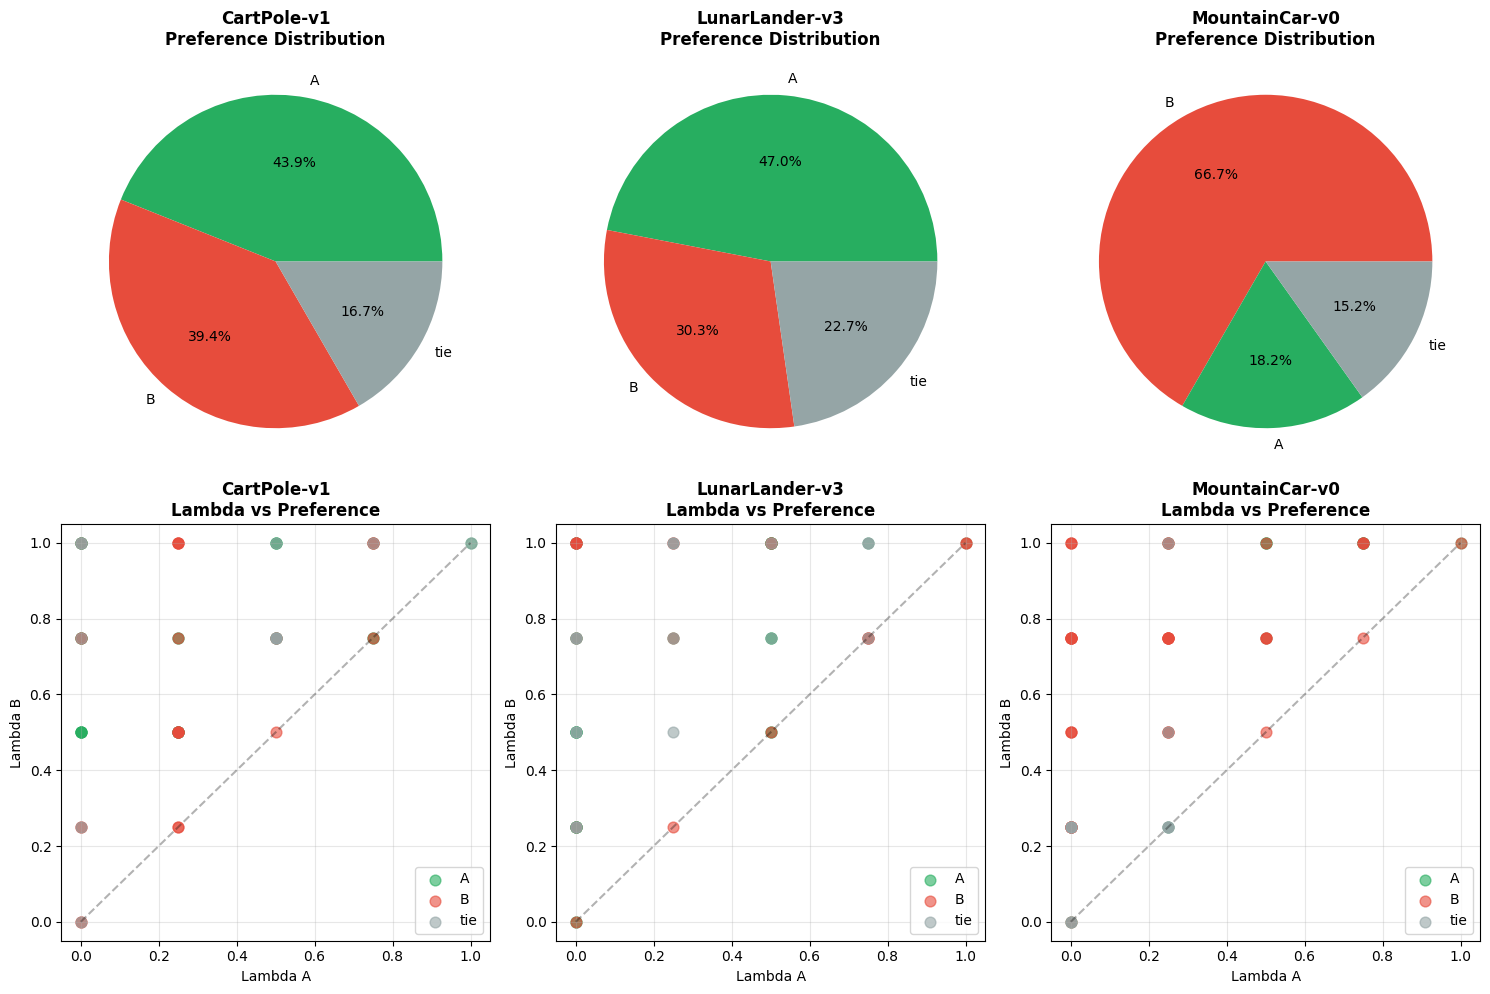


Saved to 'per_environment_analysis.png'

INTER ANNOTATOR AGREEMENT ANALYSIS

Annotator A:
   Total labels: 99
   A preferred: 44 (44.4%)
   B preferred: 32 (32.3%)
   Ties: 23 (23.2%)

Annotator D:
   Total labels: 99
   A preferred: 28 (28.3%)
   B preferred: 58 (58.6%)
   Ties: 13 (13.1%)

Consistency Analysis:
   A preference rate std across annotators: 0.081
   B preference rate std across annotators: 0.131
   [MODERATE AGREEMENT] Some variation between annotators


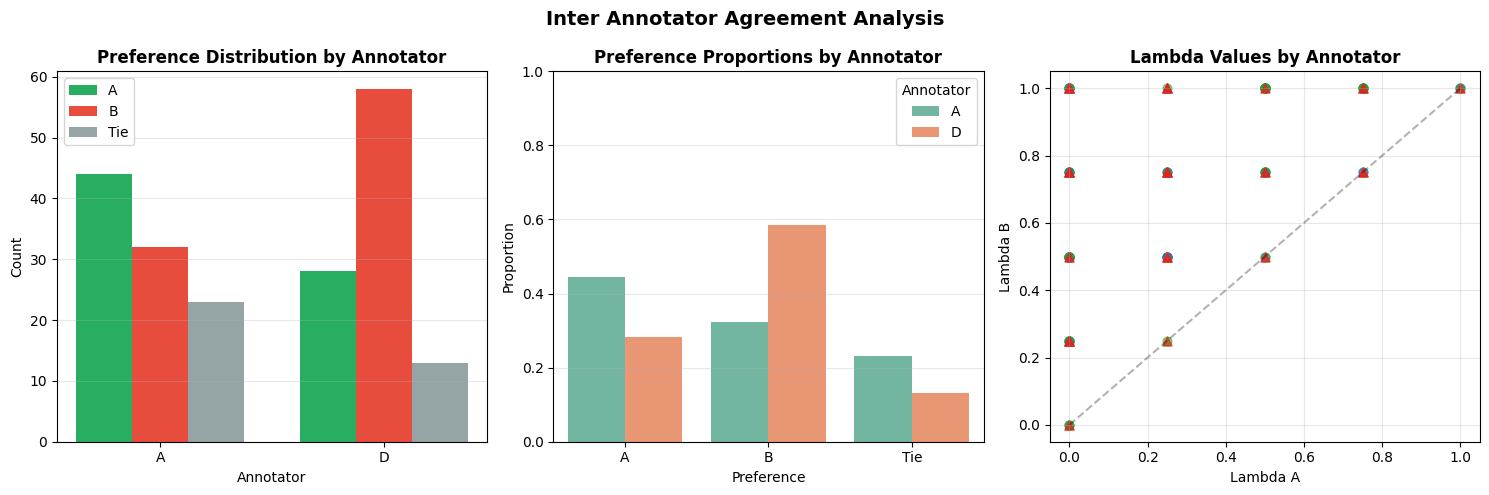


Saved to 'inter_annotator_agreement.png'

SAFETY VS SPEED PREFERENCE ANALYSIS

OVERALL STATISTICS:
----------------------------------------

Safer Trajectory Labels:
   A: 114 (57.6%)
   B: 49 (24.7%)
   tie: 34 (17.2%)
   B : 1 (0.5%)

Faster Trajectory Labels:
   B: 106 (53.5%)
   A: 67 (33.8%)
   tie: 25 (12.6%)

PREFERENCE CORRELATION ANALYSIS:
----------------------------------------
   Preferred matches Safer: 107/198 (54.0%)
   Preferred matches Faster: 119/198 (60.1%)
   Safer = Faster (same traj): 54/198 (27.3%)

PER ENVIRONMENT BREAKDOWN:
----------------------------------------

CartPole-v1:
   Preferred = Safer: 44/66 (66.7%)
   Preferred = Faster: 27/66 (40.9%)

LunarLander-v3:
   Preferred = Safer: 52/66 (78.8%)
   Preferred = Faster: 32/66 (48.5%)

MountainCar-v0:
   Preferred = Safer: 11/66 (16.7%)
   Preferred = Faster: 60/66 (90.9%)

PER ANNOTATOR BREAKDOWN:
----------------------------------------

A:
   Prefers Safer: 65/99 (65.7%)
   Prefers Faster: 43/99 (43.4%)


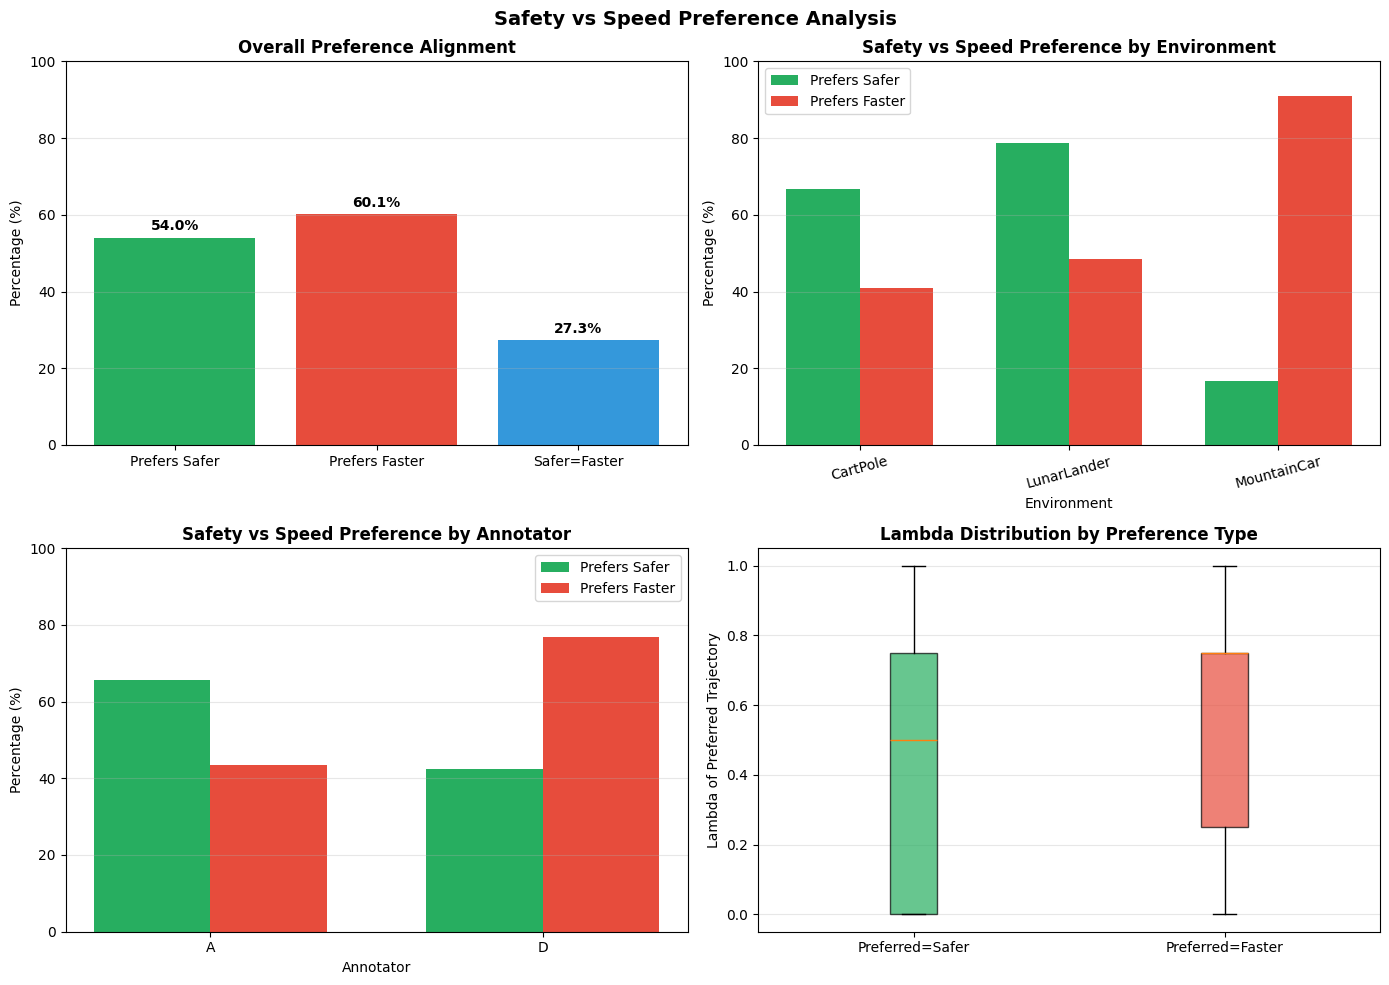


Saved to 'safety_speed_analysis.png'

Training Reward Model on Human Preferences
Loaded 198 labeled preference pairs from /content/human_preferences_complete.csv
Input dimension: 16
Training samples: 198
Epoch 10/50 | Loss: 0.6259
Epoch 20/50 | Loss: 0.5997
Epoch 30/50 | Loss: 0.5315
Epoch 40/50 | Loss: 0.5301
Epoch 50/50 | Loss: 0.5343

Best loss: 0.5301
Saved best model to reward_model_best.pth

REWARD MODEL EVALUATION

Overall Metrics:
   Accuracy (excluding ties): 69.14%
   Total samples: 198
   Ties excluded: 36

Per Environment Accuracy:
   CartPole-v1: 54.55% (55 samples)
   LunarLander-v3: 68.63% (51 samples)
   MountainCar-v0: 83.93% (56 samples)


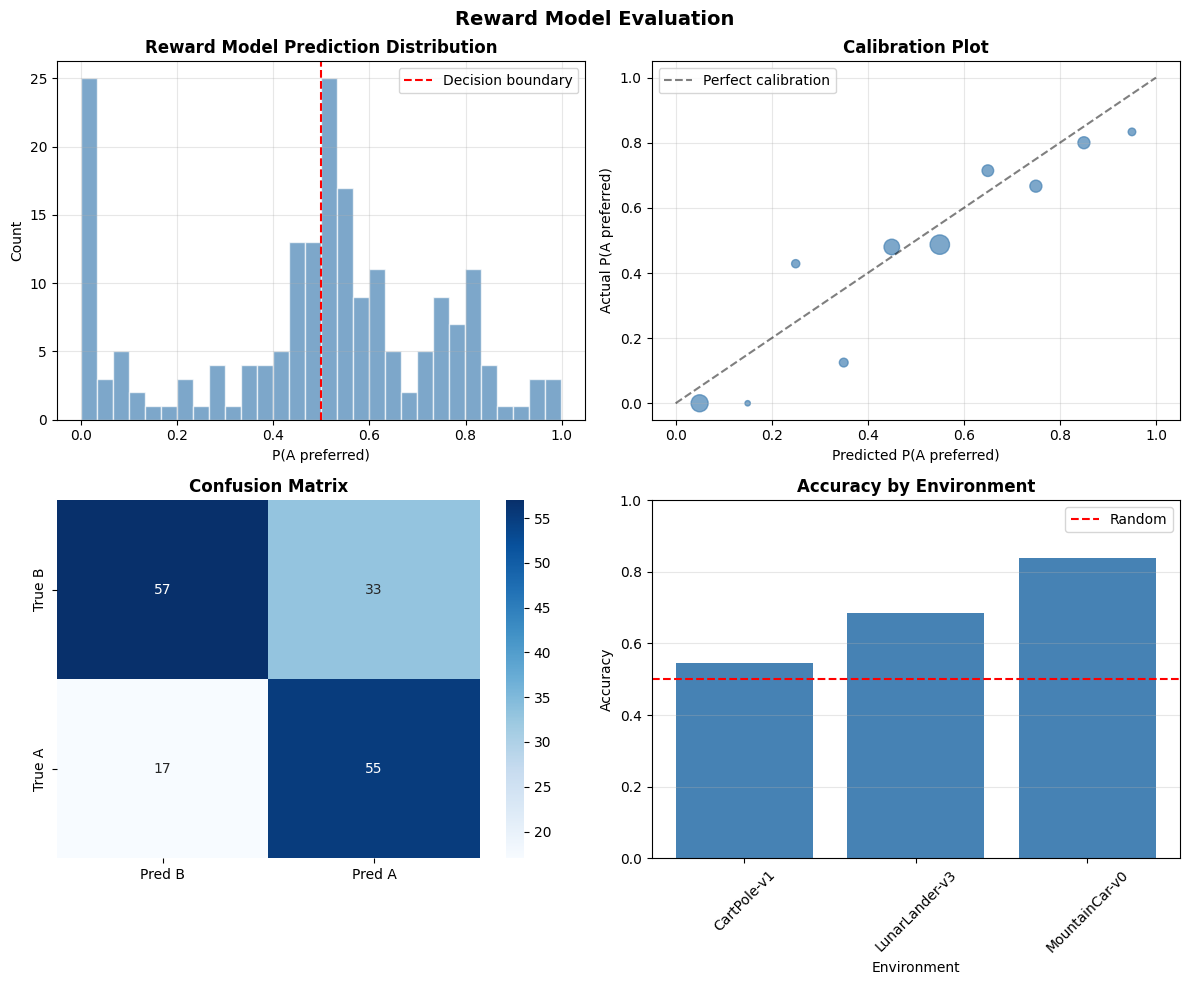


Saved to 'reward_model_evaluation.png'

MULTI ENVIRONMENT PARETO FRONTIER ANALYSIS

Evaluating CartPole-v1...
   lambda=0.0 (Safety): Speed=264.8, Safety=-178.9
   lambda=0.5 (Balanced): Speed=489.0, Safety=115.4
   lambda=1.0 (Speed): Speed=489.0, Safety=280.4

Evaluating LunarLander-v3...
   lambda=0.0 (Safety): Speed=41.2, Safety=492.9
   lambda=0.5 (Balanced): Speed=144.3, Safety=269.8
   lambda=1.0 (Speed): Speed=97.8, Safety=126.4

Evaluating MountainCar-v0...
   lambda=0.0 (Safety): Speed=-41.0, Safety=-73.2
   lambda=0.5 (Balanced): Speed=396.5, Safety=-147.6
   lambda=1.0 (Speed): Speed=294.3, Safety=-337.3


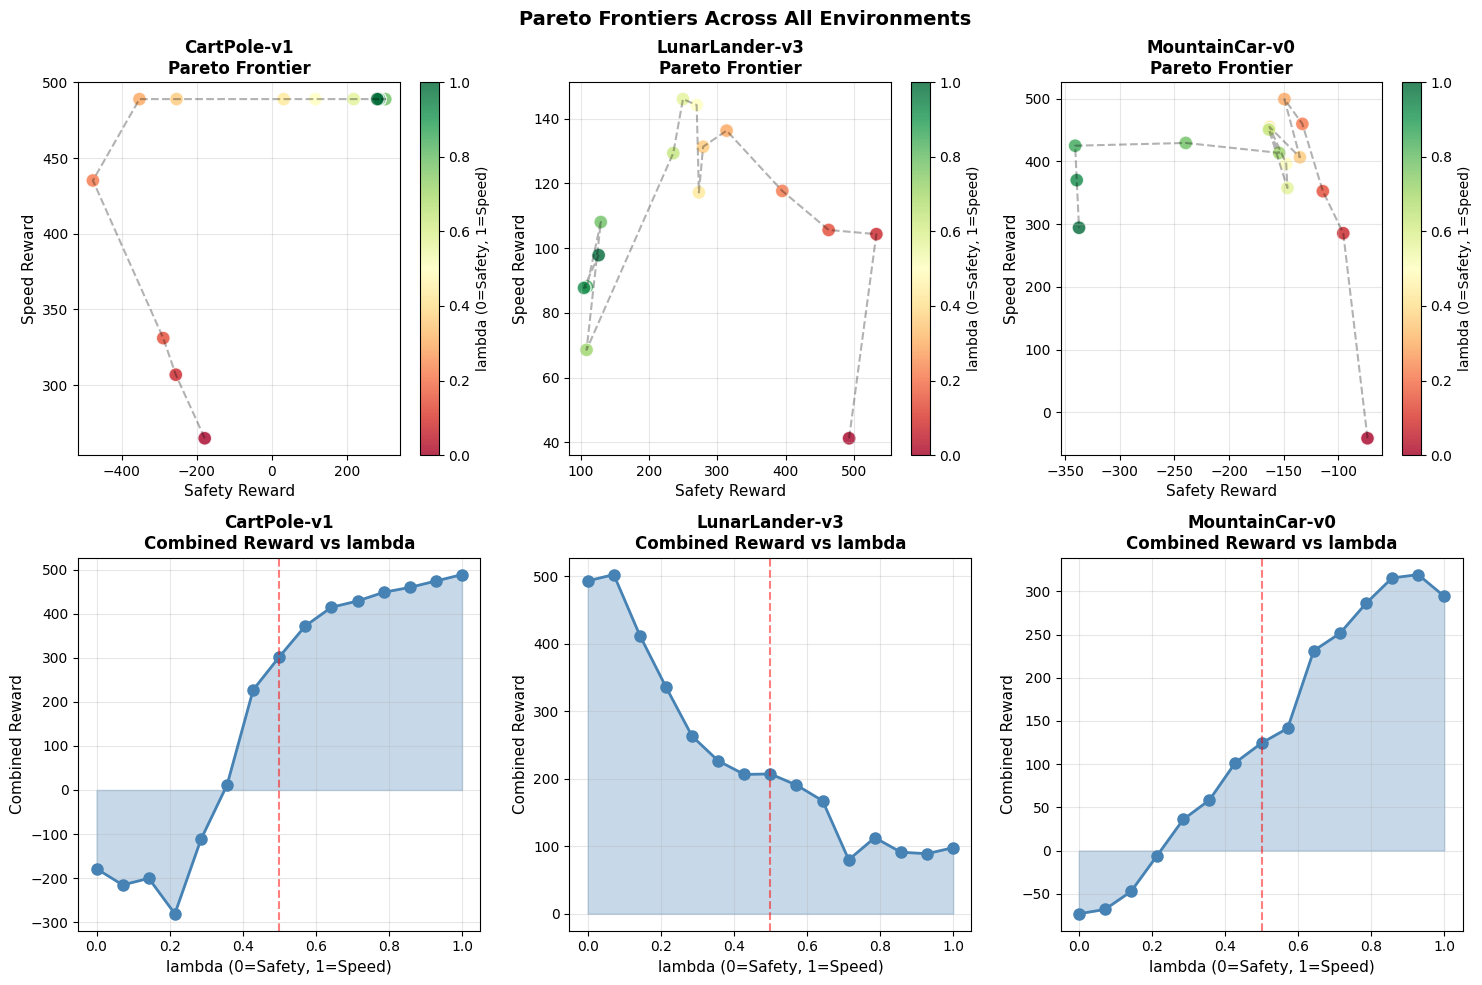


Saved to 'pareto_frontiers_all_envs.png'

ALL ANALYSES COMPLETE.

Generated files:
   - preference_analysis.png
   - per_environment_analysis.png
   - inter_annotator_agreement.png
   - safety_speed_analysis.png
   - reward_model_best.pth
   - reward_model_evaluation.png
   - pareto_frontiers_all_envs.png

STEP 2: RLHF fine tuning for each environment

Running RLHF fine tuning for CartPole-v1

FULL RLHF PIPELINE WITH EVALUATION - CartPole-v1

[1/4] Saving original agent state...

[2/4] Analyzing human preferences...
HUMAN PREFERENCE DATA ANALYSIS - CartPole-v1

Dataset Statistics:
   Total pairs collected: 198
   Labeled pairs: 66 (33.3%)
   Unlabeled pairs: 132

Annotators: 1
   A: 66 labels

Overall Preference Distribution:
   A:  29 ( 43.9%) #############
   B:  26 ( 39.4%) ###########
   tie:  11 ( 16.7%) #####

By Environment:
   CartPole-v1:
      Total: 66 | A: 29 | B: 26 | Tie: 11

Lambda Correlation Analysis:
   When A preferred: avg(lambda_A - lambda_B) = -0.466
   When B pr

/tmp/ipython-input-3820925278.py:675: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lambda_pref = labeled.groupby(


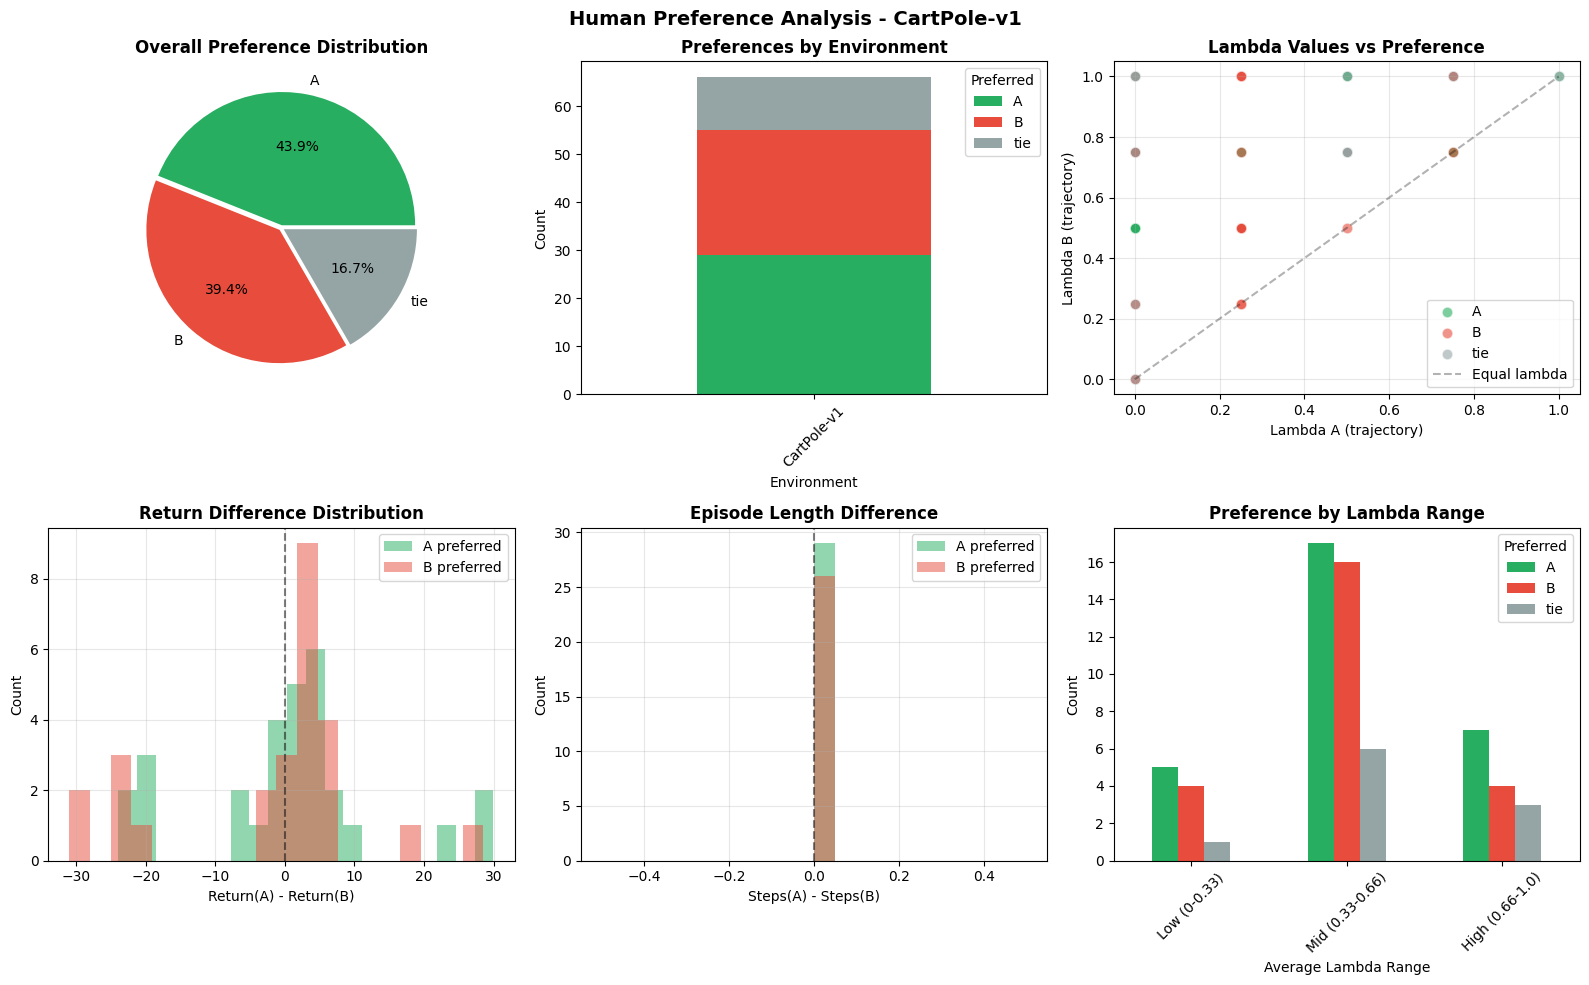


Saved visualization to 'CartPole_v1_preference_analysis.png'

[3/4] Training reward model on human preferences...
Training Reward Model on Human Preferences
Loaded 198 labeled preference pairs from /content/human_preferences_complete.csv
Input dimension: 16
Training samples: 198
Epoch 10/100 | Loss: 0.7460
Epoch 20/100 | Loss: 0.6448
Epoch 30/100 | Loss: 0.5423
Epoch 40/100 | Loss: 0.5776
Epoch 50/100 | Loss: 0.5360
Epoch 60/100 | Loss: 0.5753
Epoch 70/100 | Loss: 0.6085
Epoch 80/100 | Loss: 0.5720
Epoch 90/100 | Loss: 0.5934
Epoch 100/100 | Loss: 0.5437

Best loss: 0.4951
Saved best model to reward_model_best.pth

[4/4] Fine tuning agent on CartPole-v1...
RLHFTrainer: starting fine_tune on CartPole-v1
   Target episodes: 300, batch_size: 1024
   [Episode 300/300] train_reward=241.25, eval_env_reward=282.01, policy_loss=-0.004, value_loss=82.298
RLHFTrainer: finished fine_tune on CartPole-v1

GENERATING BEFORE AND AFTER COMPARISON...

BEFORE vs AFTER RLHF COMPARISON: CartPole-v1

Eval

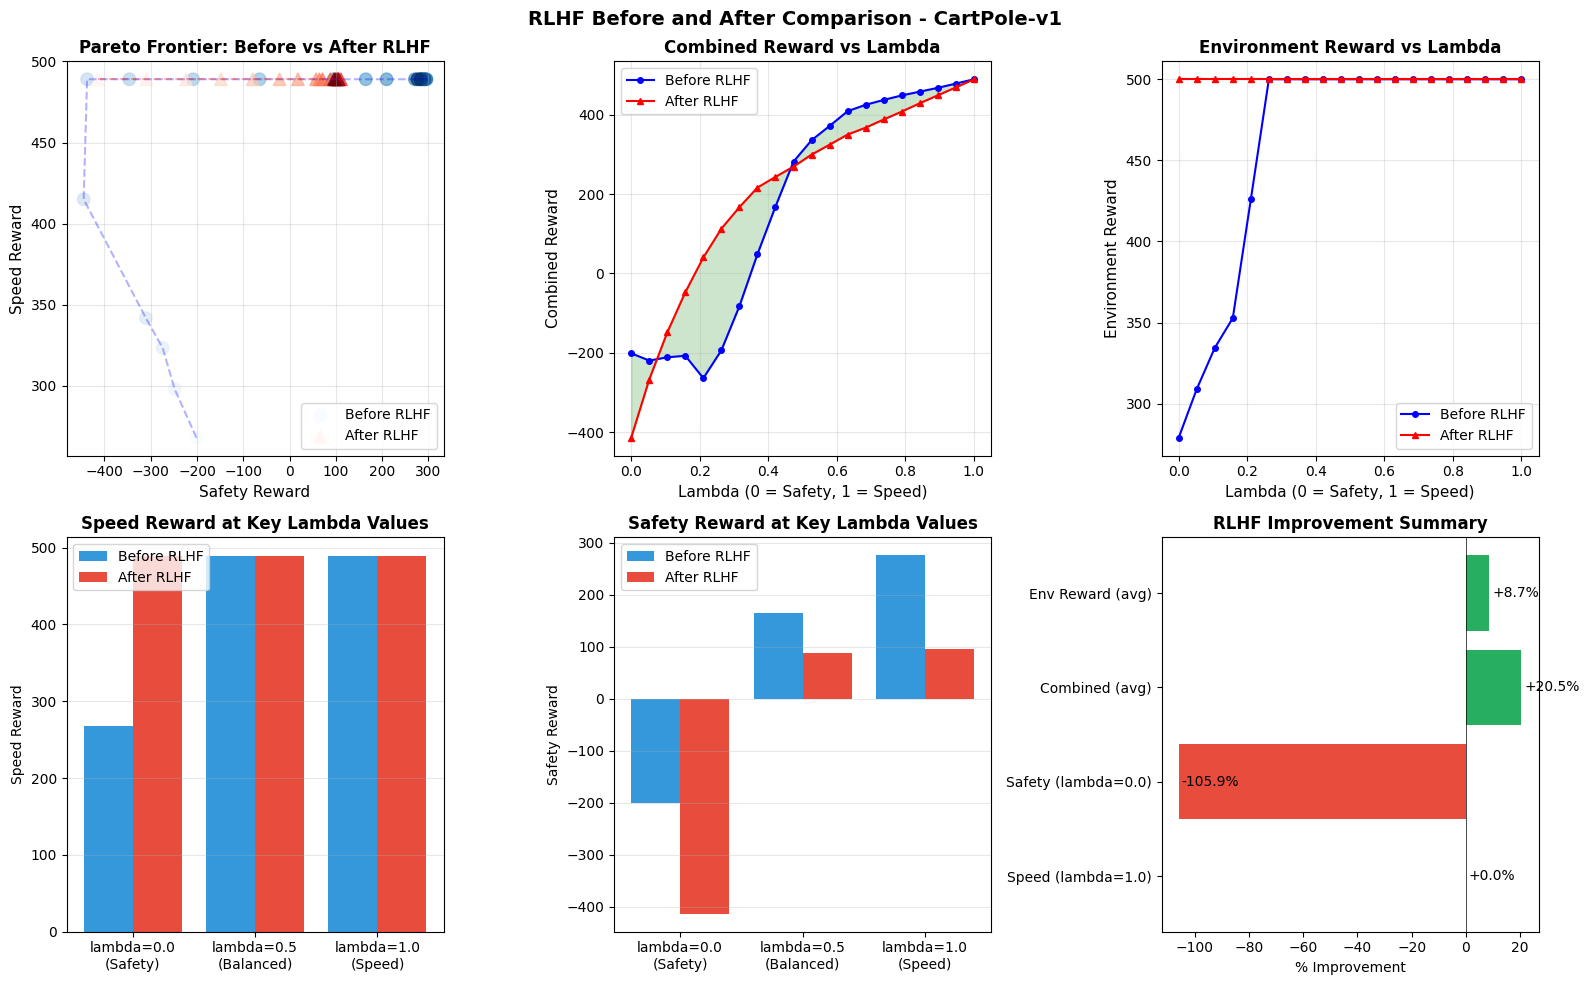


IMPROVEMENT SUMMARY:
   [-] Speed (lambda=1.0): +0.0%
   [-] Safety (lambda=0.0): -105.9%
   [+] Combined (avg): +20.5%
   [+] Env Reward (avg): +8.7%

Saved comparison to 'rlhf_comparison_CartPole_v1.png'

RLHF PIPELINE COMPLETE

Saved files:
   - lampo_CartPole_v1_rlhf_policy.pth
   - lampo_CartPole_v1_rlhf_value.pth
   - reward_model_best.pth
   - CartPole_v1_preference_analysis.png
   - rlhf_comparison_CartPole_v1.png

Running RLHF fine tuning for LunarLander-v3

FULL RLHF PIPELINE WITH EVALUATION - LunarLander-v3

[1/4] Saving original agent state...

[2/4] Analyzing human preferences...
HUMAN PREFERENCE DATA ANALYSIS - LunarLander-v3

Dataset Statistics:
   Total pairs collected: 198
   Labeled pairs: 66 (33.3%)
   Unlabeled pairs: 132

Annotators: 2
   A: 33 labels
   D: 33 labels

Overall Preference Distribution:
   A:  31 ( 47.0%) ##############
   B:  20 ( 30.3%) #########
   tie:  15 ( 22.7%) ######

By Environment:
   LunarLander-v3:
      Total: 66 | A: 31 | B: 20 | Tie: 

/tmp/ipython-input-3820925278.py:675: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lambda_pref = labeled.groupby(


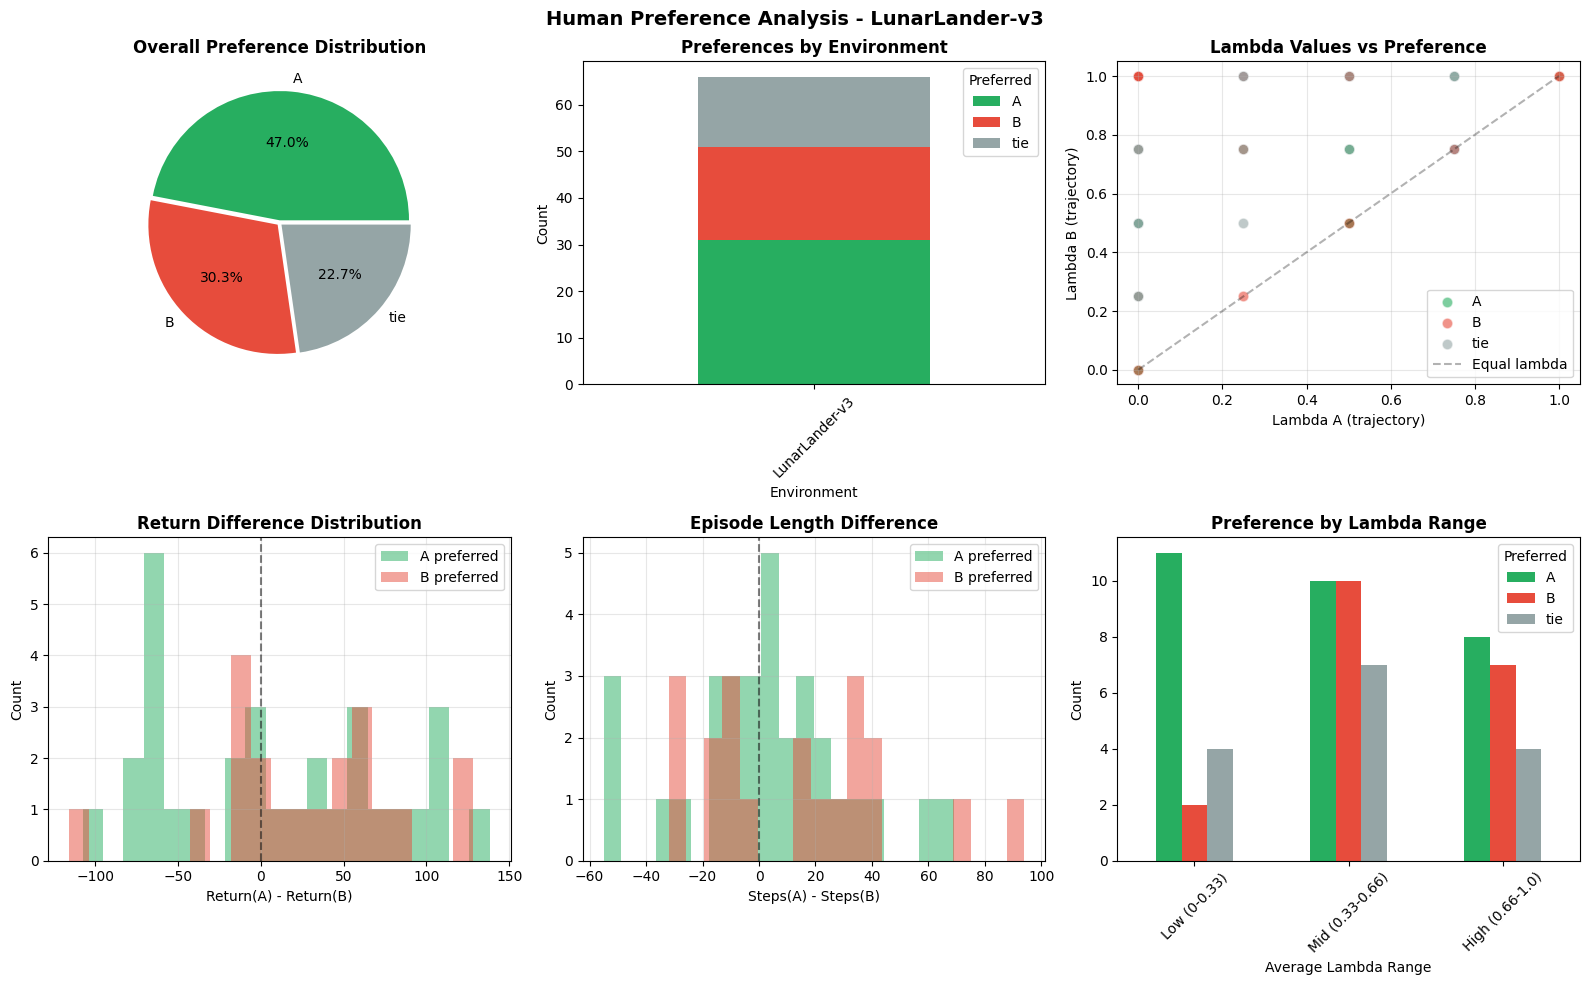


Saved visualization to 'LunarLander_v3_preference_analysis.png'

[3/4] Training reward model on human preferences...
Training Reward Model on Human Preferences
Loaded 198 labeled preference pairs from /content/human_preferences_complete.csv
Input dimension: 16
Training samples: 198
Epoch 10/100 | Loss: 0.6027
Epoch 20/100 | Loss: 0.5420
Epoch 30/100 | Loss: 0.6738
Epoch 40/100 | Loss: 0.5949
Epoch 50/100 | Loss: 0.5566
Epoch 60/100 | Loss: 0.6241
Epoch 70/100 | Loss: 0.8399
Epoch 80/100 | Loss: 0.5339
Epoch 90/100 | Loss: 0.5087
Epoch 100/100 | Loss: 0.5152

Best loss: 0.4986
Saved best model to reward_model_best.pth

[4/4] Fine tuning agent on LunarLander-v3...
RLHFTrainer: starting fine_tune on LunarLander-v3
   Target episodes: 300, batch_size: 1024
   [Episode 150/300] train_reward=88.09, eval_env_reward=232.29, policy_loss=-0.018, value_loss=38.259
   [Episode 200/300] train_reward=185.95, eval_env_reward=215.82, policy_loss=-0.005, value_loss=62.527
   [Episode 250/300] train_re

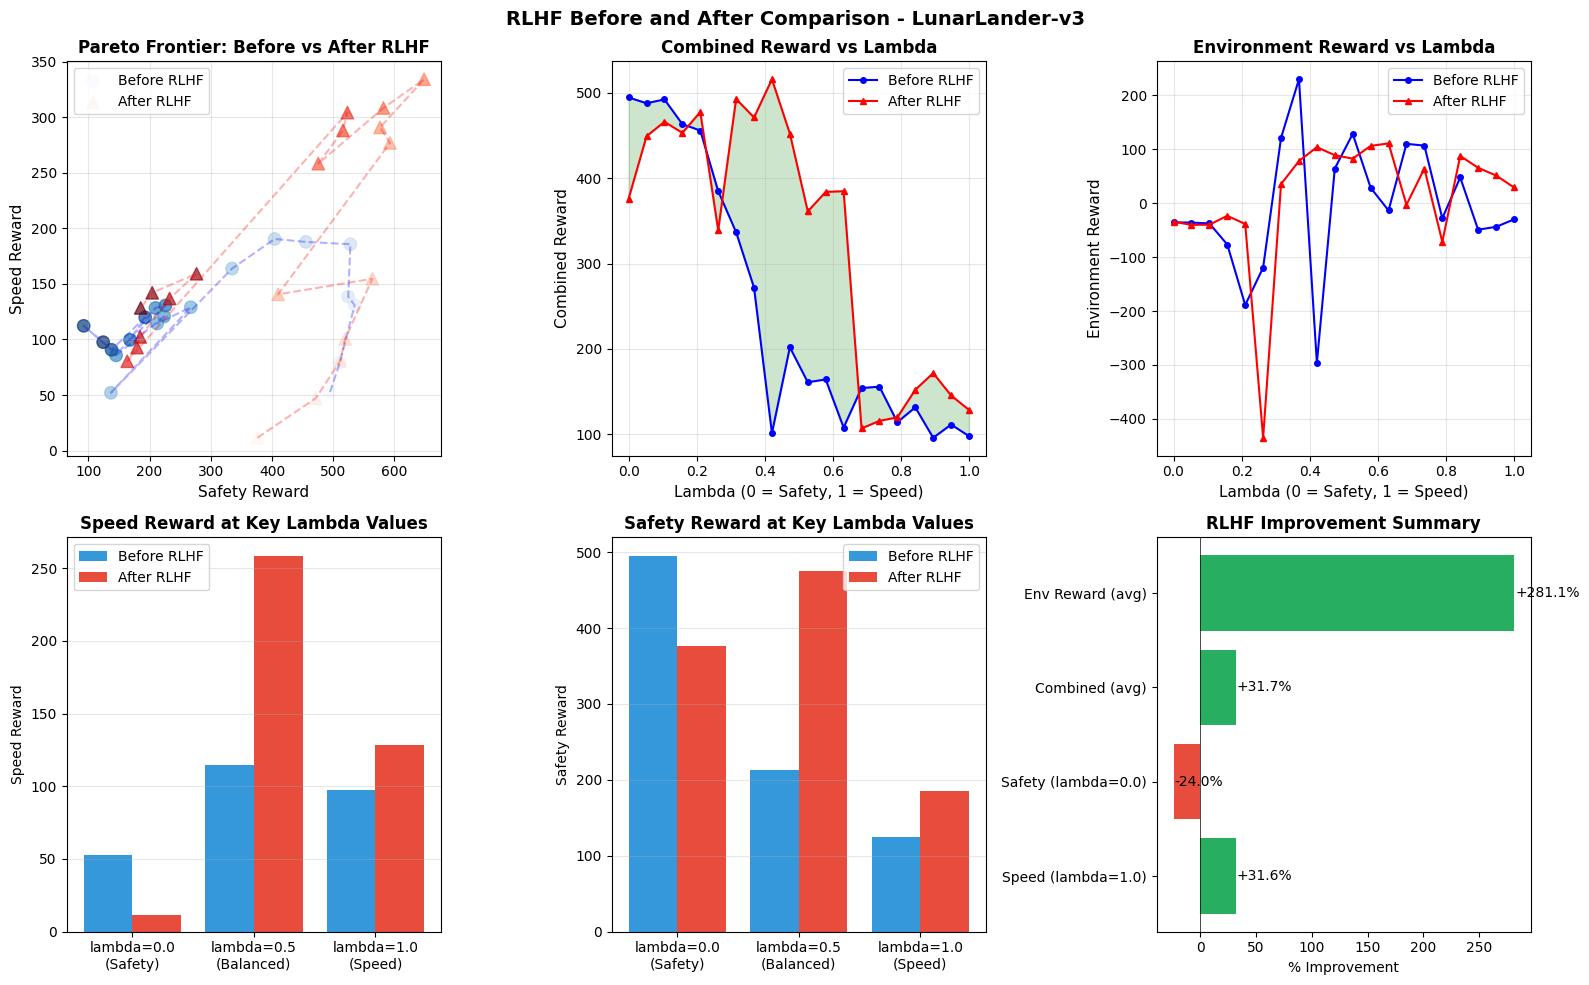


IMPROVEMENT SUMMARY:
   [+] Speed (lambda=1.0): +31.6%
   [-] Safety (lambda=0.0): -24.0%
   [+] Combined (avg): +31.7%
   [+] Env Reward (avg): +281.1%

Saved comparison to 'rlhf_comparison_LunarLander_v3.png'

RLHF PIPELINE COMPLETE

Saved files:
   - lampo_LunarLander_v3_rlhf_policy.pth
   - lampo_LunarLander_v3_rlhf_value.pth
   - reward_model_best.pth
   - LunarLander_v3_preference_analysis.png
   - rlhf_comparison_LunarLander_v3.png

Running RLHF fine tuning for MountainCar-v0

FULL RLHF PIPELINE WITH EVALUATION - MountainCar-v0

[1/4] Saving original agent state...

[2/4] Analyzing human preferences...
HUMAN PREFERENCE DATA ANALYSIS - MountainCar-v0

Dataset Statistics:
   Total pairs collected: 198
   Labeled pairs: 66 (33.3%)
   Unlabeled pairs: 132

Annotators: 1
   D: 66 labels

Overall Preference Distribution:
   B:  44 ( 66.7%) ####################
   A:  12 ( 18.2%) #####
   tie:  10 ( 15.2%) ####

By Environment:
   MountainCar-v0:
      Total: 66 | A: 12 | B: 44 | Tie:

/tmp/ipython-input-3820925278.py:675: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lambda_pref = labeled.groupby(


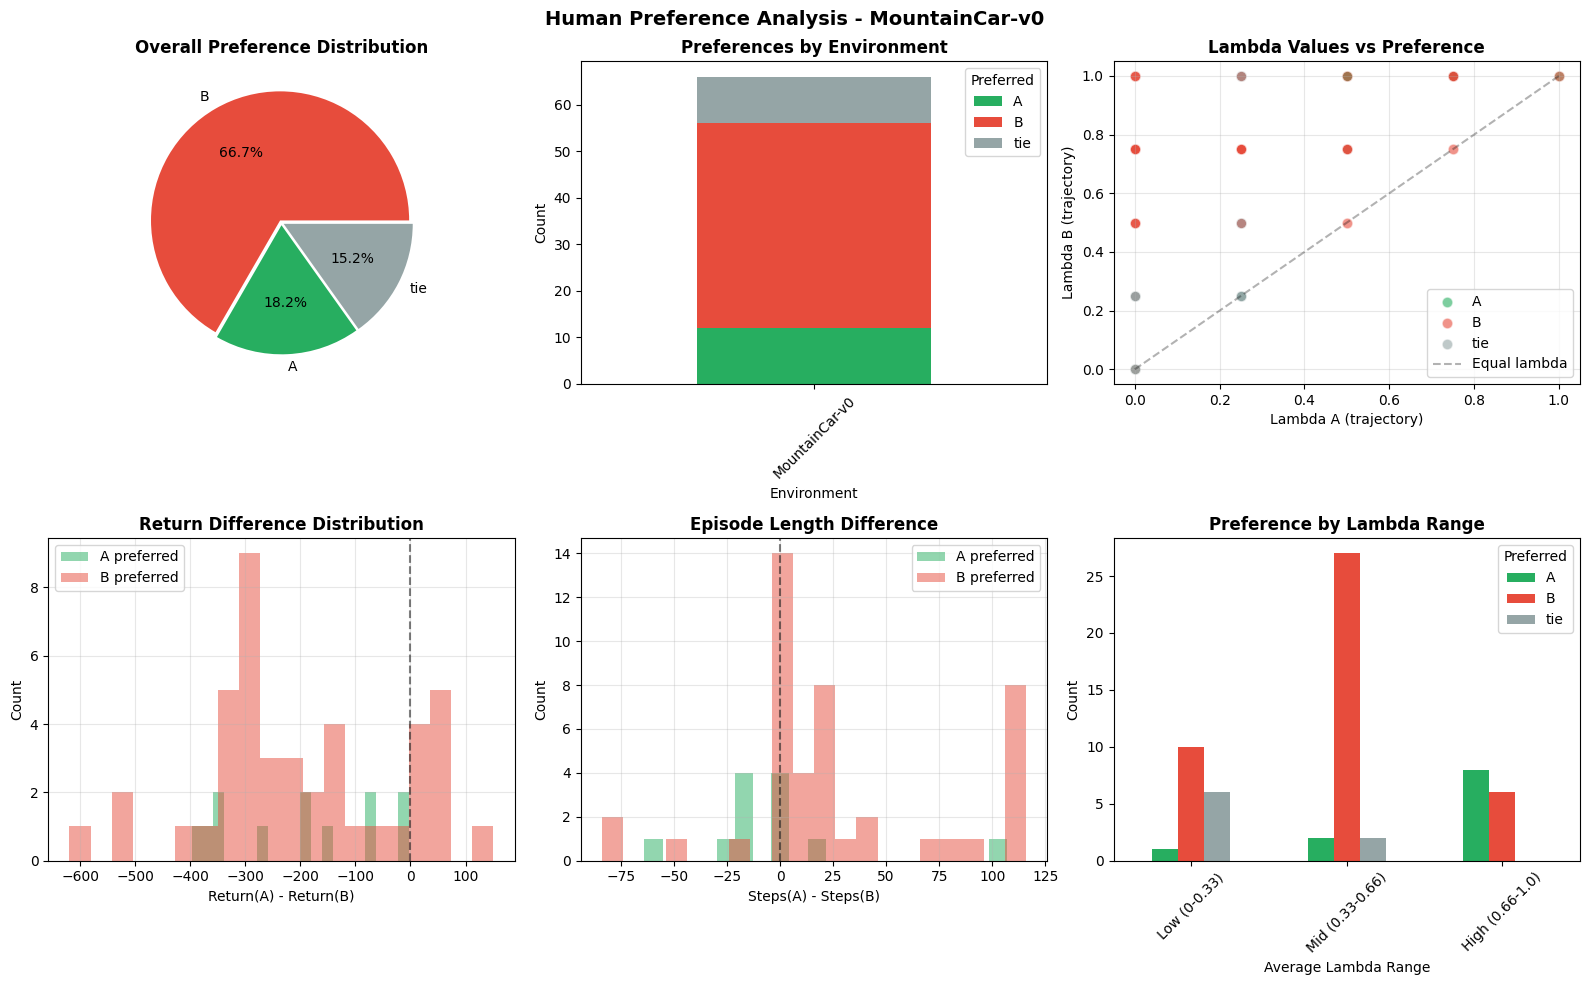


Saved visualization to 'MountainCar_v0_preference_analysis.png'

[3/4] Training reward model on human preferences...
Training Reward Model on Human Preferences
Loaded 198 labeled preference pairs from /content/human_preferences_complete.csv
Input dimension: 16
Training samples: 198
Epoch 10/100 | Loss: 0.5814
Epoch 20/100 | Loss: 0.5488
Epoch 30/100 | Loss: 0.5216
Epoch 40/100 | Loss: 0.5441
Epoch 50/100 | Loss: 0.5462
Epoch 60/100 | Loss: 0.5338
Epoch 70/100 | Loss: 0.5302
Epoch 80/100 | Loss: 0.5314
Epoch 90/100 | Loss: 0.5101
Epoch 100/100 | Loss: 0.5140

Best loss: 0.4967
Saved best model to reward_model_best.pth

[4/4] Fine tuning agent on MountainCar-v0...
RLHFTrainer: starting fine_tune on MountainCar-v0
   Target episodes: 300, batch_size: 1024
   [Episode 300/300] train_reward=30.66, eval_env_reward=121.80, policy_loss=-0.014, value_loss=19.097
RLHFTrainer: finished fine_tune on MountainCar-v0

GENERATING BEFORE AND AFTER COMPARISON...

BEFORE vs AFTER RLHF COMPARISON: Mounta

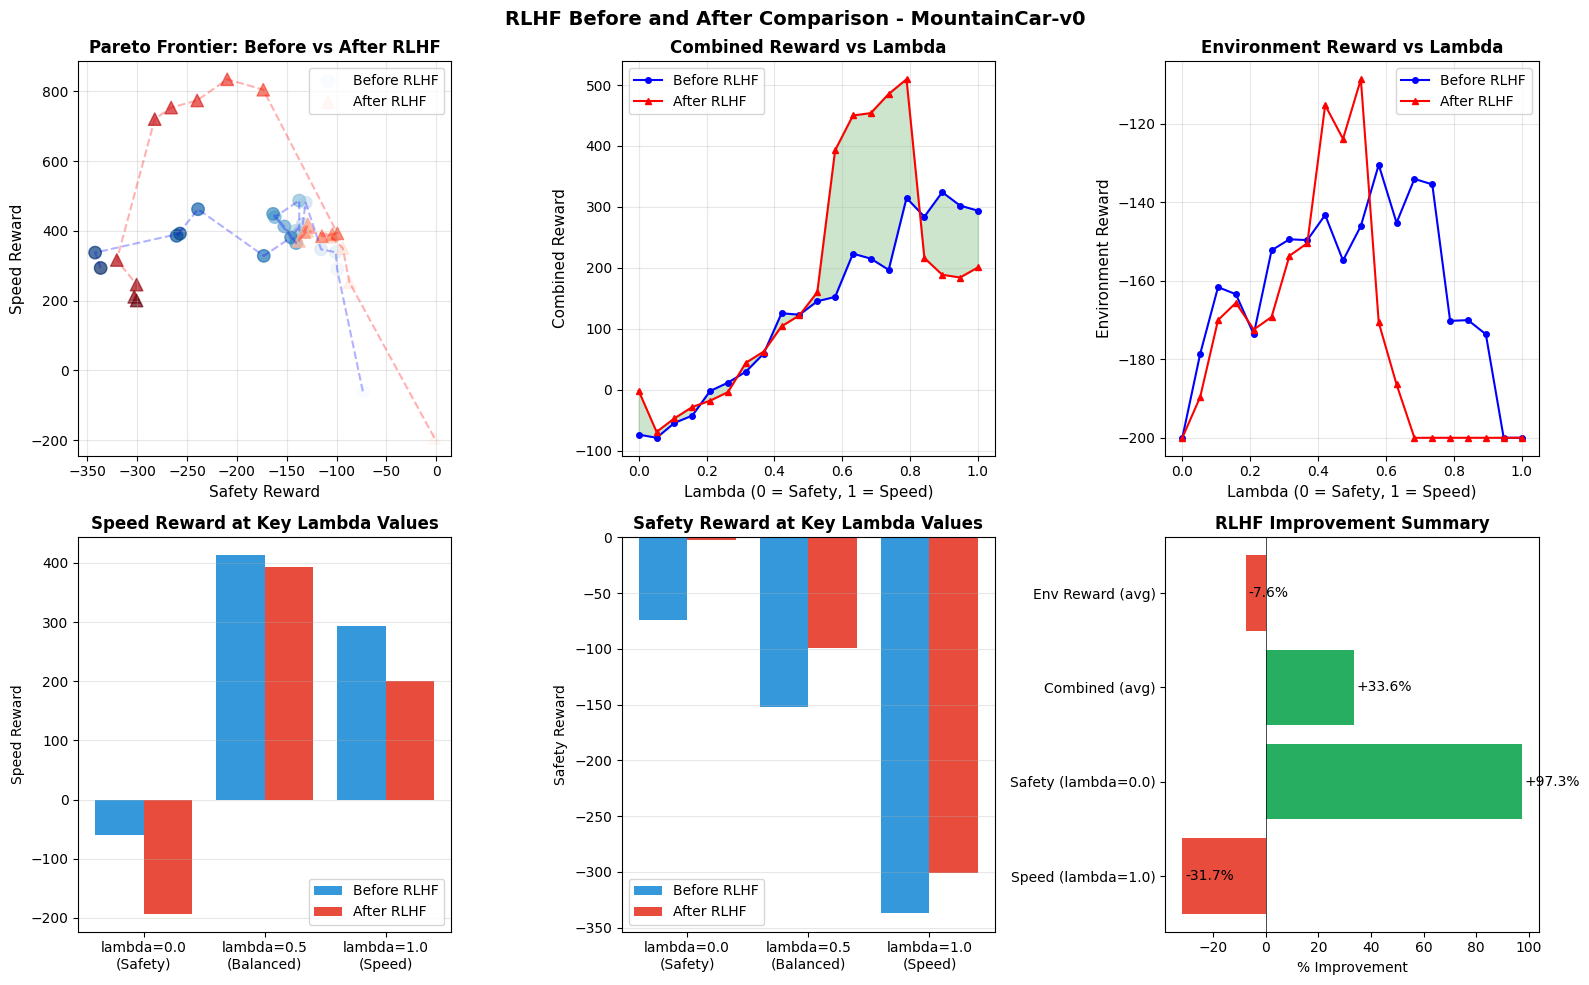


IMPROVEMENT SUMMARY:
   [-] Speed (lambda=1.0): -31.7%
   [+] Safety (lambda=0.0): +97.3%
   [+] Combined (avg): +33.6%
   [-] Env Reward (avg): -7.6%

Saved comparison to 'rlhf_comparison_MountainCar_v0.png'

RLHF PIPELINE COMPLETE

Saved files:
   - lampo_MountainCar_v0_rlhf_policy.pth
   - lampo_MountainCar_v0_rlhf_value.pth
   - reward_model_best.pth
   - MountainCar_v0_preference_analysis.png
   - rlhf_comparison_MountainCar_v0.png

STEP 3: Generating extra report figures and videos

GENERATING PROJECT REPORT FIGURES

[1/4] Generating preference analysis...
HUMAN PREFERENCE DATA ANALYSIS - All Environments

Dataset Statistics:
   Total pairs collected: 198
   Labeled pairs: 198 (100.0%)
   Unlabeled pairs: 0

Annotators: 2
   A: 99 labels
   D: 99 labels

Overall Preference Distribution:
   B:  90 ( 45.5%) #############
   A:  72 ( 36.4%) ##########
   tie:  36 ( 18.2%) #####

By Environment:
   CartPole-v1:
      Total: 66 | A: 29 | B: 26 | Tie: 11
   LunarLander-v3:
      Total

/tmp/ipython-input-3820925278.py:675: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lambda_pref = labeled.groupby(


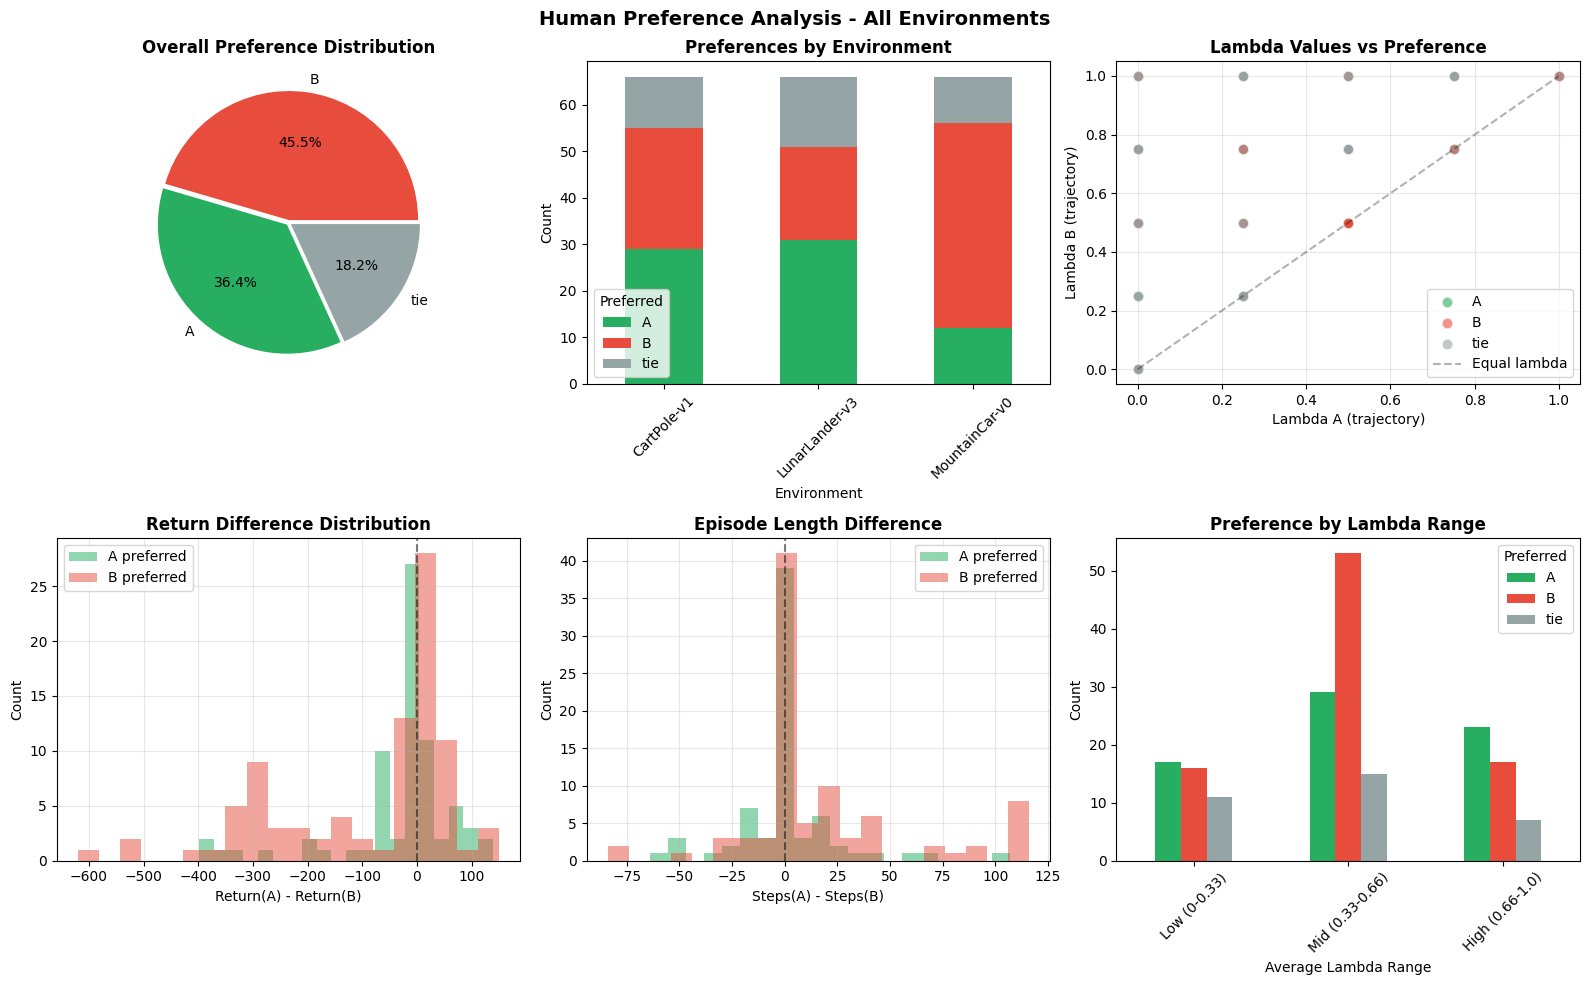


Saved visualization to 'preference_analysis.png'

[2/4] Skipping extra before/after comparison plots (already generated during RLHF runs).

[3/4] Generating training summary...

[4/4] Recording comparison videos...

Recording videos for CartPole-v1...


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/CartPole_v1_before_rlhf folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Recorded video on CartPole-v1, steps 500, total return 318.58


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/CartPole_v1_after_rlhf folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Recorded video on CartPole-v1, steps 500, total return 281.47



Recording videos for LunarLander-v3...


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/LunarLander_v3_before_rlhf folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Recorded video on LunarLander-v3, steps 264, total return 76.69


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/LunarLander_v3_after_rlhf folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Recorded video on LunarLander-v3, steps 251, total return 211.12



Recording videos for MountainCar-v0...


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/MountainCar_v0_before_rlhf folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Recorded video on MountainCar-v0, steps 117, total return 79.83


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/MountainCar_v0_after_rlhf folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Recorded video on MountainCar-v0, steps 89, total return 140.78



All report figures generated!

COMPLETE RLHF ANALYSIS FINISHED
All analyses, RLHF runs, figures and models are complete.


In [ ]:
# ===================== Snippet 3: Top level RLHF pipeline =====================

CSV_PATH = "/content/human_preferences_complete.csv"

base_agents = {
    env_id_cartpole: lampo_cartpole,
    env_id_lander: lampo_lander,
    env_id_mountaincar: lampo_mountaincar,
}

env_ids = [env_id_cartpole, env_id_lander, env_id_mountaincar]

print("=" * 70)
print("Running complete RLHF analysis for all environments")
print("=" * 70)
print("Using preferences from: {}".format(CSV_PATH))
print("")

print("\n" + "=" * 70)
print("STEP 1: Global analysis and reward model training")
print("=" * 70)

reward_model_global = run_complete_project_analysis(
    csv_path=CSV_PATH,
    agents_dict=base_agents,
    env_ids=env_ids,
    download_files=False
)

print("\n" + "=" * 70)
print("STEP 2: RLHF fine tuning for each environment")
print("=" * 70)

agents_before_after = {}

for env_id in env_ids:
    if env_id not in base_agents:
        print("WARNING: No base agent found for {}. Skipping.".format(env_id))
        continue

    print("\n" + "=" * 70)
    print("Running RLHF fine tuning for {}".format(env_id))
    print("=" * 70)

    agent = base_agents[env_id]

    reward_model_env, results_env, agent_before = run_full_rlhf_with_comparison(
        csv_path=CSV_PATH,
        env_id=env_id,
        agent=agent,
        n_epochs=100,
        n_finetune_episodes=300,
    )

    if agent_before is not None:
        agents_before_after[env_id] = (agent_before, agent)

print("\n" + "=" * 70)
print("STEP 3: Generating extra report figures and videos")
print("=" * 70)

if agents_before_after:
    generate_report_figures(
        agents_dict=agents_before_after,
        env_ids=env_ids,
        csv_path=CSV_PATH,
    )
else:
    print("WARNING: No before/after agent pairs available. Skipping generate_report_figures.")


print("\n" + "=" * 70)
print("COMPLETE RLHF ANALYSIS FINISHED")
print("=" * 70)
print("All analyses, RLHF runs, figures and models are complete.")
